<a href="https://colab.research.google.com/github/annkvth/kompleteNetze/blob/main/03b_international_robustness_with_functions_more_csv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install traffic

In [ ]:
from datetime import datetime, timedelta
import pandas as pd
import networkx as nx
from functools import partialmethod
from google.colab import drive
import os
import glob
from traffic.data import airports
import altair as alt
import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox


define lists of airports with more than 50k passengers


In [ ]:
# Deutschland
icaolistD=["EDDB", "EDVE", "EDDW", "EDLW", "EDDC", "EDDL", "EDDE", "EDDF", "EDFH", "EDNY", "EDDH", "EDDV", "EDSB", "EDVK", "EDDK", "EDDP", "EDHL", "EDJA", "EDDM", "EDDG", "EDLV", "EDDN", "EDLP", "ETNL", "EDDR", "EDDS", "EDXW"]
markerD='o-'
colorD='red'

# Italien
icaolistI=["LIRF", "LIMC", "LIME", "LIRN", "LIPZ", "LICC", "LIPE", "LIML", "LICJ", "LIBD", "LIRP", "LIEE", "LIMF", "LIRA", "LIPX", "LIEO", "LIBR", "LIRQ", "LIPH", "LICA", "LIEA", "LICT", "LIMJ", "LIPQ", "LIBP", "LIRZ", "LIPY", "LICD", "LICB", "LICR", "LIPR", "LIBC", "LIPK", "LIMP", "LIMZ", "LICG"]
markerI='v-'
colorI='firebrick'

# Spanien - die, die nicht mit LE anfangen, sind abseits des Festlands, vor allem Canaren
icaolistS=["LEZL", "LEZG", "LEXJ", "LEVX", "LEVT", "LEVD", "LEVC", "LEST", "LESO", "LERS", "LEPP", "LEPA", "LEMI", "LEMH", "LEMG", "LEMD", "LELN", "LEJR", "LEIB", "LEGR", "LEGE", "LECO", "LEBZ", "LEBL", "LEBB", "LEAS", "LEAM", "LEAL", "GEML", "GCXO", "GCTS", "GCRR", "GCLP", "GCLA", "GCHI", "GCGM", "GCFV"]
markerS='d-'
colorS='peru'

# Frankreich - alles was nicht LF ist ist Übersee
icaolistF=["LFBD", "LFBE", "LFBH", "LFBL", "LFBO", "LFBP", "LFBT", "LFBZ", "LFGJ", "LFJL", "LFKB", "LFKC", "LFKF", "LFKJ", "LFLB", "LFLC", "LFLL", "LFLS", "LFMK", "LFML", "LFMN", "LFMP", "LFMT", "LFMU", "LFOB", "LFOT", "LFPB", "LFPG", "LFPO", "LFQQ", "LFRB", "LFRK", "LFRN", "LFRS", "LFSB", "LFST", "LFTH", "LFTW", "NTAA", "NTTB", "NTTG", "NTTH", "NTTR", "NWWL", "NWWM", "NWWW", "SOCA", "TFFF", "TFFG", "TFFJ", "TFRR", "FMCZ", "FMEE"]
markerF='^-'
colorF='darkorange'


pick which country to analyse in this runtime

In [ ]:
option = 1 # 1=Deutschland, 2=Italien, 3=Spanien, 4=Frankreich
if option == 1:
  icaolist = icaolistD
  countryname = "deutschland_v2"
  markerToUse = markerD
  colorToUse = colorD
elif option == 2:
  icaolist = icaolistI
  countryname = "italien"
  markerToUse = markerI
  colorToUse = colorI
elif option == 3:
  icaolist = icaolistS
  countryname = "spanien"
  markerToUse = markerS
  colorToUse = colorS
elif option  == 4:
  icaolist = icaolistF
  countryname = "frankreich"
  markerToUse = markerF
  colorToUse = colorF


where to read and save the data (and making sure that the directory exist)

In [ ]:
drive.mount('/content/drive')
folder_path = "/content/drive/My Drive/2024KomplexeNetze/Daten"
if not os.path.exists(folder_path):
    print(f'No such folder: {folder_path}')
csv_files = sorted(glob.glob(os.path.join(folder_path, f"*{countryname}.csv")))
print(csv_files)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['/content/drive/My Drive/2024KomplexeNetze/Daten/2018-01-01_2018-04-01_deutschland_v2.csv', '/content/drive/My Drive/2024KomplexeNetze/Daten/2018-04-01_2018-07-01_deutschland_v2.csv', '/content/drive/My Drive/2024KomplexeNetze/Daten/2018-07-01_2018-10-01_deutschland_v2.csv', '/content/drive/My Drive/2024KomplexeNetze/Daten/2018-10-01_2019-01-01_deutschland_v2.csv', '/content/drive/My Drive/2024KomplexeNetze/Daten/2019-01-01_2019-04-01_deutschland_v2.csv', '/content/drive/My Drive/2024KomplexeNetze/Daten/2019-04-01_2019-07-01_deutschland_v2.csv', '/content/drive/My Drive/2024KomplexeNetze/Daten/2019-07-01_2019-10-01_deutschland_v2.csv', '/content/drive/My Drive/2024KomplexeNetze/Daten/2019-10-01_2020-01-01_deutschland_v2.csv', '/content/drive/My Drive/2024KomplexeNetze/Daten/2020-01-01_2020-04-01_deutschland_v2.csv', '/content/drive/My Drive/2024KomplexeNetze

In [ ]:
# always useful
pd.DataFrame.query = partialmethod(pd.DataFrame.query, engine="python")

let's define some functions we will use later. First:

Function to calculate international efficiency using the graph

In [ ]:
def calculate_graph_IE(graph):
    total_reciprocal_shortest_paths = {}

    for icao in icaolist:
        if icao in graph: # Check if icao is in the graph
            total_reciprocal_shortest_path_for_icao = 0
            shortest_paths = nx.single_source_shortest_path_length(graph, source=icao)
            for arrival_airport in international_list:
                if arrival_airport in shortest_paths:
                    # only if not zero
                    if shortest_paths[arrival_airport] != 0:
                        total_reciprocal_shortest_path_for_icao += 1/shortest_paths[arrival_airport]
                        total_reciprocal_shortest_paths[icao] = total_reciprocal_shortest_path_for_icao

    sum_of_reciprocals = sum(total_reciprocal_shortest_paths.values())
    IE = sum_of_reciprocals * 1/(len(international_list) * len(icaolist))
    #print(f"The international effiency of the given graph is: {IE}")

    return IE


Function to processes the input graph by creating subgraphs, reducing edge weights, and removing edges until no more destination nodes remain in the inputgraph that are not part of icaolist.
  

In [ ]:
def decompose_graph(inputgraph, icaolist):
  subgraph_list = []

  while True:
      # Check if there are any destination nodes left that are not in icaolist
      destination_nodes_outside_icaolist = False
      for u, v, data in inputgraph.edges(data=True):
        if v not in icaolist:
            destination_nodes_outside_icaolist = True
            break

      if not destination_nodes_outside_icaolist or inputgraph.number_of_edges() == 0:
        break

      subgraph = nx.DiGraph()
      for u, v, data in inputgraph.edges(data=True):
          subgraph.add_edge(u, v, weight=1)

      subgraph_list.append(subgraph)

      edges_to_remove = []
      for u, v, data in inputgraph.edges(data=True):
          new_weight = data.get('weight', 1) - 1
          if new_weight <= 0:
              edges_to_remove.append((u, v))
          else:
              inputgraph[u][v]['weight'] = new_weight

      inputgraph.remove_edges_from(edges_to_remove)

  #print("Subgraph history length:", len(subgraph_list))
  return subgraph_list


And finally:
Function for the Weighted International Efficiency

*To clarify: what is the "number of connections between i and j" - per day, month, year, average?

Using per month I get WIE=3, using the average per week I get WIE=1.14 for 2024-01-01_2024-04-01.csv

In the Zhou 2021 paper they have 1.5 for Germany, but don't specify which "number of connections" they use.
... or maybe it doesn't matter, as long as we keep the same timeframe as base for comparisons. *


In [ ]:
def analyze_graph_WIE(graph):
    decomposed_subgraphs = decompose_graph(graph, icaolist)

    total_ie = 0
    for subnet in decomposed_subgraphs:
      ie = calculate_graph_IE(subnet)
      total_ie += ie
    return total_ie


Another function that is needied as step 1 for international robustness:
remove the airport with the highest number of international connections


In [ ]:
def remove_highest_degree_node(graph, icaolist):
    # check if domestic airports remain: create a subgraph containing only nodes from the icaolist
    subgraph = graph.subgraph(icaolist)
    if not subgraph.nodes():
      return graph

    # Find the node with the highest outgoing degree in the graph
    degreelist=list(graph.out_degree(weight="weight"))
    # Filter degreelist to keep only nodes present in icaolist
    degreelist = [(node, degree) for node, degree in degreelist if node in icaolist]
    # [('EDDF', 15044), ('EDDM', 12554), ...]
    max_grade = max(degreelist, key=lambda x: x[1])[1]
    max_grade_nodes_list = [node[0] for node in graph.out_degree(weight='weight') if node[1] == max_grade]
    highest_degree_node = max_grade_nodes_list[0]
    #print(degreelist[:3])

    # Create a copy of the graph to avoid modifying the original
    modified_graph = graph.copy()

    # Remove the node and its connected edges from the modified graph
    removed_name = f"{highest_degree_node}"
    modified_graph.remove_node(highest_degree_node)


    return modified_graph, removed_name


--------------------------------------------

## Main Part

--------------------------------------------

now loop over the csv files, processing them one by one:
 - create directed graph
 - call my functions to determine WIE for each of them


/content/drive/My Drive/2024KomplexeNetze/Daten/2018-01-01_2018-04-01_deutschland_v2.csv
Number of nodes (airports): 584
Number of edges (flight routes): 3584, sum of weights (flights) 52388.0
Found 653 international airports to check against
Number of edges (domestic flight routes): 1081, sum of weights (domestic flights) 17965.0
Number of edges (international flight routes): 2503, sum of weights (international flights) 34423.0
WIE_post has become zero.
International robustness for 2018-01: 0.6402988923440349


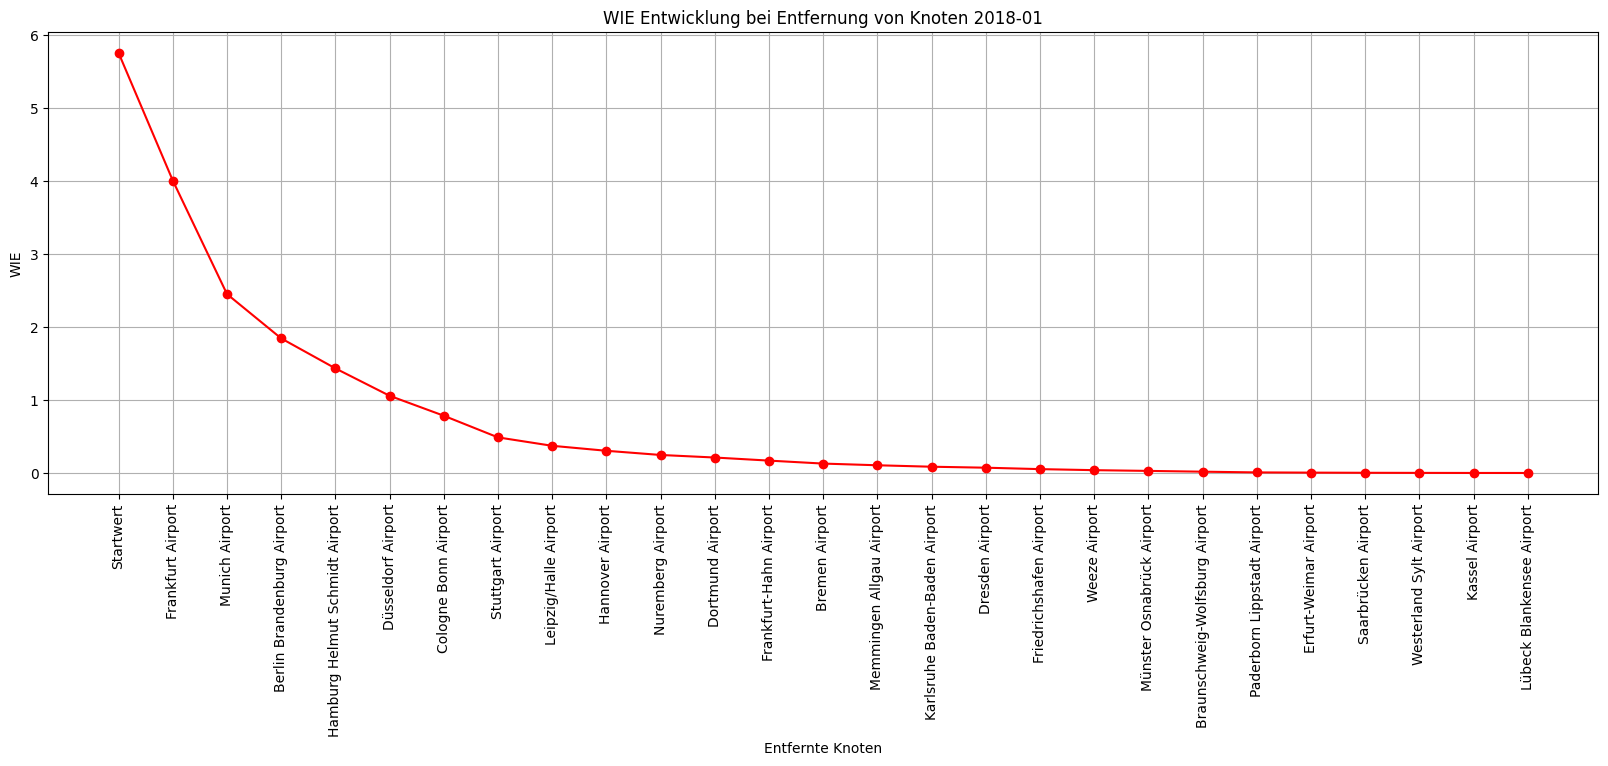

Number of nodes (airports): 596
Number of edges (flight routes): 3640, sum of weights (flights) 52528.0
Found 653 international airports to check against
Number of edges (domestic flight routes): 1119, sum of weights (domestic flights) 18012.0
Number of edges (international flight routes): 2521, sum of weights (international flights) 34516.0
WIE_post has become zero.
International robustness for 2018-02: 0.6426797913992424


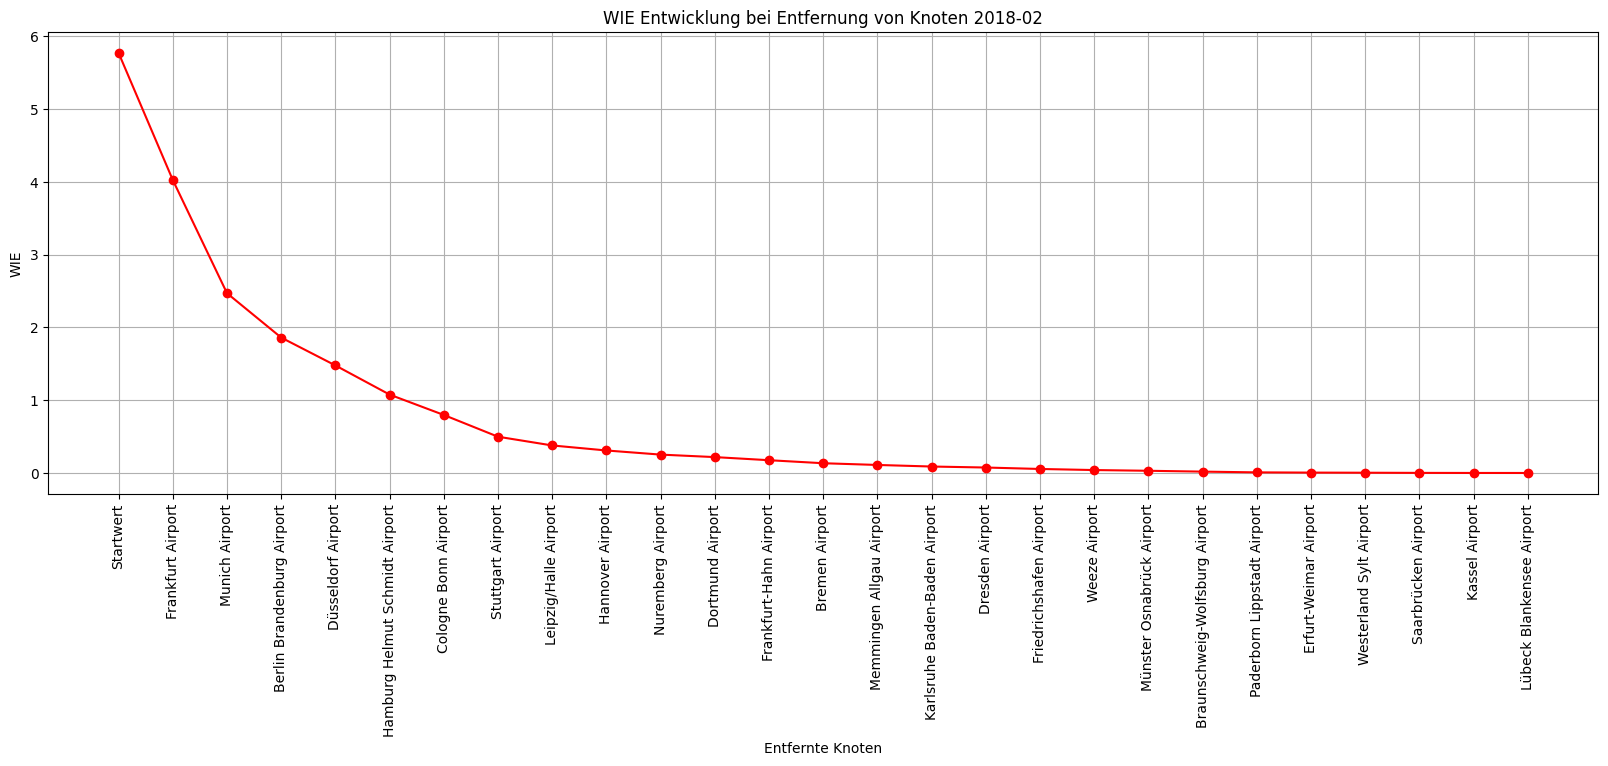

Number of nodes (airports): 629
Number of edges (flight routes): 3753, sum of weights (flights) 52910.0
Found 653 international airports to check against
Number of edges (domestic flight routes): 1129, sum of weights (domestic flights) 18030.0
Number of edges (international flight routes): 2624, sum of weights (international flights) 34880.0
WIE_post has become zero.
International robustness for 2018-03: 0.642047541670803


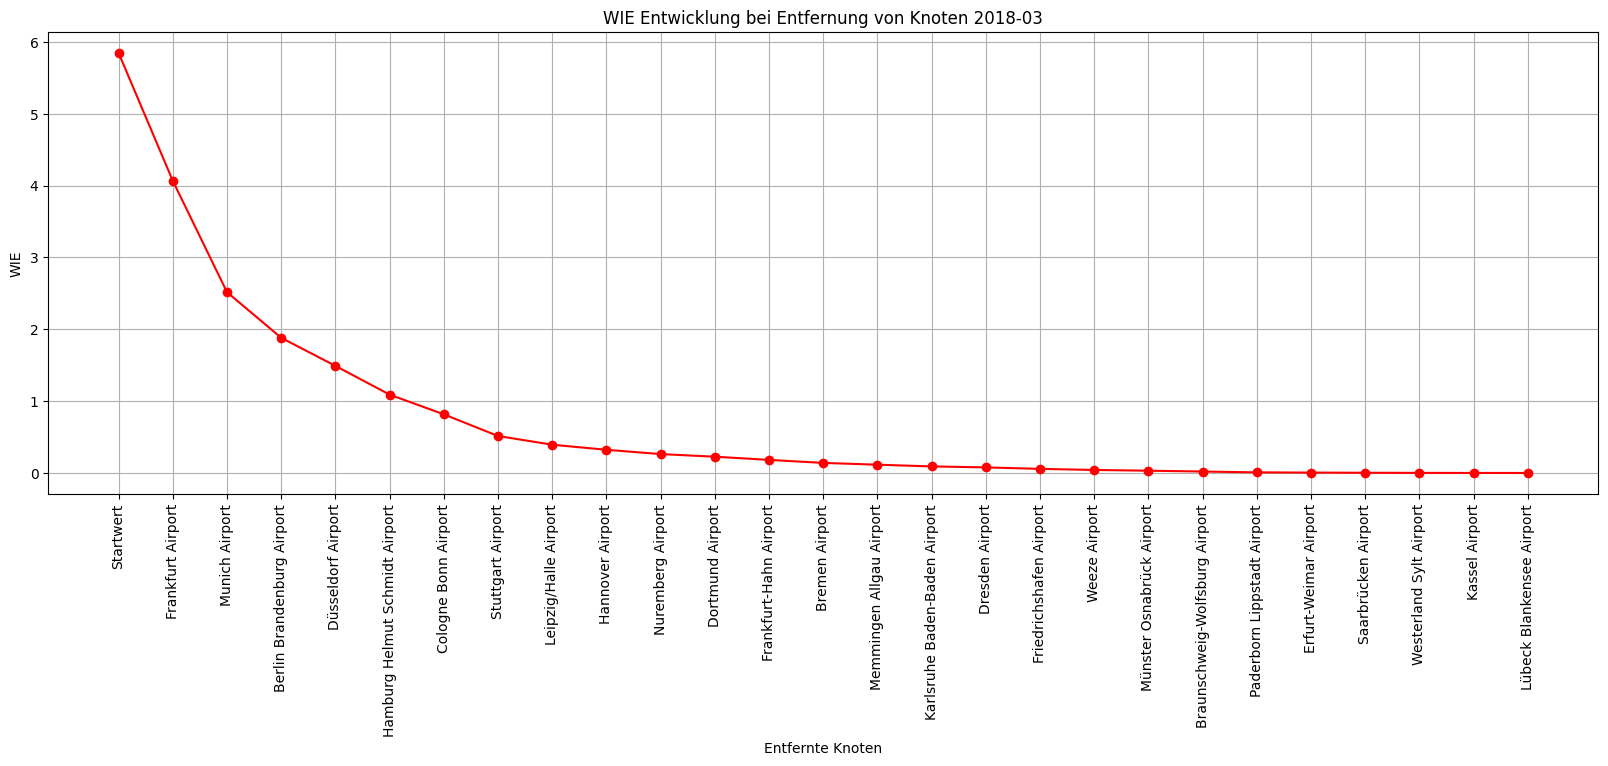

/content/drive/My Drive/2024KomplexeNetze/Daten/2018-04-01_2018-07-01_deutschland_v2.csv
Number of nodes (airports): 707
Number of edges (flight routes): 4462, sum of weights (flights) 55162.0
Found 989 international airports to check against
Number of edges (domestic flight routes): 1348, sum of weights (domestic flights) 16692.0
Number of edges (international flight routes): 3114, sum of weights (international flights) 38470.0
WIE_post has become zero.
International robustness for 2018-04: 0.6792967360695976


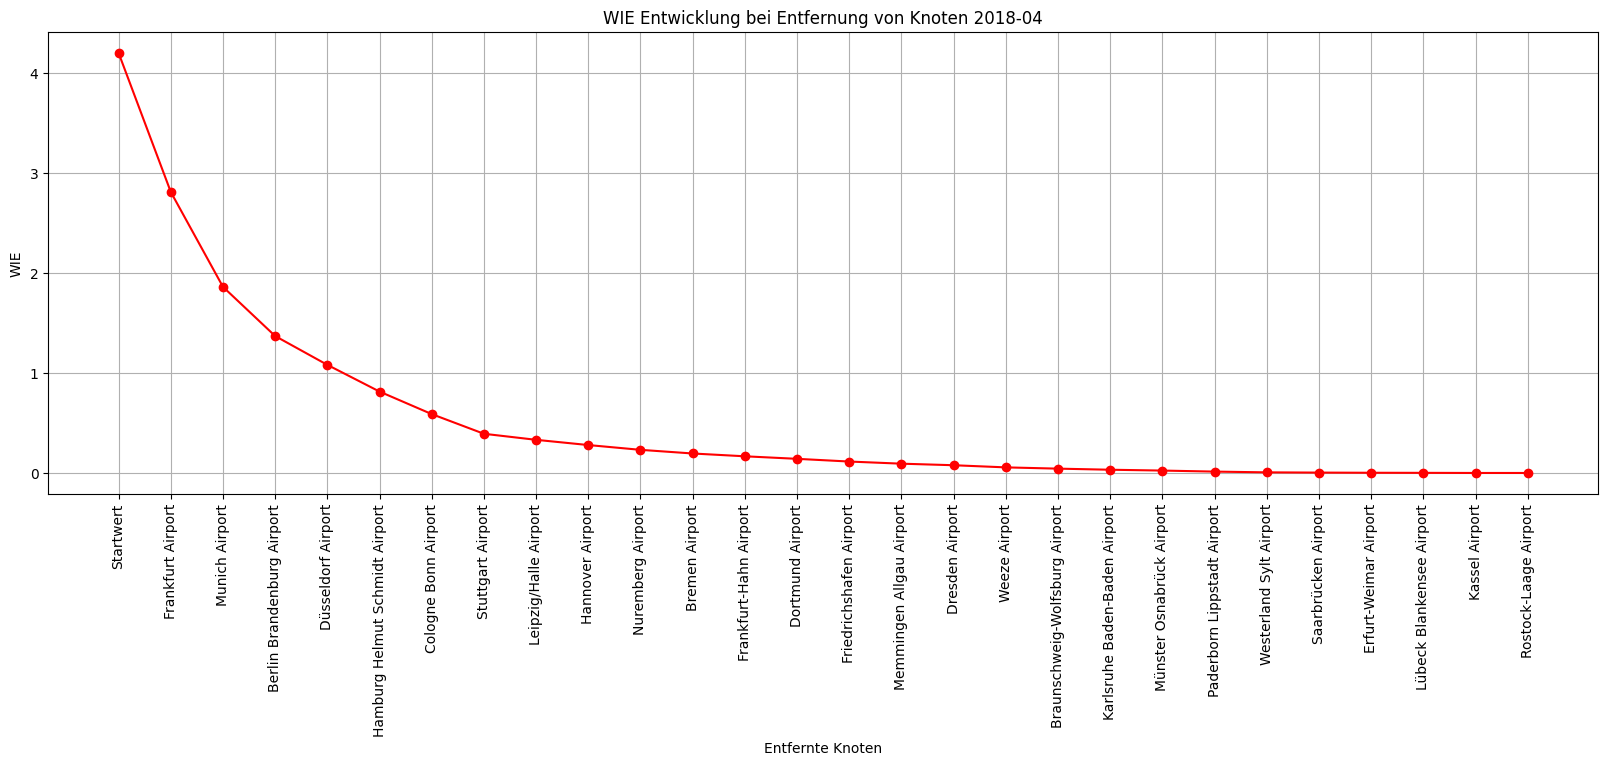

Number of nodes (airports): 890
Number of edges (flight routes): 5213, sum of weights (flights) 59806.0
Found 989 international airports to check against
Number of edges (domestic flight routes): 1602, sum of weights (domestic flights) 17323.0
Number of edges (international flight routes): 3611, sum of weights (international flights) 42483.0
WIE_post has become zero.
International robustness for 2018-05: 0.6763067000217639


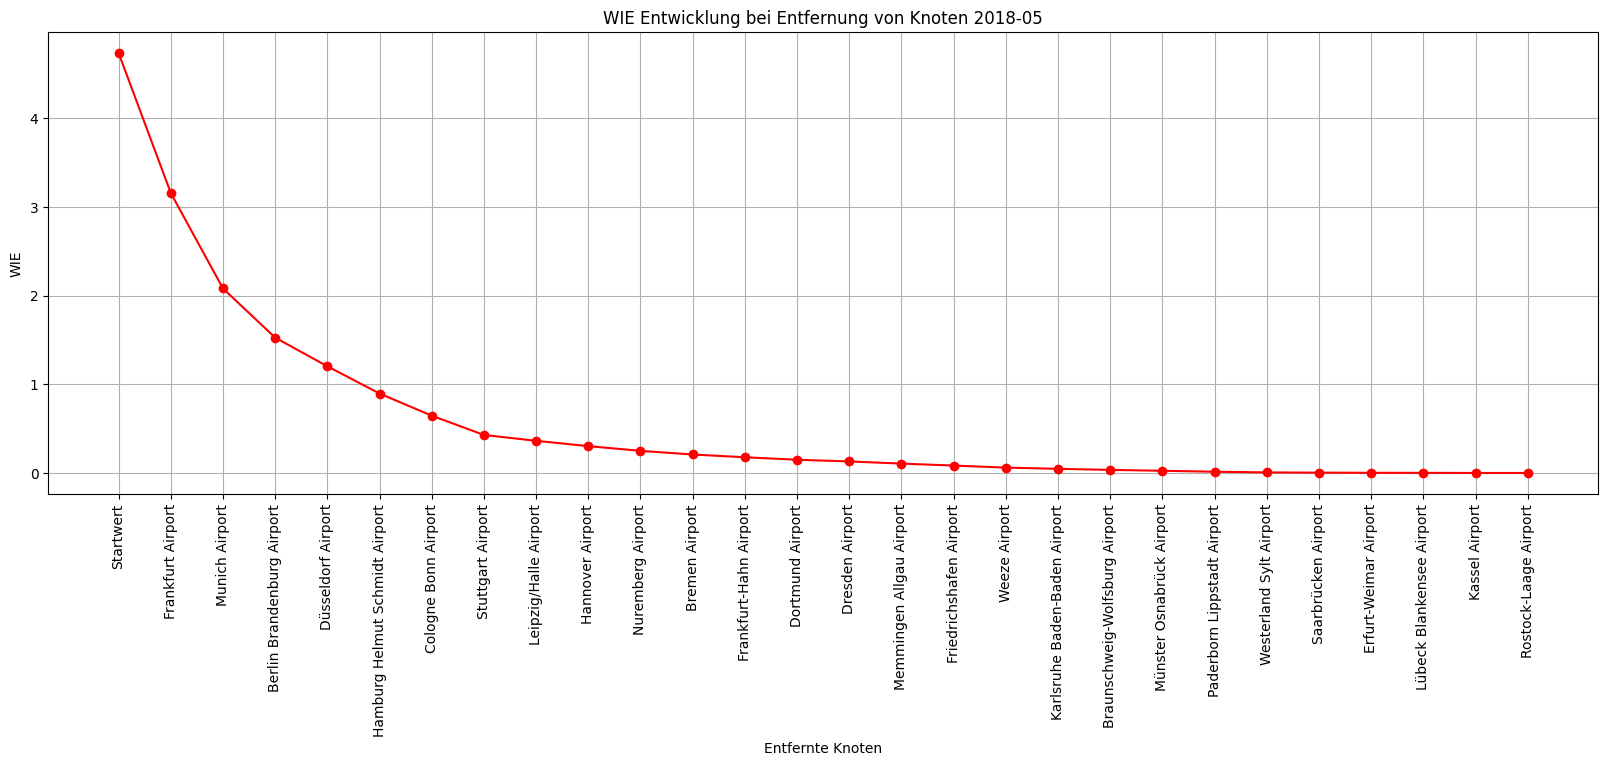

Number of nodes (airports): 1006
Number of edges (flight routes): 5260, sum of weights (flights) 59808.0
Found 989 international airports to check against
Number of edges (domestic flight routes): 1606, sum of weights (domestic flights) 17334.0
Number of edges (international flight routes): 3654, sum of weights (international flights) 42474.0
WIE_post has become zero.
International robustness for 2018-06: 0.6699425356316047


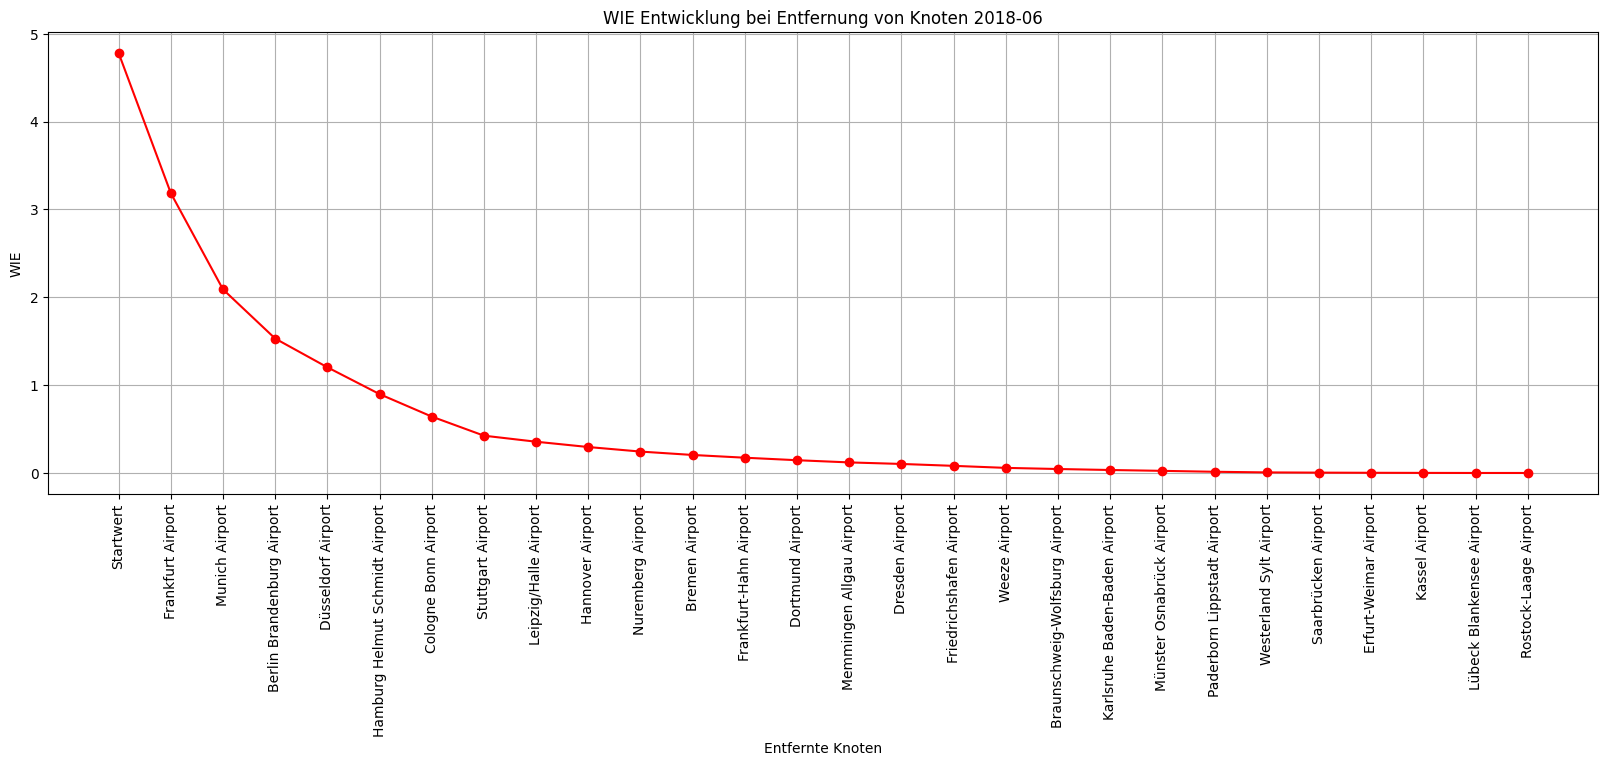

/content/drive/My Drive/2024KomplexeNetze/Daten/2018-07-01_2018-10-01_deutschland_v2.csv
Number of nodes (airports): 997
Number of edges (flight routes): 5344, sum of weights (flights) 57994.0
Found 1061 international airports to check against
Number of edges (domestic flight routes): 1612, sum of weights (domestic flights) 17857.0
Number of edges (international flight routes): 3732, sum of weights (international flights) 40137.0
WIE_post has become zero.
International robustness for 2018-07: 0.6871164194536499


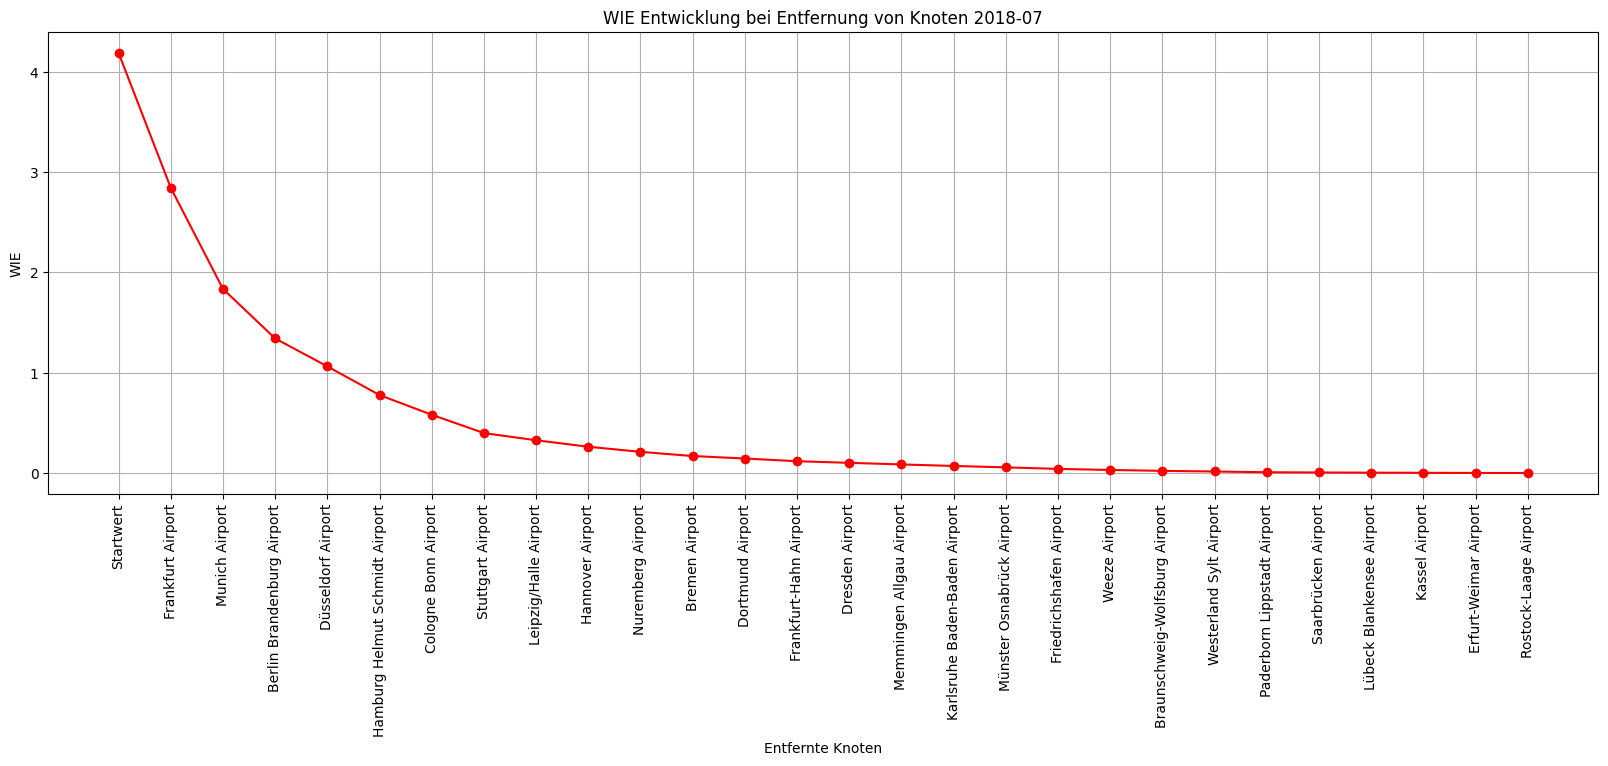

Number of nodes (airports): 1001
Number of edges (flight routes): 5386, sum of weights (flights) 58447.0
Found 1061 international airports to check against
Number of edges (domestic flight routes): 1620, sum of weights (domestic flights) 17894.0
Number of edges (international flight routes): 3766, sum of weights (international flights) 40553.0
WIE_post has become zero.
International robustness for 2018-08: 0.6801561886303115


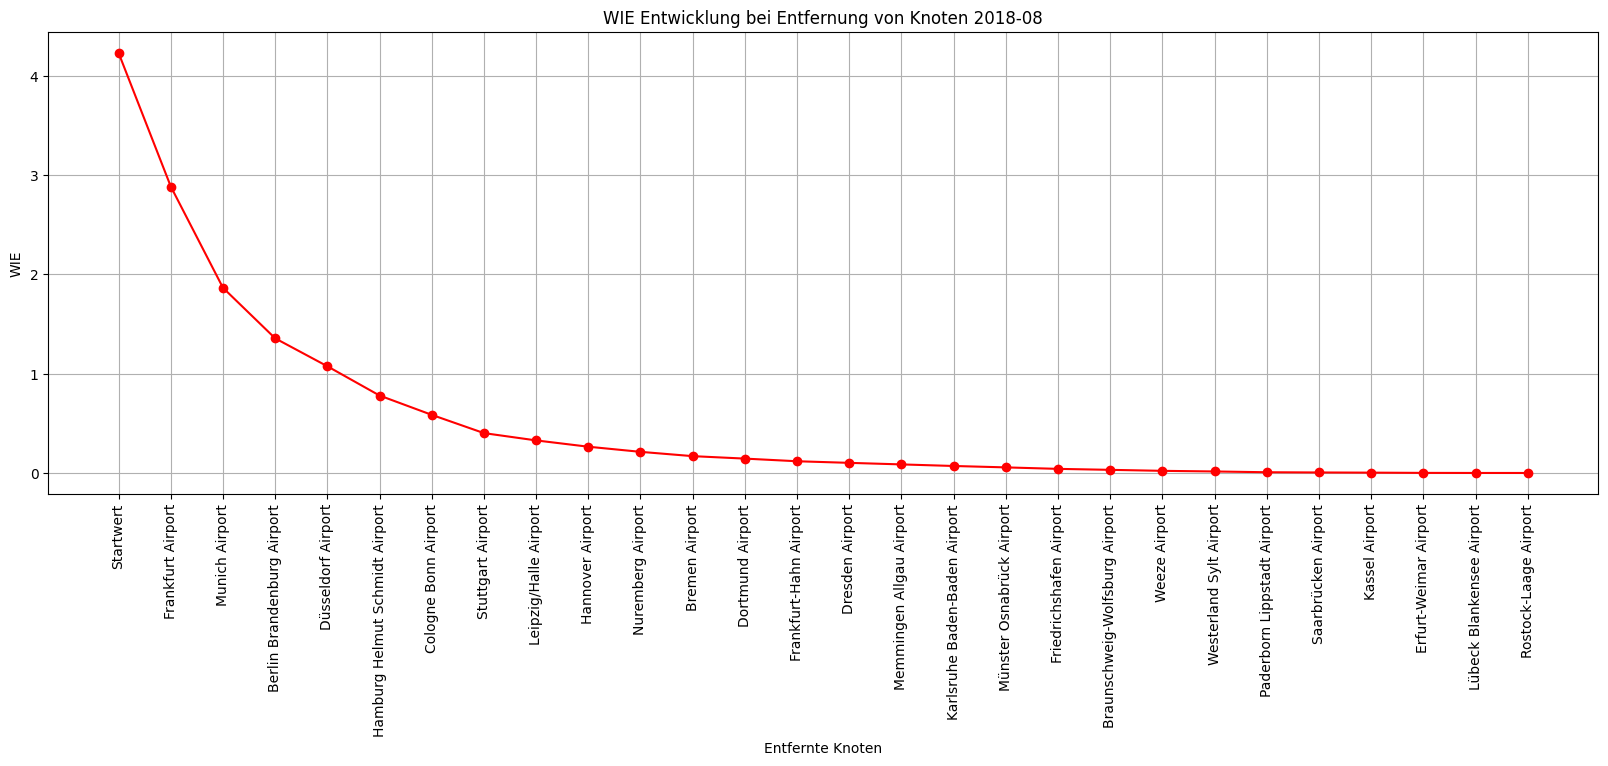

Number of nodes (airports): 977
Number of edges (flight routes): 5283, sum of weights (flights) 58069.0
Found 1061 international airports to check against
Number of edges (domestic flight routes): 1602, sum of weights (domestic flights) 17887.0
Number of edges (international flight routes): 3681, sum of weights (international flights) 40182.0
WIE_post has become zero.
International robustness for 2018-09: 0.6867037263741951


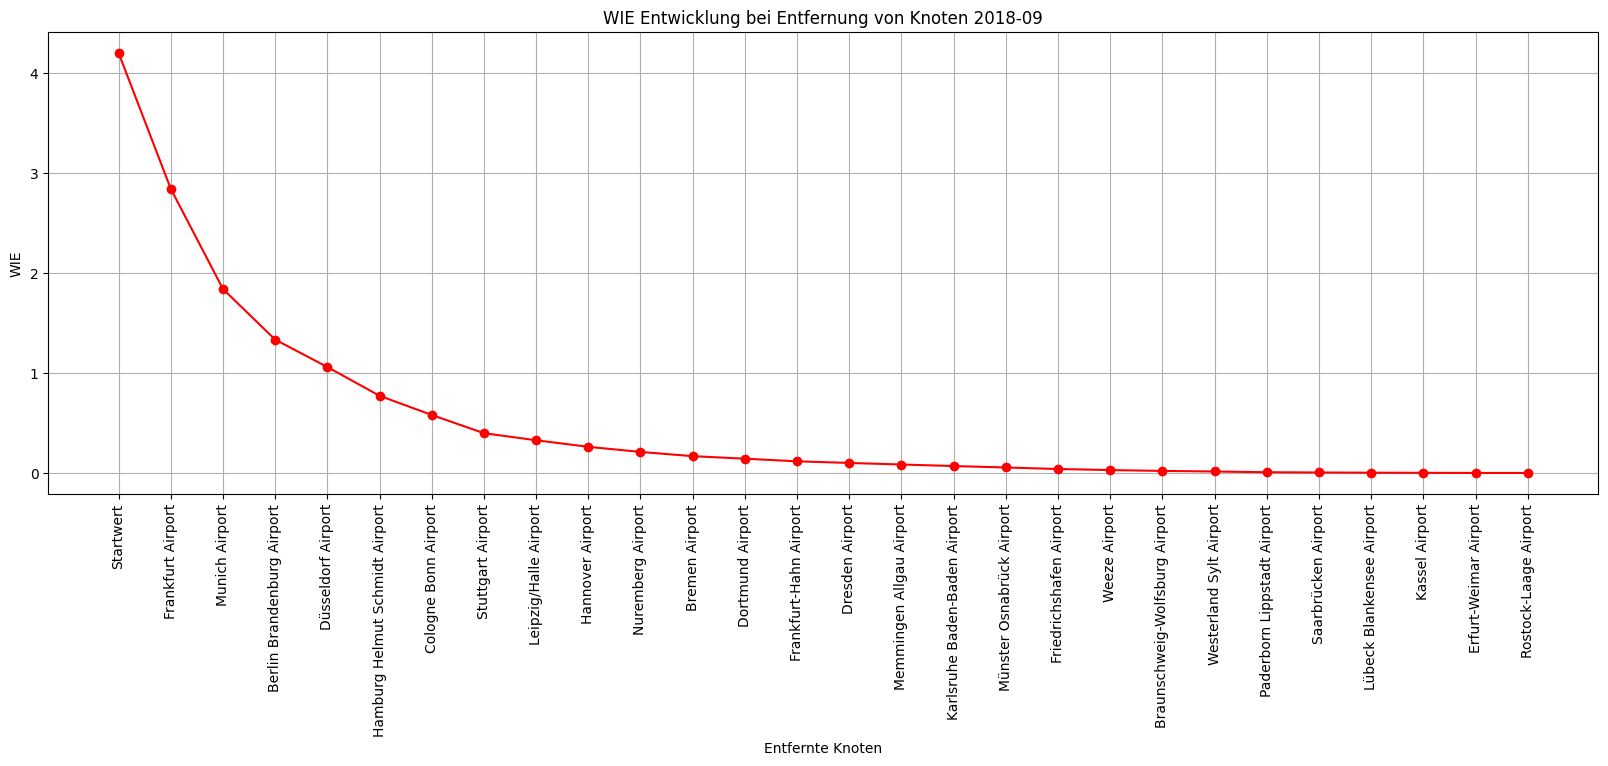

/content/drive/My Drive/2024KomplexeNetze/Daten/2018-10-01_2019-01-01_deutschland_v2.csv
Number of nodes (airports): 964
Number of edges (flight routes): 4990, sum of weights (flights) 55461.0
Found 991 international airports to check against
Number of edges (domestic flight routes): 1498, sum of weights (domestic flights) 17569.0
Number of edges (international flight routes): 3492, sum of weights (international flights) 37892.0
WIE_post has become zero.
International robustness for 2018-10: 0.6735056892536657


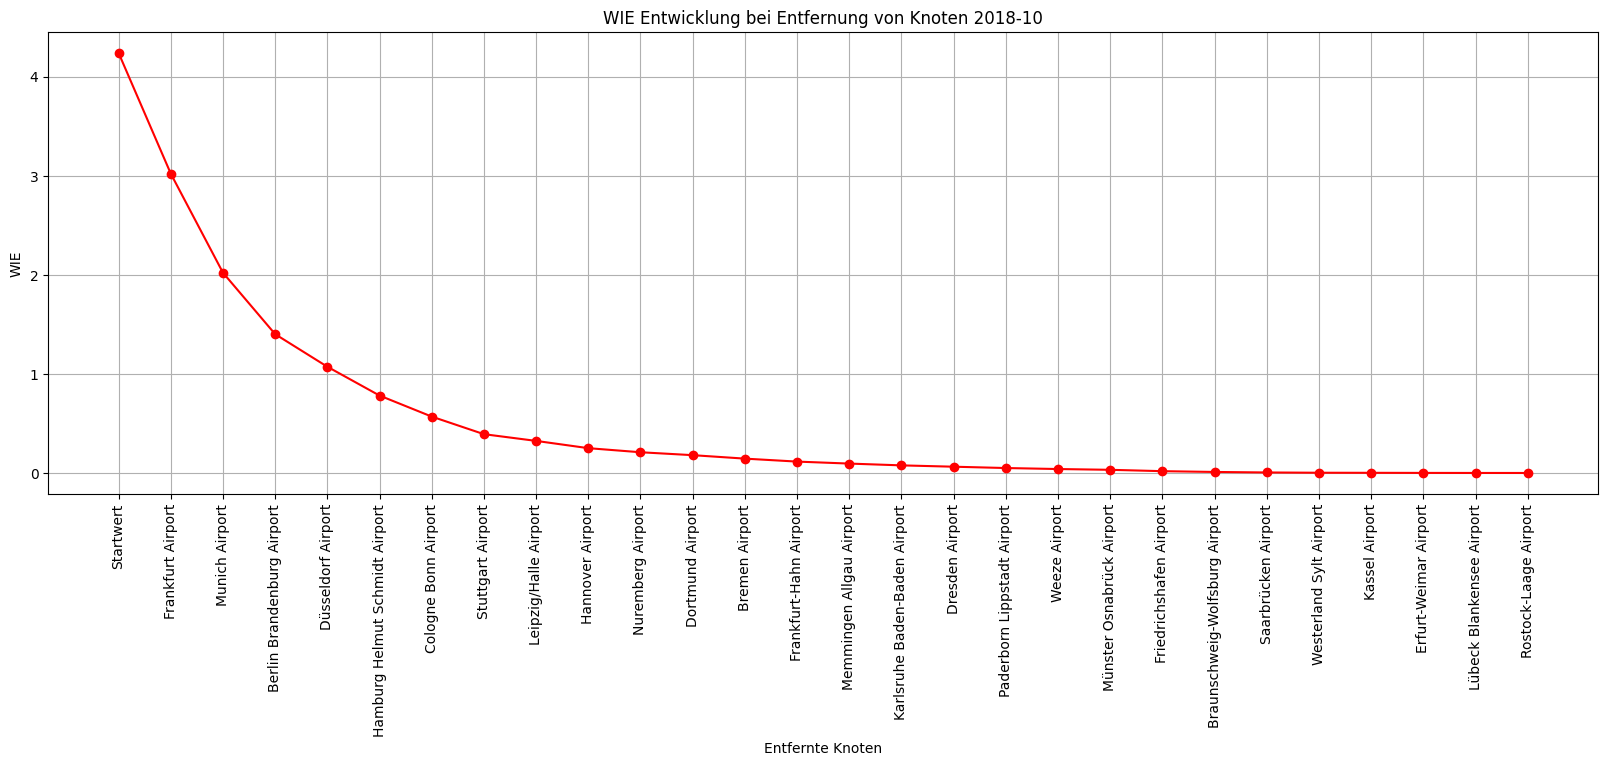

Number of nodes (airports): 819
Number of edges (flight routes): 4686, sum of weights (flights) 54915.0
Found 991 international airports to check against
Number of edges (domestic flight routes): 1421, sum of weights (domestic flights) 17466.0
Number of edges (international flight routes): 3265, sum of weights (international flights) 37449.0
WIE_post has become zero.
International robustness for 2018-11: 0.6666438672007197


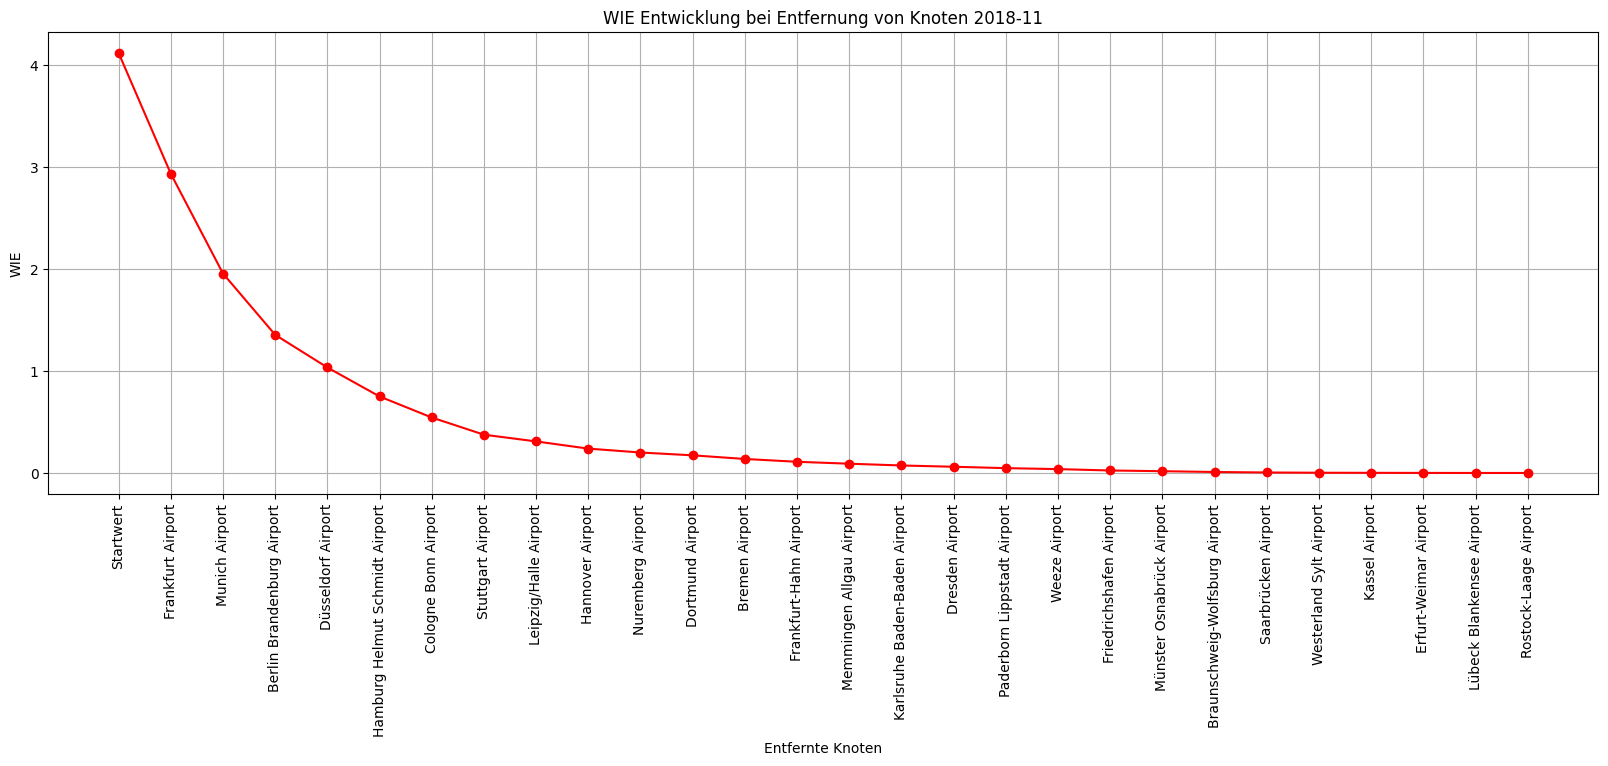

Number of nodes (airports): 777
Number of edges (flight routes): 4597, sum of weights (flights) 54820.0
Found 991 international airports to check against
Number of edges (domestic flight routes): 1313, sum of weights (domestic flights) 17338.0
Number of edges (international flight routes): 3284, sum of weights (international flights) 37482.0
WIE_post has become zero.
International robustness for 2018-12: 0.6661950483695235


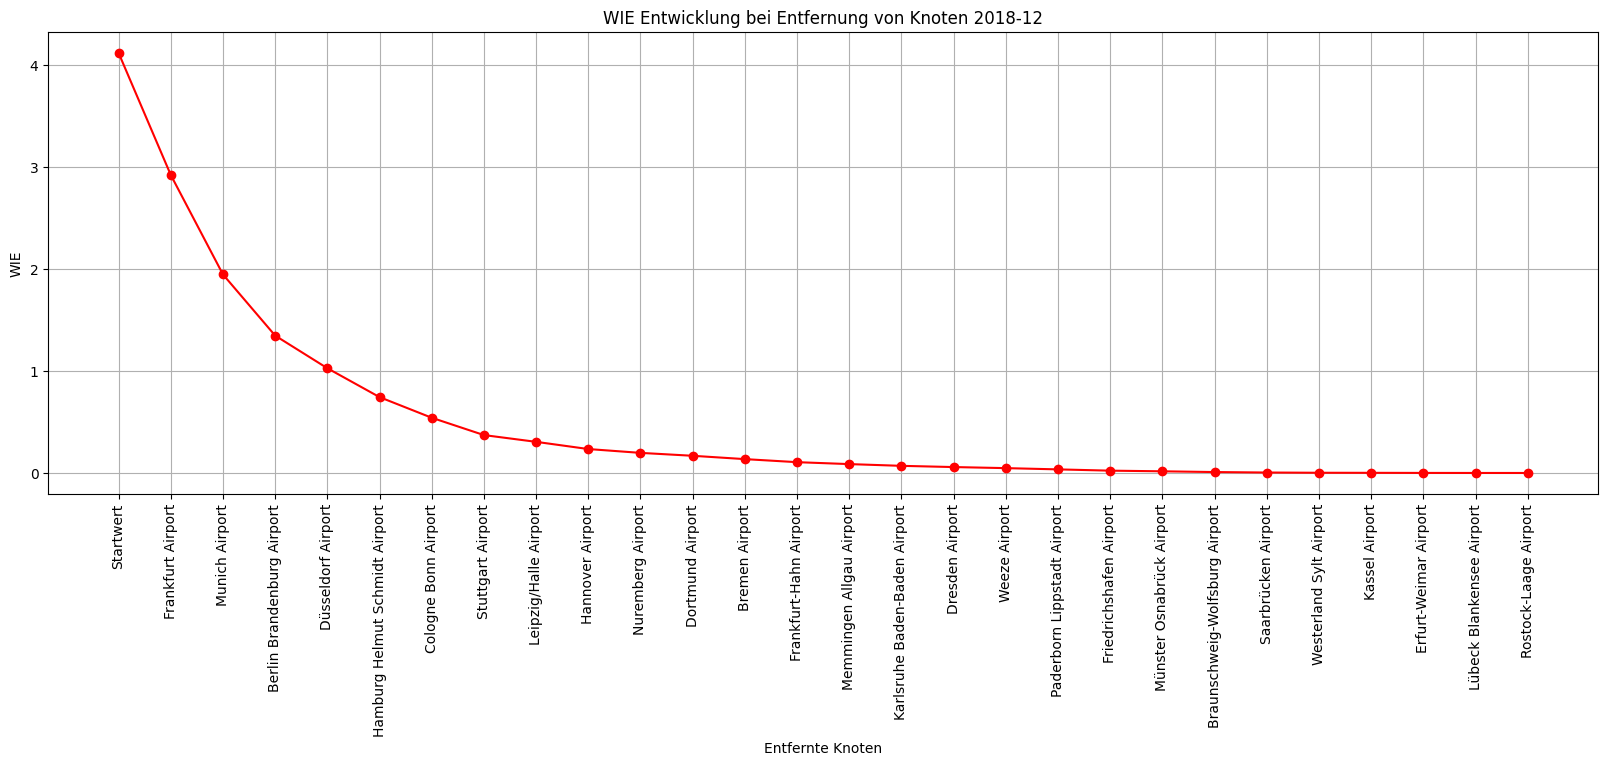

/content/drive/My Drive/2024KomplexeNetze/Daten/2019-01-01_2019-04-01_deutschland_v2.csv
Number of nodes (airports): 821
Number of edges (flight routes): 4431, sum of weights (flights) 61483.0
Found 957 international airports to check against
Number of edges (domestic flight routes): 1339, sum of weights (domestic flights) 20716.0
Number of edges (international flight routes): 3092, sum of weights (international flights) 40767.0
WIE_post has become zero.
International robustness for 2019-01: 0.6836099437755484


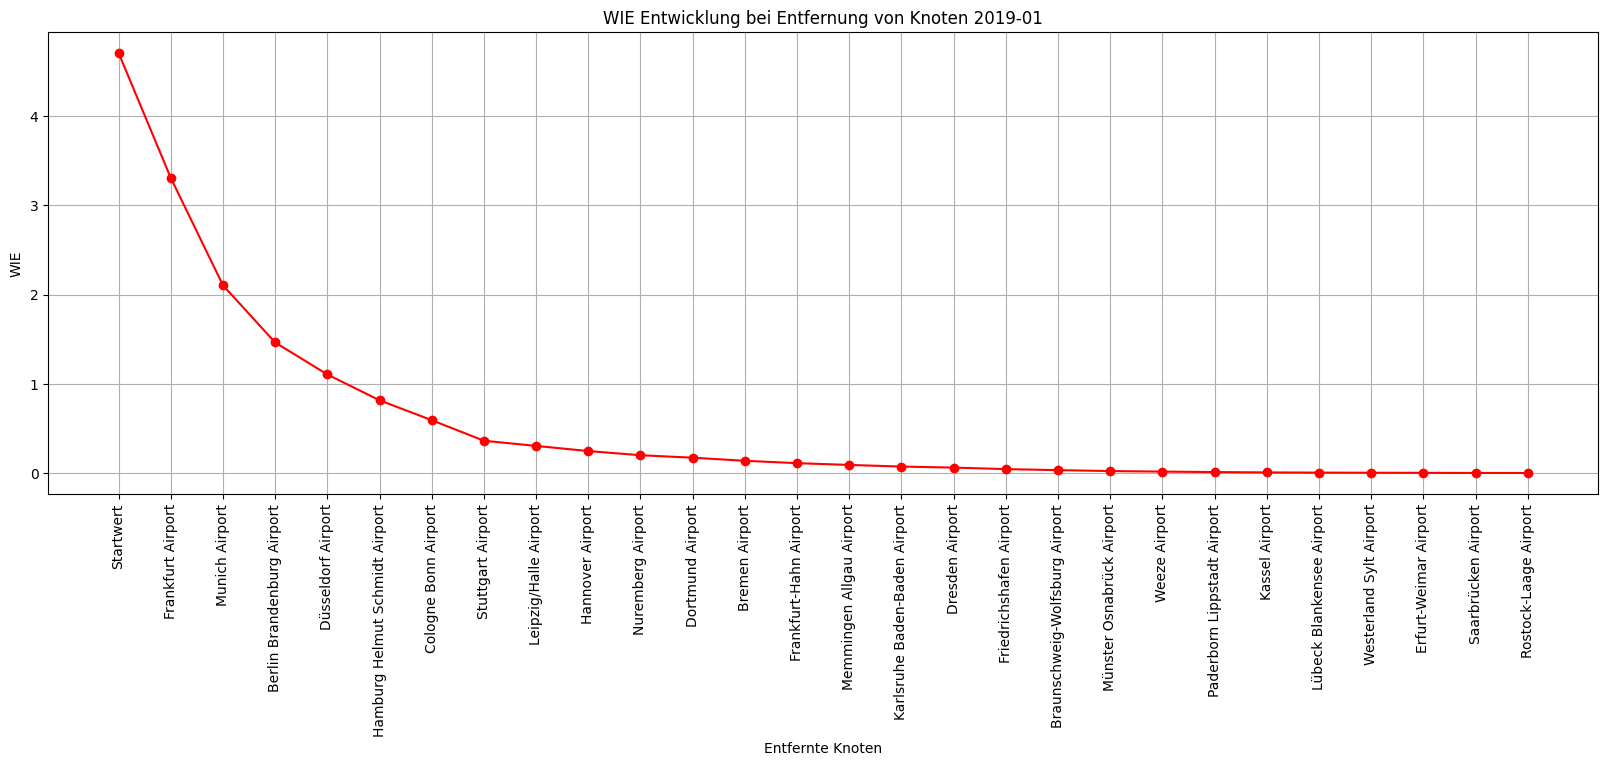

Number of nodes (airports): 856
Number of edges (flight routes): 4493, sum of weights (flights) 61525.0
Found 957 international airports to check against
Number of edges (domestic flight routes): 1367, sum of weights (domestic flights) 20752.0
Number of edges (international flight routes): 3126, sum of weights (international flights) 40773.0
WIE_post has become zero.
International robustness for 2019-02: 0.6807190998028572


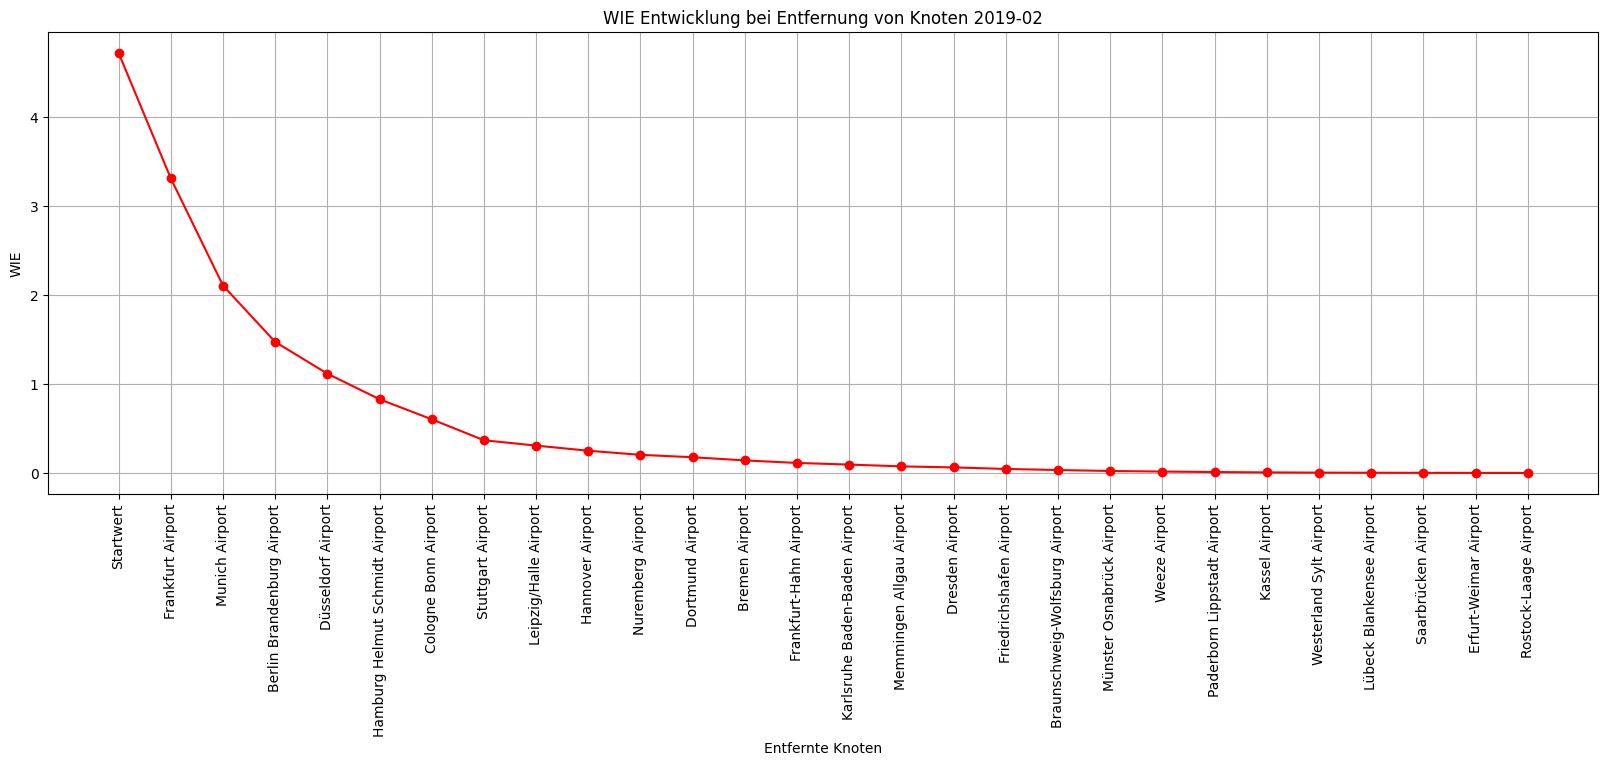

Number of nodes (airports): 822
Number of edges (flight routes): 4433, sum of weights (flights) 61725.0
Found 957 international airports to check against
Number of edges (domestic flight routes): 1364, sum of weights (domestic flights) 20761.0
Number of edges (international flight routes): 3069, sum of weights (international flights) 40964.0
WIE_post has become zero.
International robustness for 2019-03: 0.6816906865944069


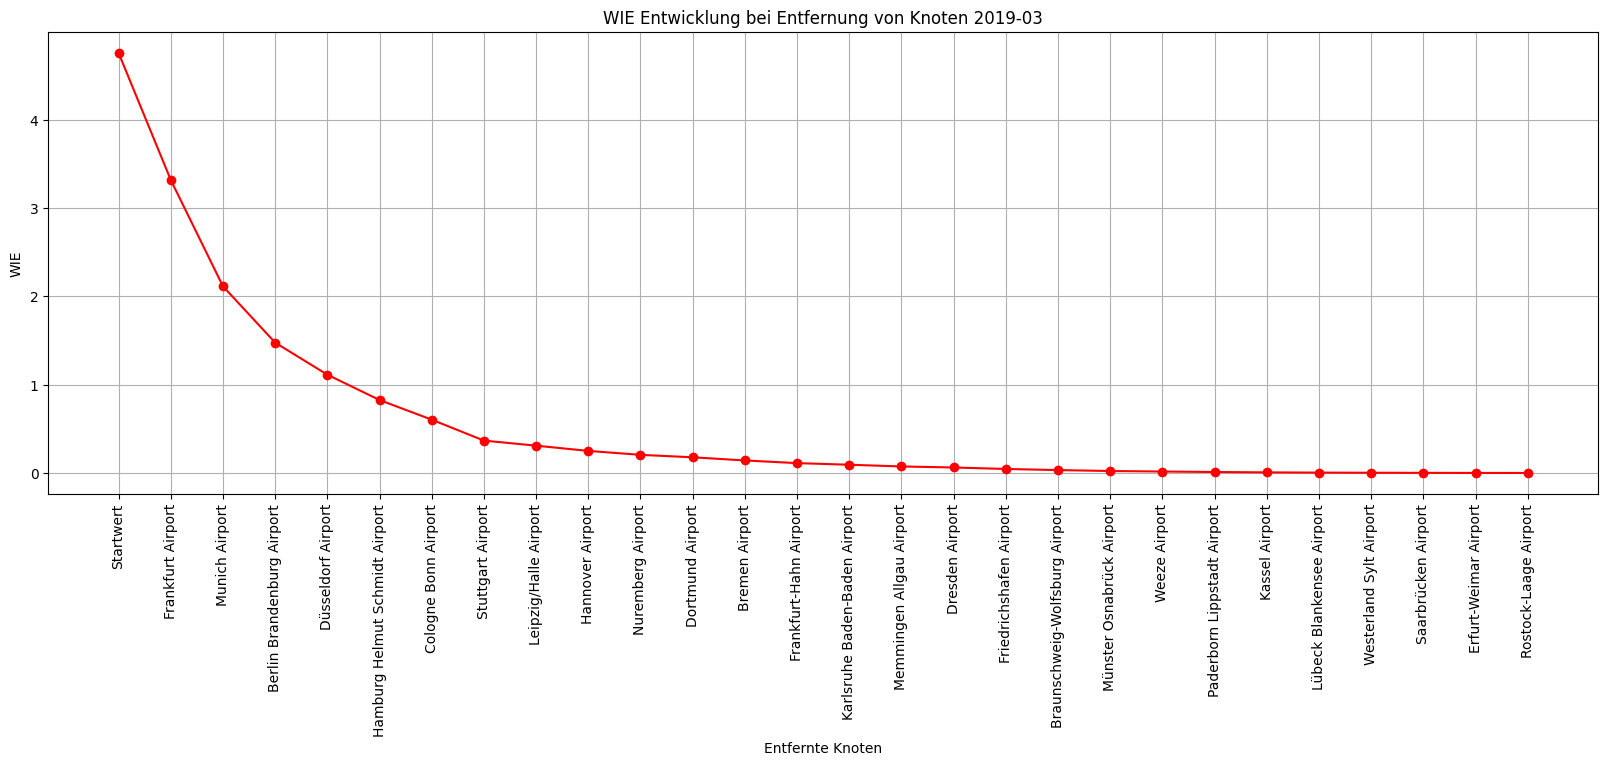

/content/drive/My Drive/2024KomplexeNetze/Daten/2019-04-01_2019-07-01_deutschland_v2.csv
Number of nodes (airports): 934
Number of edges (flight routes): 5467, sum of weights (flights) 65711.0
Found 1065 international airports to check against
Number of edges (domestic flight routes): 1742, sum of weights (domestic flights) 19296.0
Number of edges (international flight routes): 3725, sum of weights (international flights) 46415.0
WIE_post has become zero.
International robustness for 2019-04: 0.7064676781632514


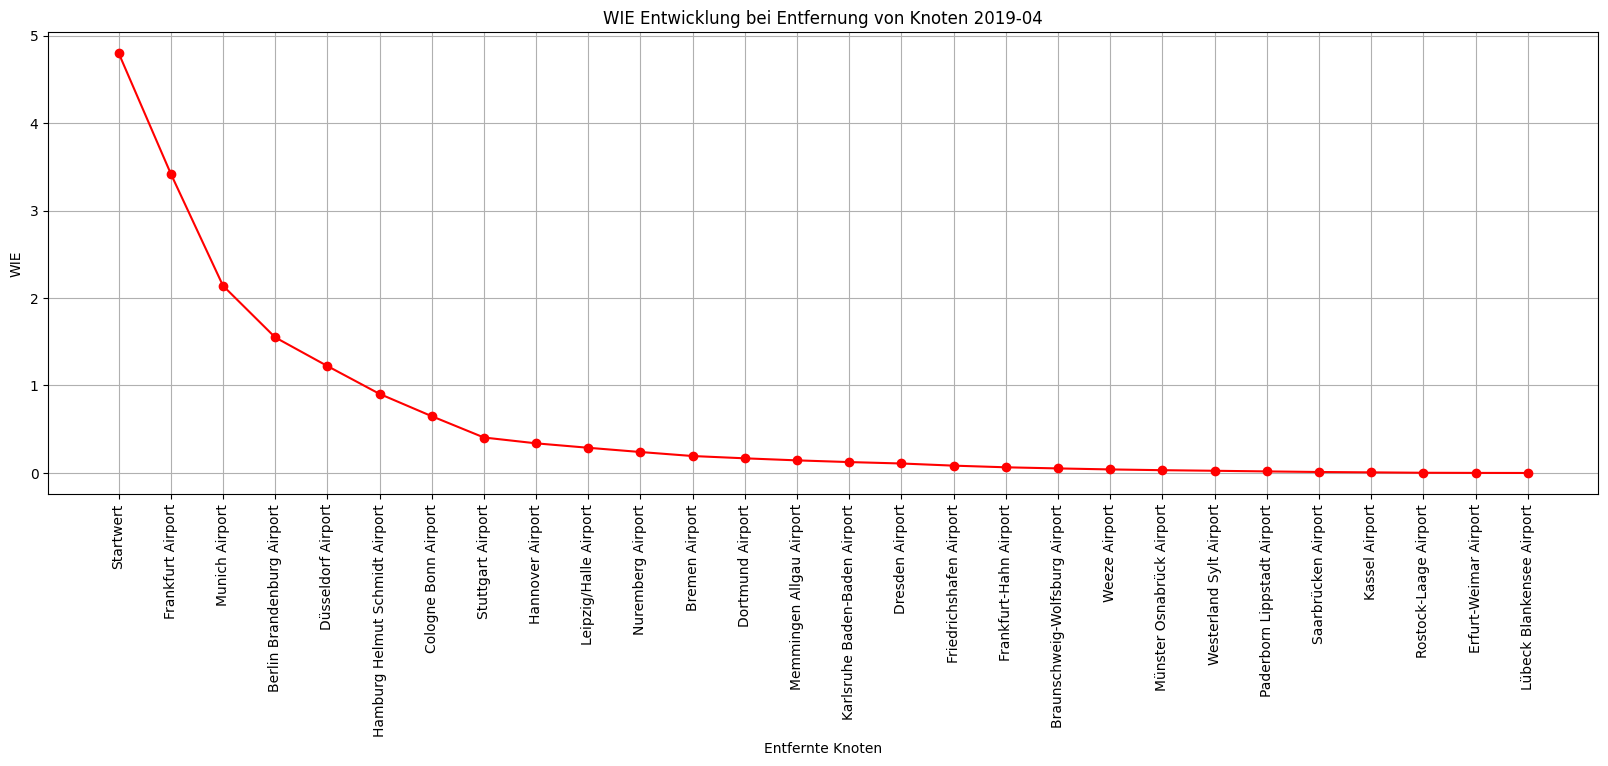

Number of nodes (airports): 997
Number of edges (flight routes): 5646, sum of weights (flights) 66620.0
Found 1065 international airports to check against
Number of edges (domestic flight routes): 1784, sum of weights (domestic flights) 19346.0
Number of edges (international flight routes): 3862, sum of weights (international flights) 47274.0
WIE_post has become zero.
International robustness for 2019-05: 0.7080128972904903


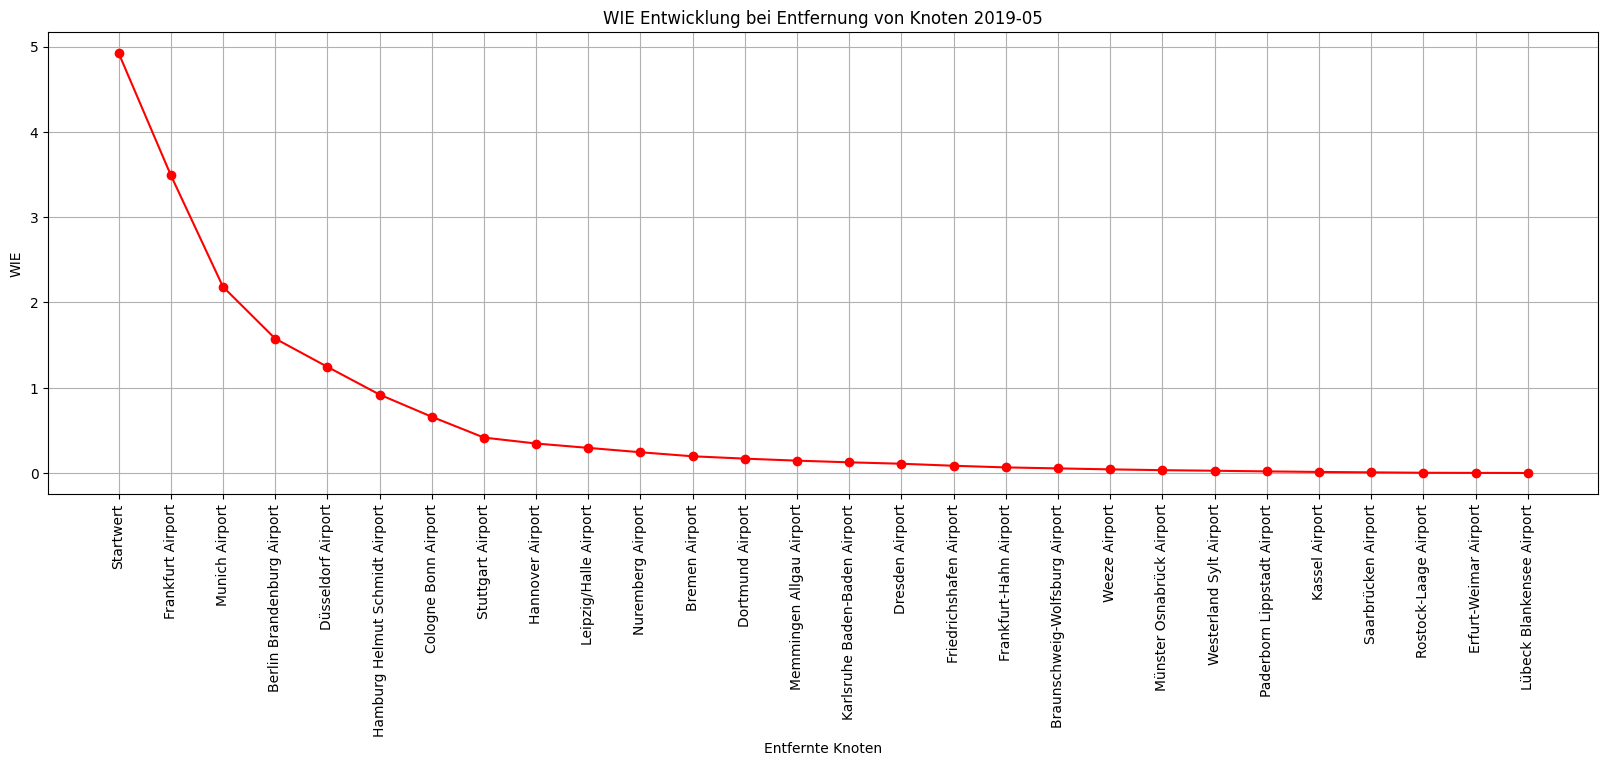

Number of nodes (airports): 1056
Number of edges (flight routes): 5720, sum of weights (flights) 66643.0
Found 1065 international airports to check against
Number of edges (domestic flight routes): 1811, sum of weights (domestic flights) 19388.0
Number of edges (international flight routes): 3909, sum of weights (international flights) 47255.0
WIE_post has become zero.
International robustness for 2019-06: 0.7176302296418956


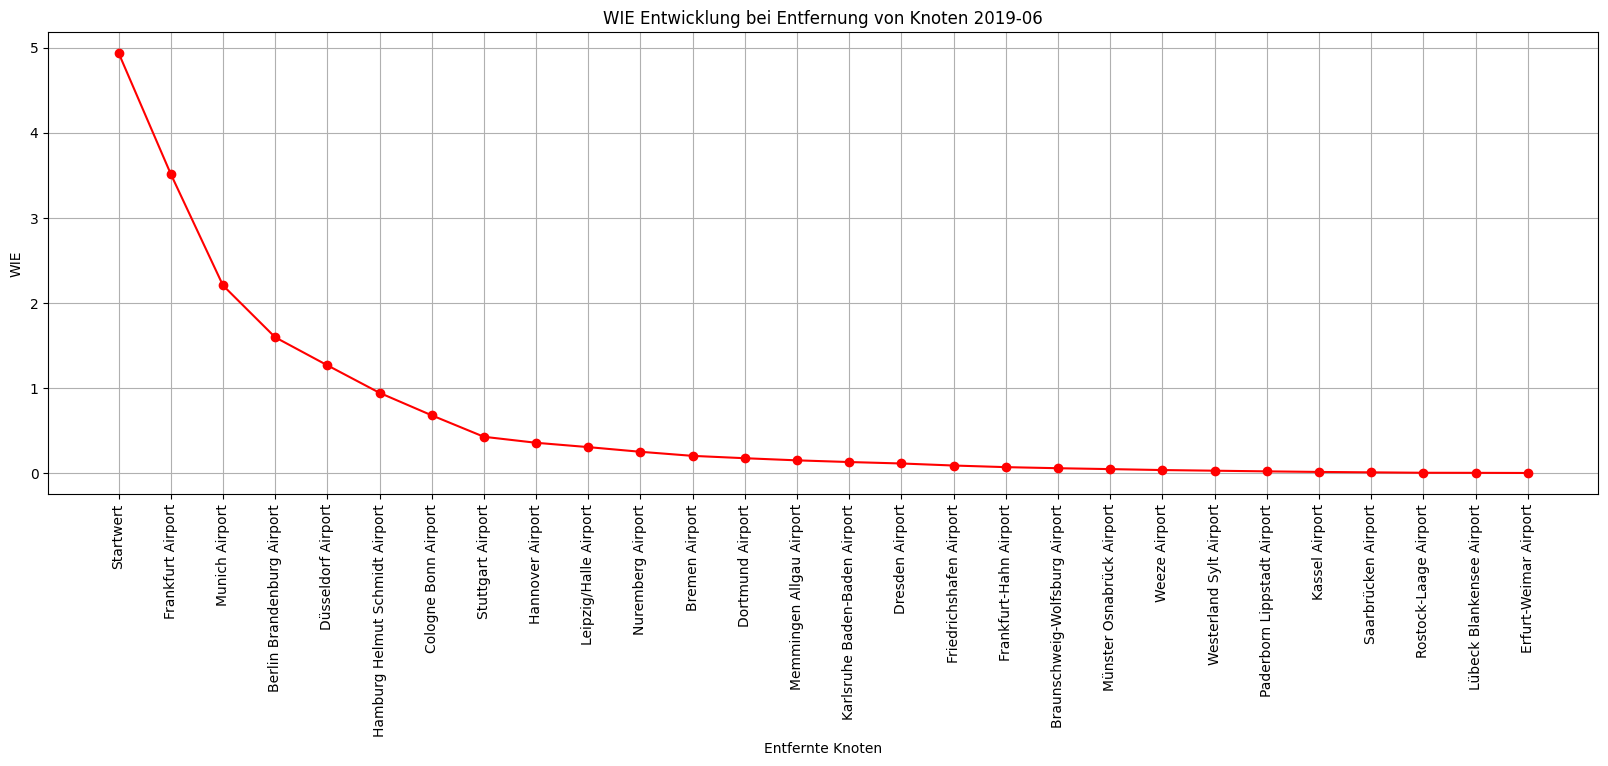

/content/drive/My Drive/2024KomplexeNetze/Daten/2019-07-01_2019-10-01_deutschland_v2.csv
Number of nodes (airports): 1037
Number of edges (flight routes): 5573, sum of weights (flights) 73245.0
Found 1053 international airports to check against
Number of edges (domestic flight routes): 1805, sum of weights (domestic flights) 21766.0
Number of edges (international flight routes): 3768, sum of weights (international flights) 51479.0
WIE_post has become zero.
International robustness for 2019-07: 0.6964086803570055


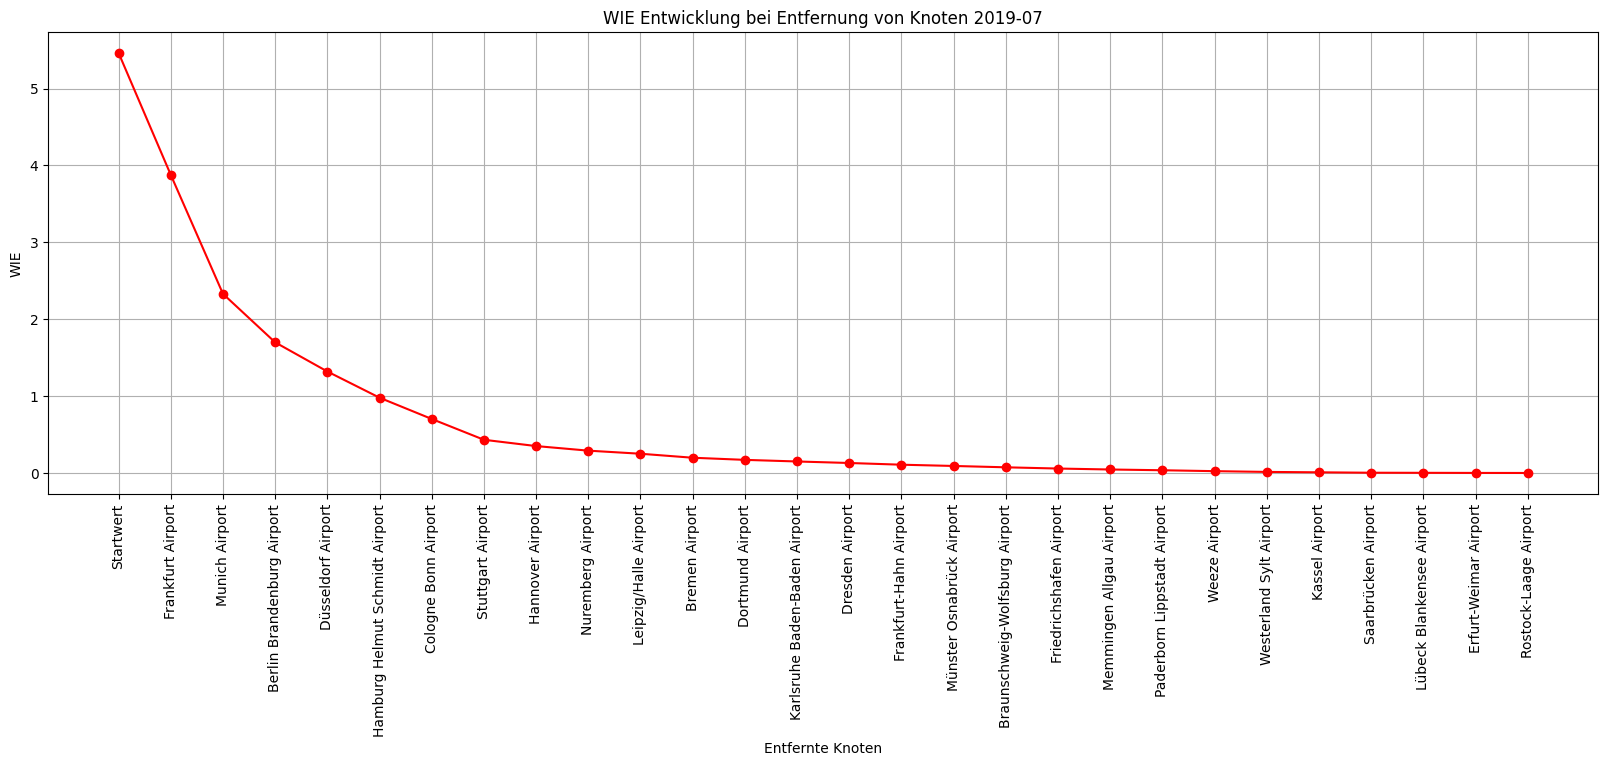

Number of nodes (airports): 992
Number of edges (flight routes): 5517, sum of weights (flights) 73460.0
Found 1053 international airports to check against
Number of edges (domestic flight routes): 1812, sum of weights (domestic flights) 21772.0
Number of edges (international flight routes): 3705, sum of weights (international flights) 51688.0
WIE_post has become zero.
International robustness for 2019-08: 0.6958866359251423


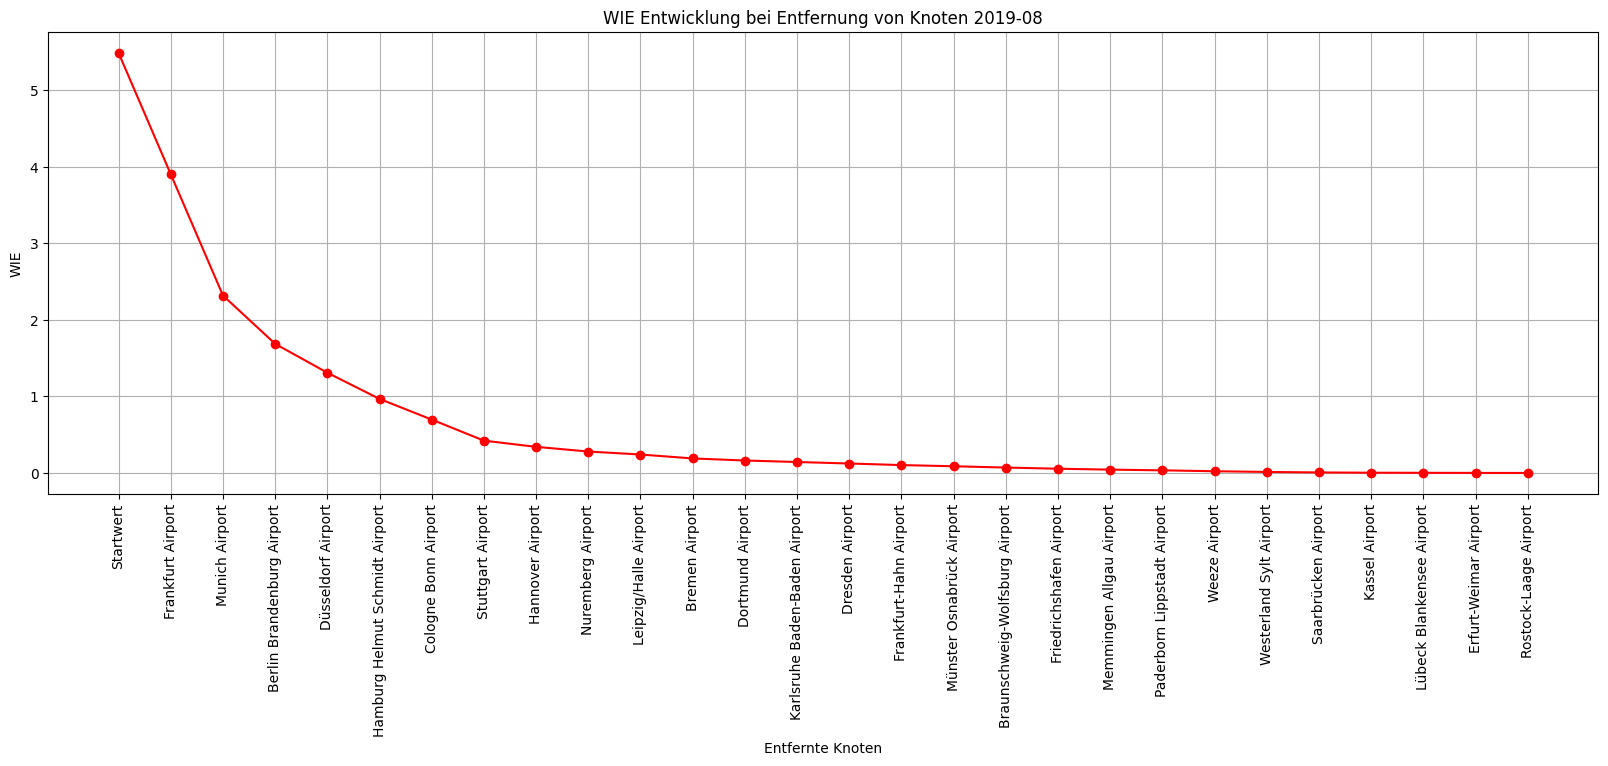

Number of nodes (airports): 1013
Number of edges (flight routes): 5582, sum of weights (flights) 73582.0
Found 1053 international airports to check against
Number of edges (domestic flight routes): 1784, sum of weights (domestic flights) 21725.0
Number of edges (international flight routes): 3798, sum of weights (international flights) 51857.0
WIE_post has become zero.
International robustness for 2019-09: 0.6954146183991261


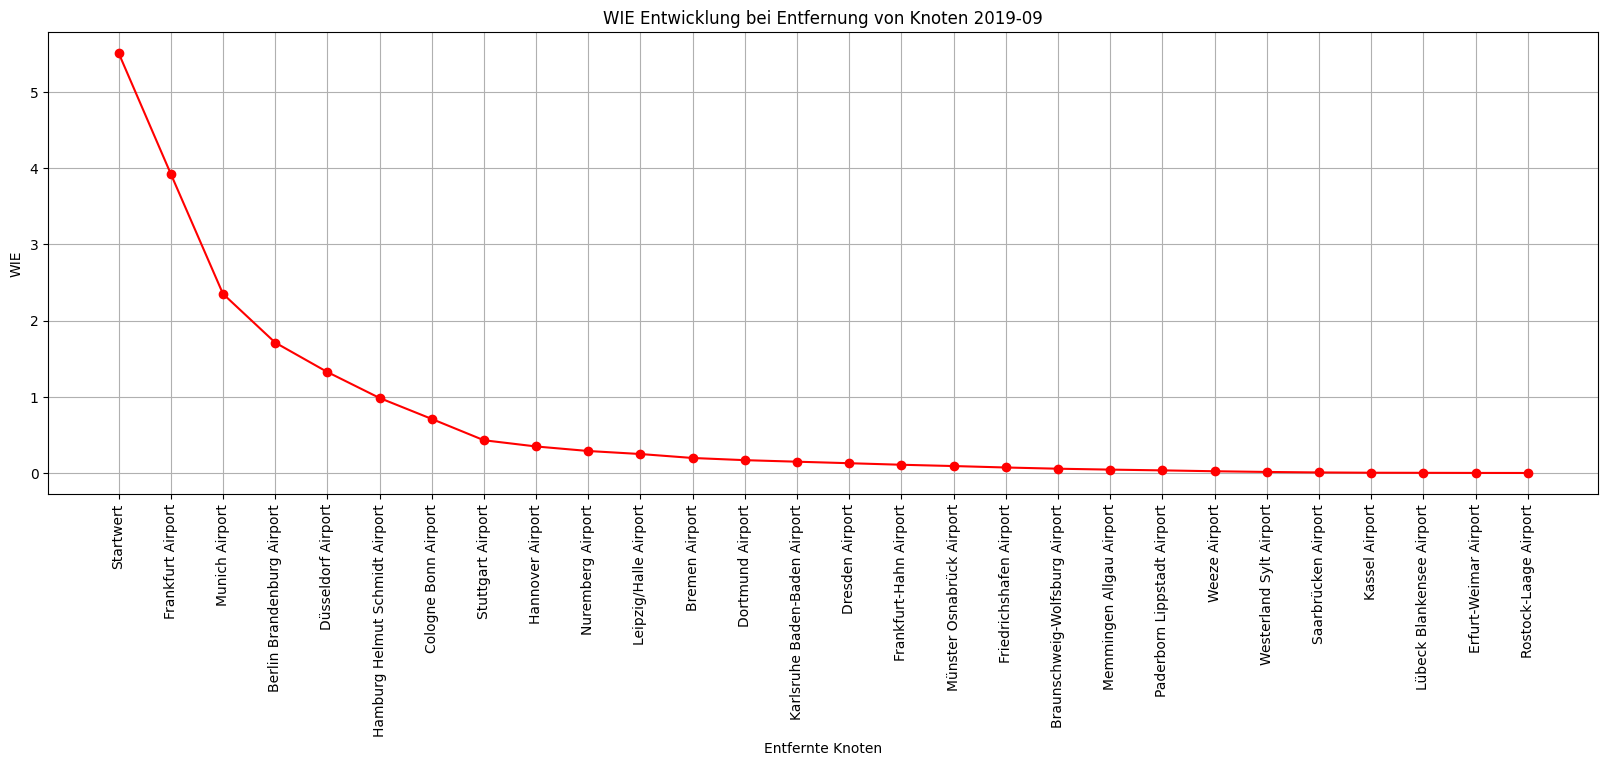

/content/drive/My Drive/2024KomplexeNetze/Daten/2019-10-01_2020-01-01_deutschland_v2.csv
Number of nodes (airports): 943
Number of edges (flight routes): 5237, sum of weights (flights) 64030.0
Found 925 international airports to check against
Number of edges (domestic flight routes): 1608, sum of weights (domestic flights) 19376.0
Number of edges (international flight routes): 3629, sum of weights (international flights) 44654.0
WIE_post has become zero.
International robustness for 2019-10: 0.7006215893930289


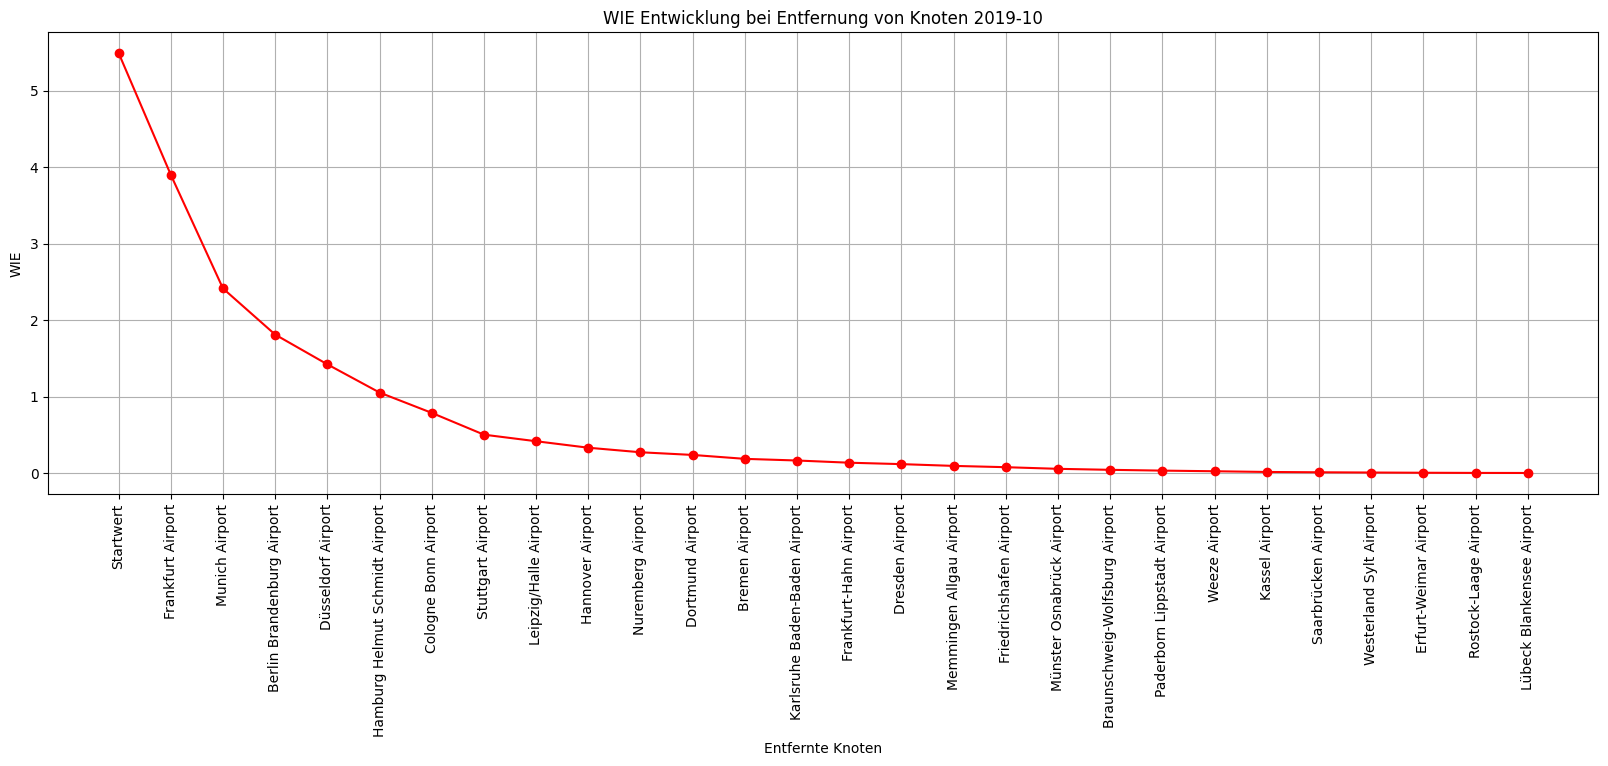

Number of nodes (airports): 819
Number of edges (flight routes): 4988, sum of weights (flights) 63470.0
Found 925 international airports to check against
Number of edges (domestic flight routes): 1516, sum of weights (domestic flights) 19257.0
Number of edges (international flight routes): 3472, sum of weights (international flights) 44213.0
WIE_post has become zero.
International robustness for 2019-11: 0.7008039738075073


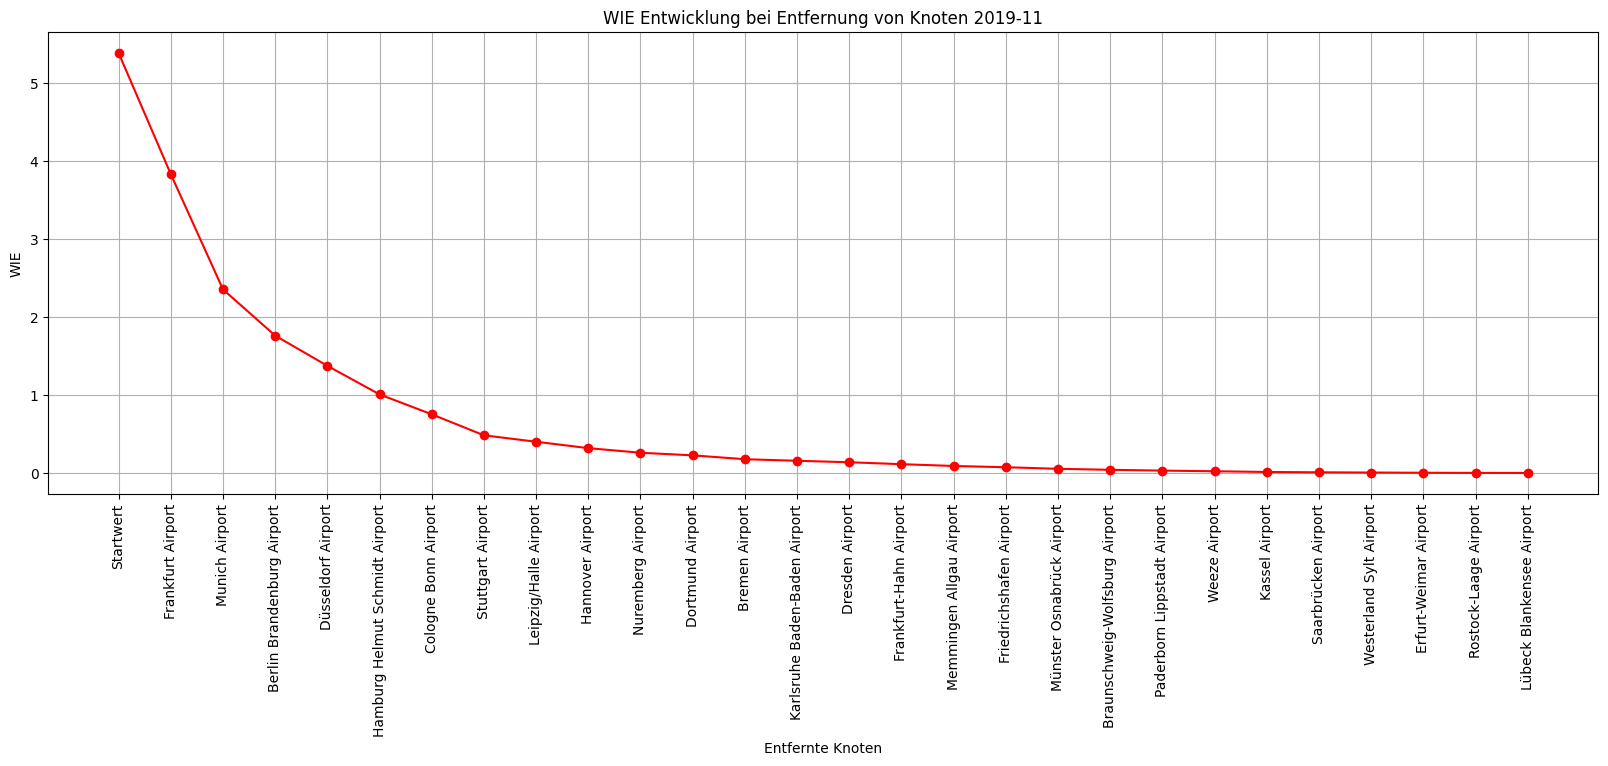

Number of nodes (airports): 847
Number of edges (flight routes): 4994, sum of weights (flights) 63380.0
Found 925 international airports to check against
Number of edges (domestic flight routes): 1567, sum of weights (domestic flights) 19339.0
Number of edges (international flight routes): 3427, sum of weights (international flights) 44041.0
WIE_post has become zero.
International robustness for 2019-12: 0.700632732386734


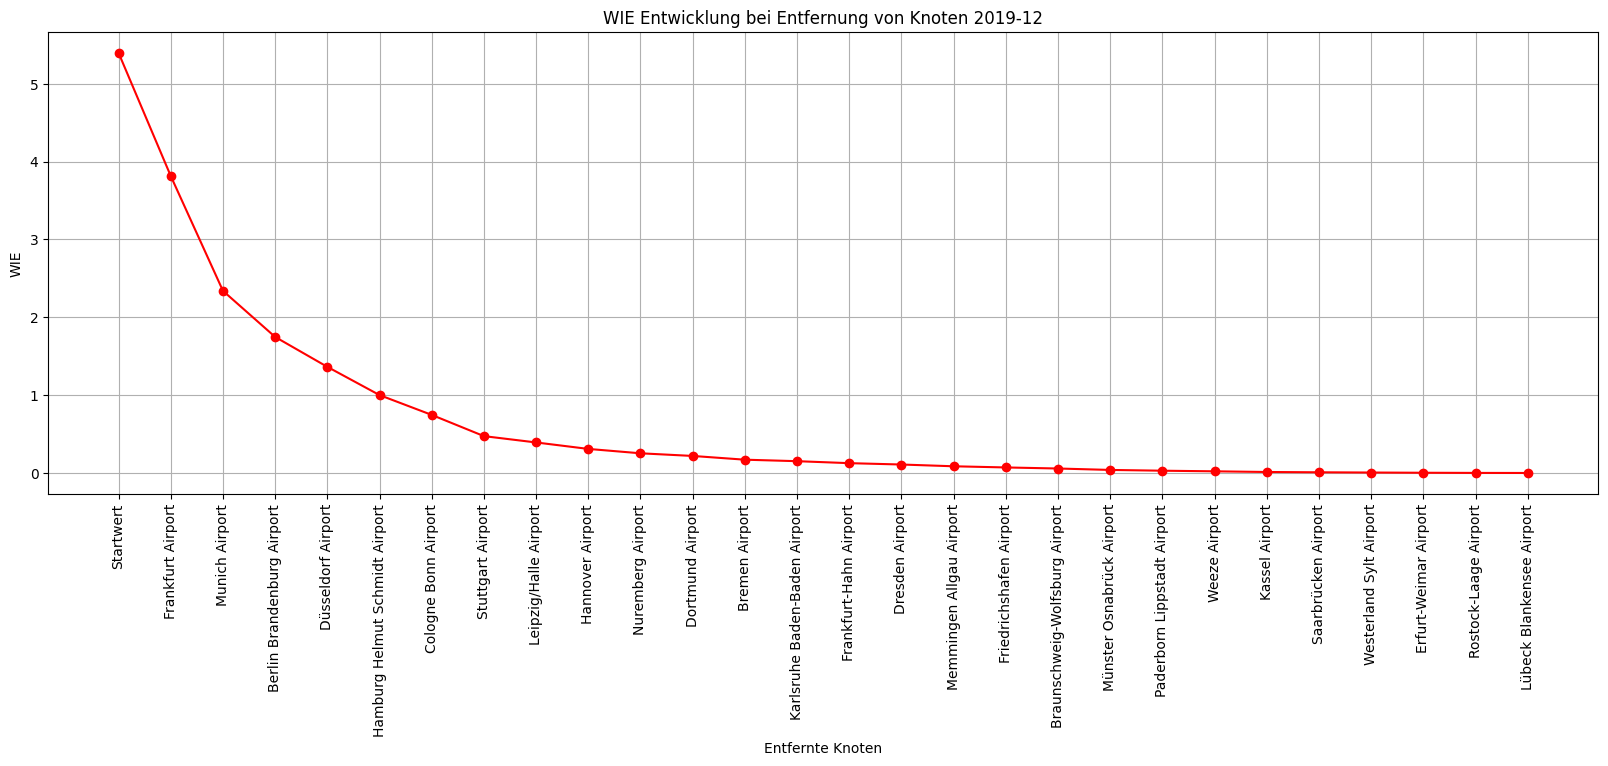

/content/drive/My Drive/2024KomplexeNetze/Daten/2020-01-01_2020-04-01_deutschland_v2.csv
Number of nodes (airports): 840
Number of edges (flight routes): 4549, sum of weights (flights) 41775.0
Found 885 international airports to check against
Number of edges (domestic flight routes): 1344, sum of weights (domestic flights) 12310.0
Number of edges (international flight routes): 3205, sum of weights (international flights) 29465.0
WIE_post has become zero.
International robustness for 2020-01: 0.7051628566487298


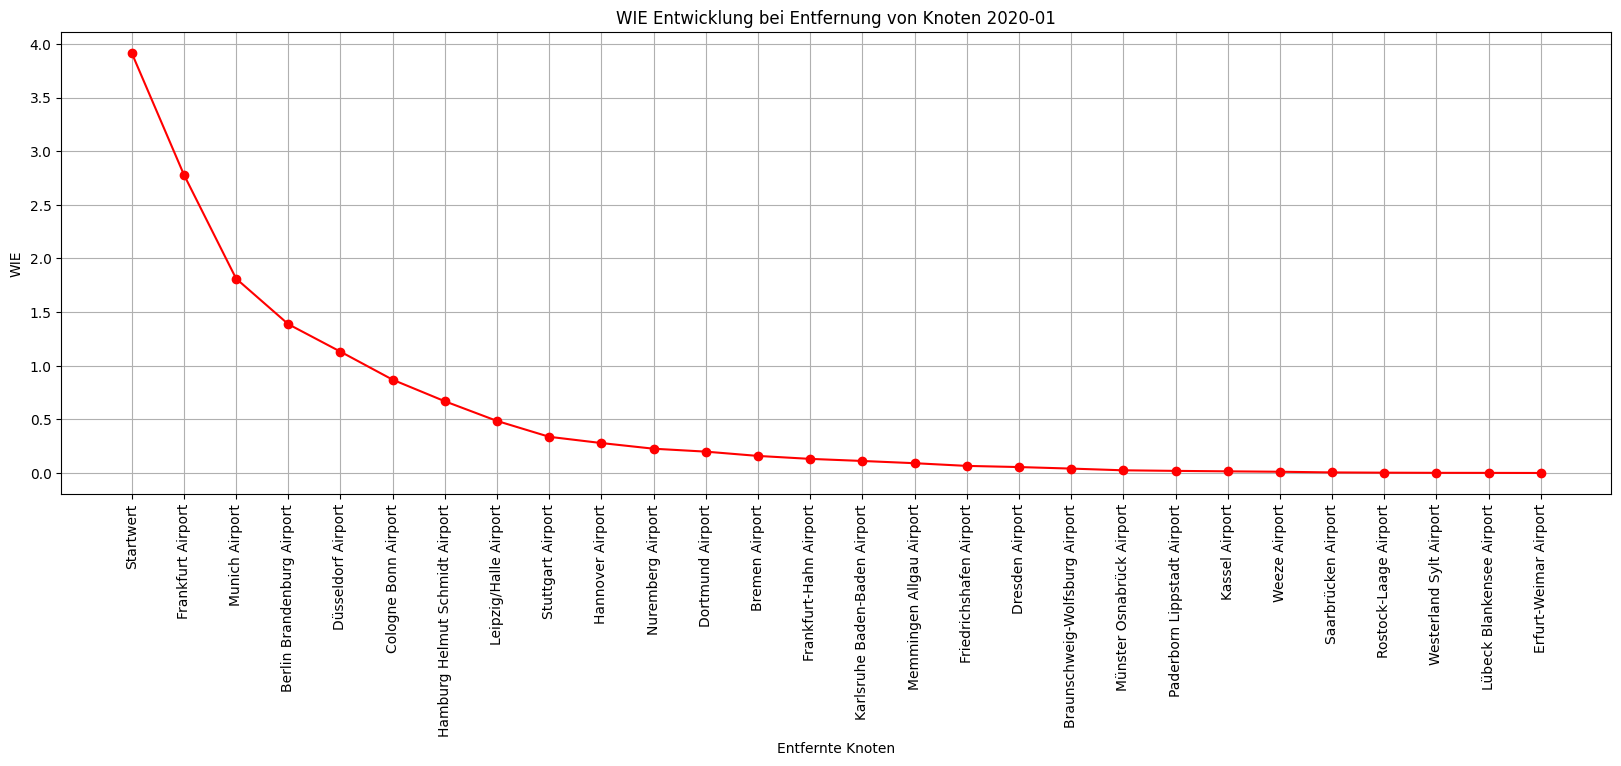

Number of nodes (airports): 817
Number of edges (flight routes): 4547, sum of weights (flights) 41797.0
Found 885 international airports to check against
Number of edges (domestic flight routes): 1351, sum of weights (domestic flights) 12324.0
Number of edges (international flight routes): 3196, sum of weights (international flights) 29473.0
WIE_post has become zero.
International robustness for 2020-02: 0.7046702026906976


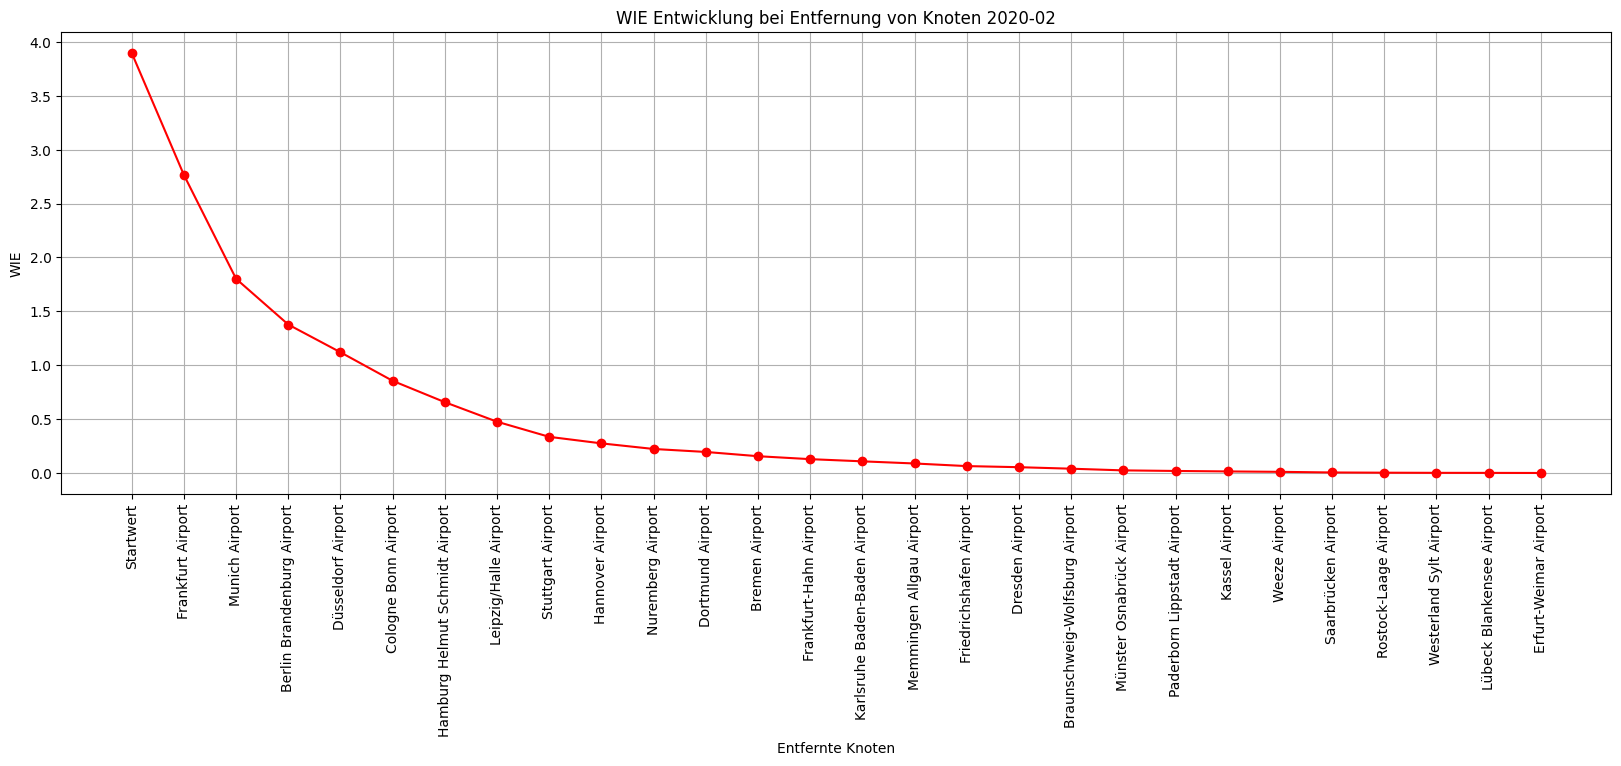

Number of nodes (airports): 815
Number of edges (flight routes): 4466, sum of weights (flights) 41664.0
Found 885 international airports to check against
Number of edges (domestic flight routes): 1357, sum of weights (domestic flights) 12325.0
Number of edges (international flight routes): 3109, sum of weights (international flights) 29339.0
WIE_post has become zero.
International robustness for 2020-03: 0.7047386394518602


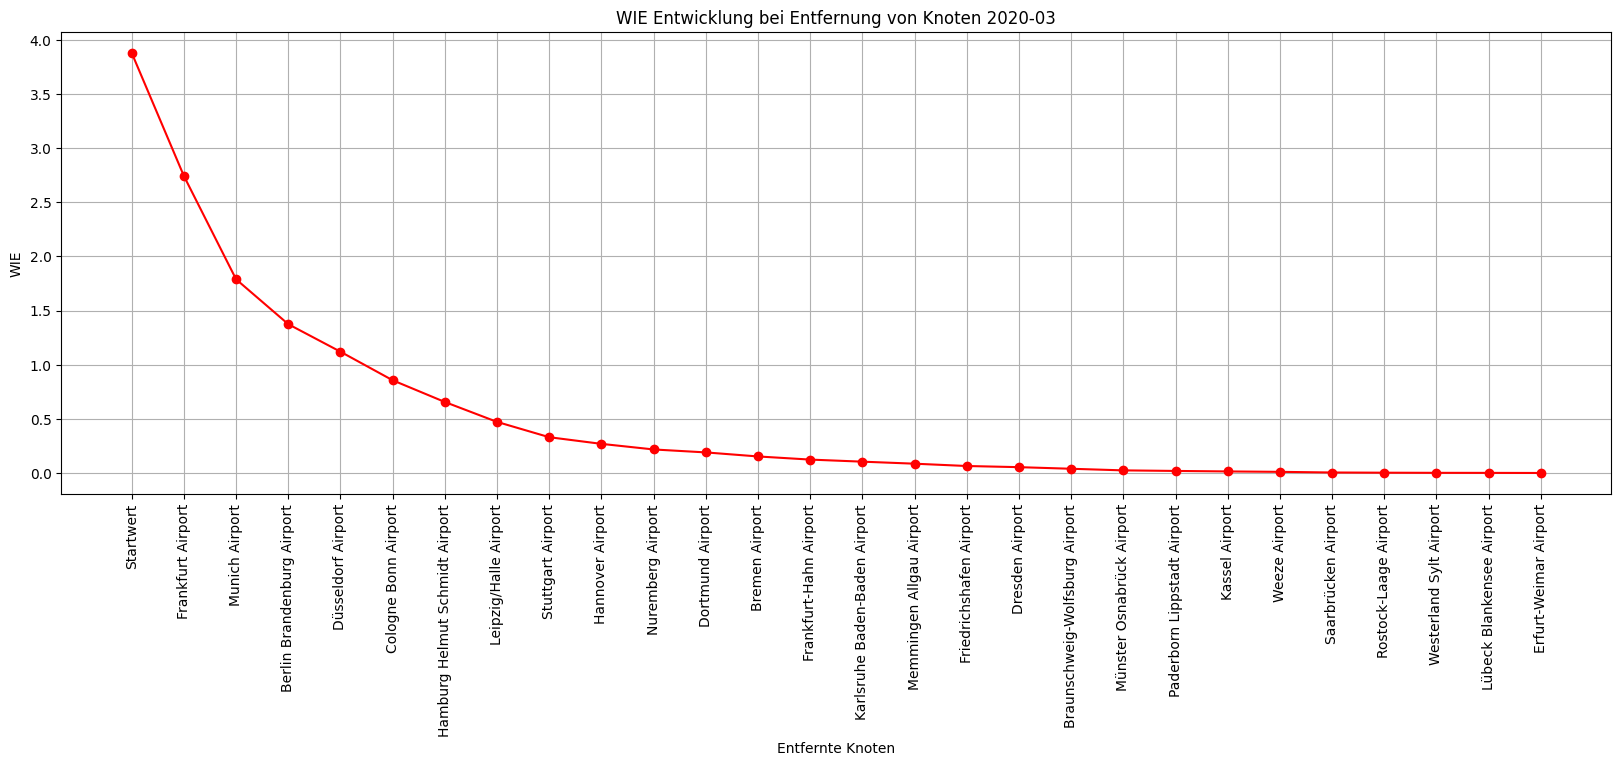

/content/drive/My Drive/2024KomplexeNetze/Daten/2020-04-01_2020-07-01_deutschland_v2.csv
Number of nodes (airports): 581
Number of edges (flight routes): 3325, sum of weights (flights) 17400.0
Found 658 international airports to check against
Number of edges (domestic flight routes): 1523, sum of weights (domestic flights) 6483.0
Number of edges (international flight routes): 1802, sum of weights (international flights) 10917.0
WIE_post has become zero.
International robustness for 2020-04: 0.722767491050193


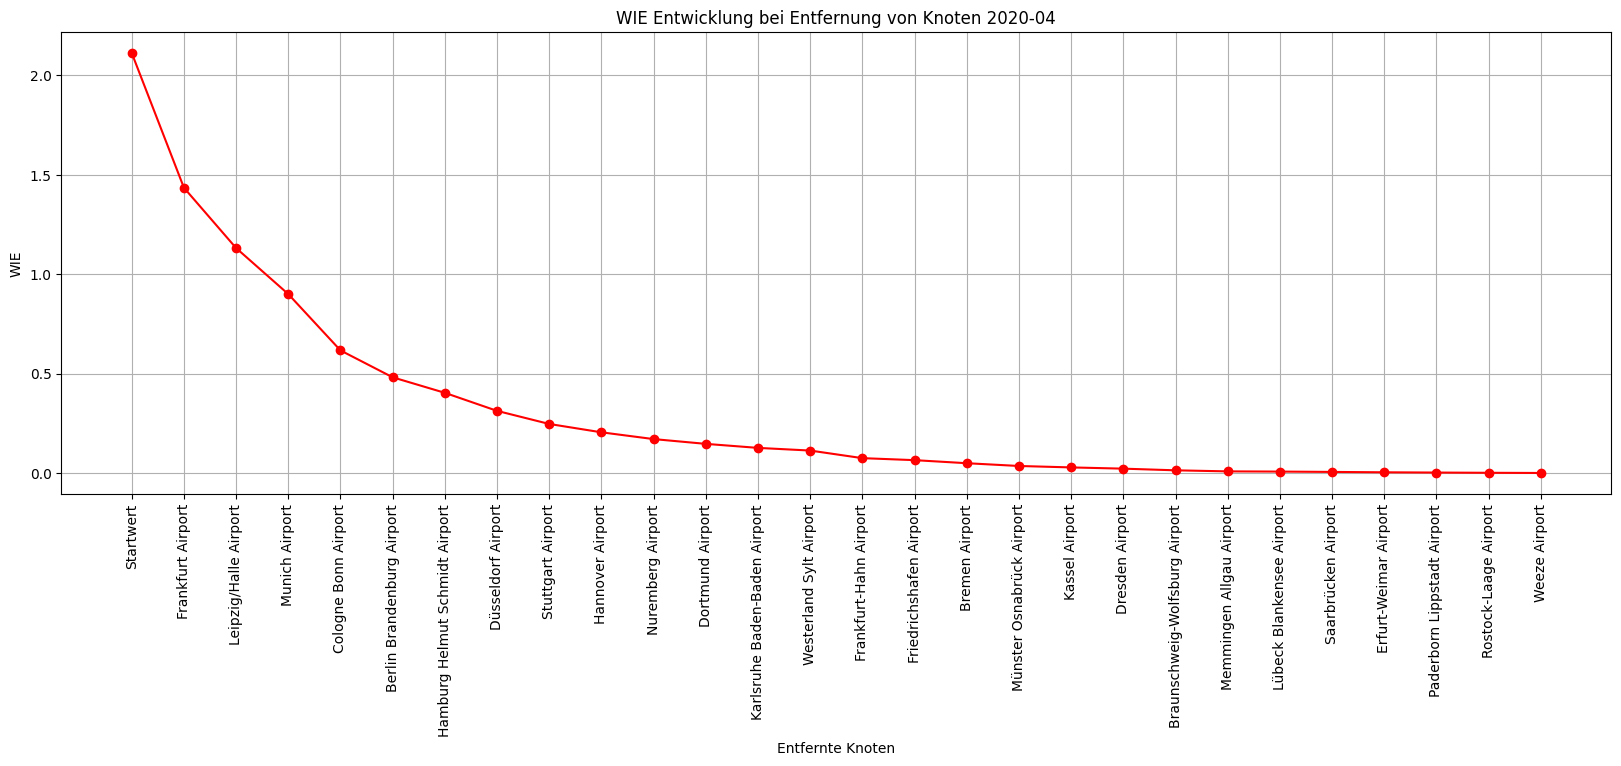

Number of nodes (airports): 644
Number of edges (flight routes): 3529, sum of weights (flights) 18050.0
Found 658 international airports to check against
Number of edges (domestic flight routes): 1582, sum of weights (domestic flights) 6582.0
Number of edges (international flight routes): 1947, sum of weights (international flights) 11468.0
WIE_post has become zero.
International robustness for 2020-05: 0.7231721886405814


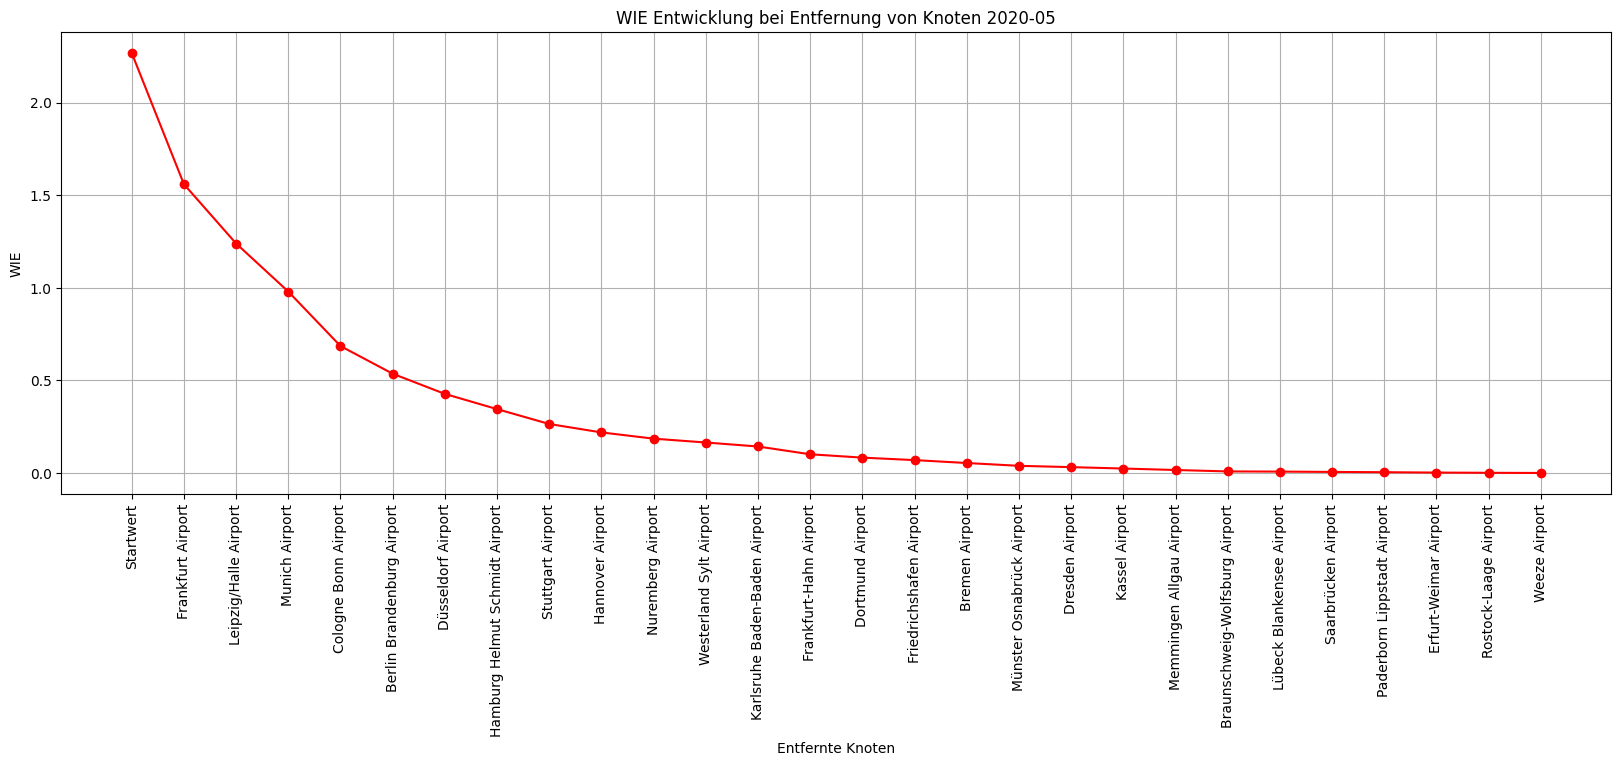

Number of nodes (airports): 782
Number of edges (flight routes): 3813, sum of weights (flights) 18459.0
Found 658 international airports to check against
Number of edges (domestic flight routes): 1629, sum of weights (domestic flights) 6636.0
Number of edges (international flight routes): 2184, sum of weights (international flights) 11823.0
WIE_post has become zero.
International robustness for 2020-06: 0.7233719763734315


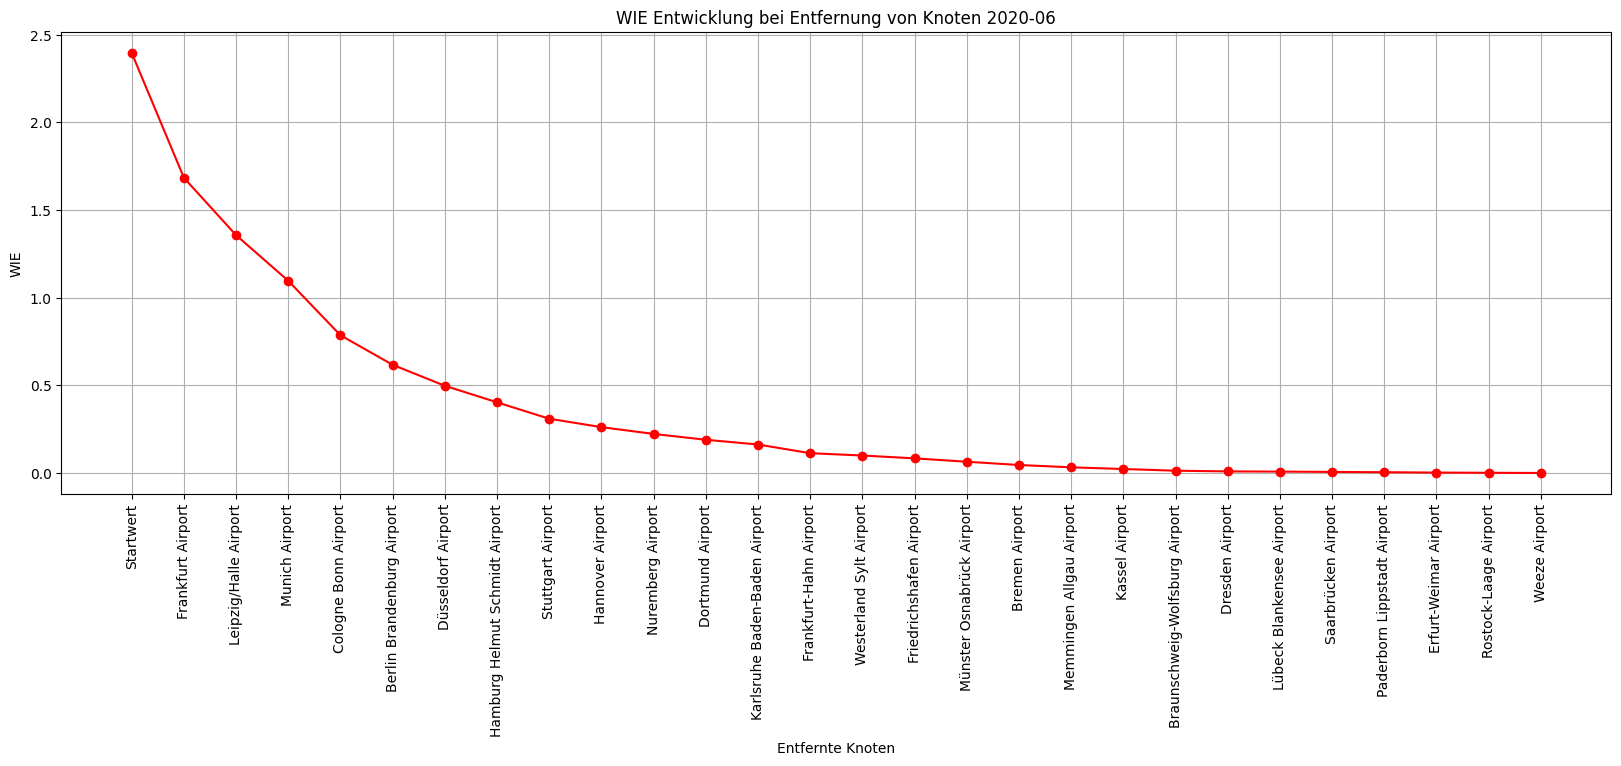

/content/drive/My Drive/2024KomplexeNetze/Daten/2020-07-01_2020-10-01_deutschland_v2.csv
Number of nodes (airports): 896
Number of edges (flight routes): 5402, sum of weights (flights) 36533.0
Found 888 international airports to check against
Number of edges (domestic flight routes): 1938, sum of weights (domestic flights) 11073.0
Number of edges (international flight routes): 3464, sum of weights (international flights) 25460.0
WIE_post has become zero.
International robustness for 2020-07: 0.7266023476682109


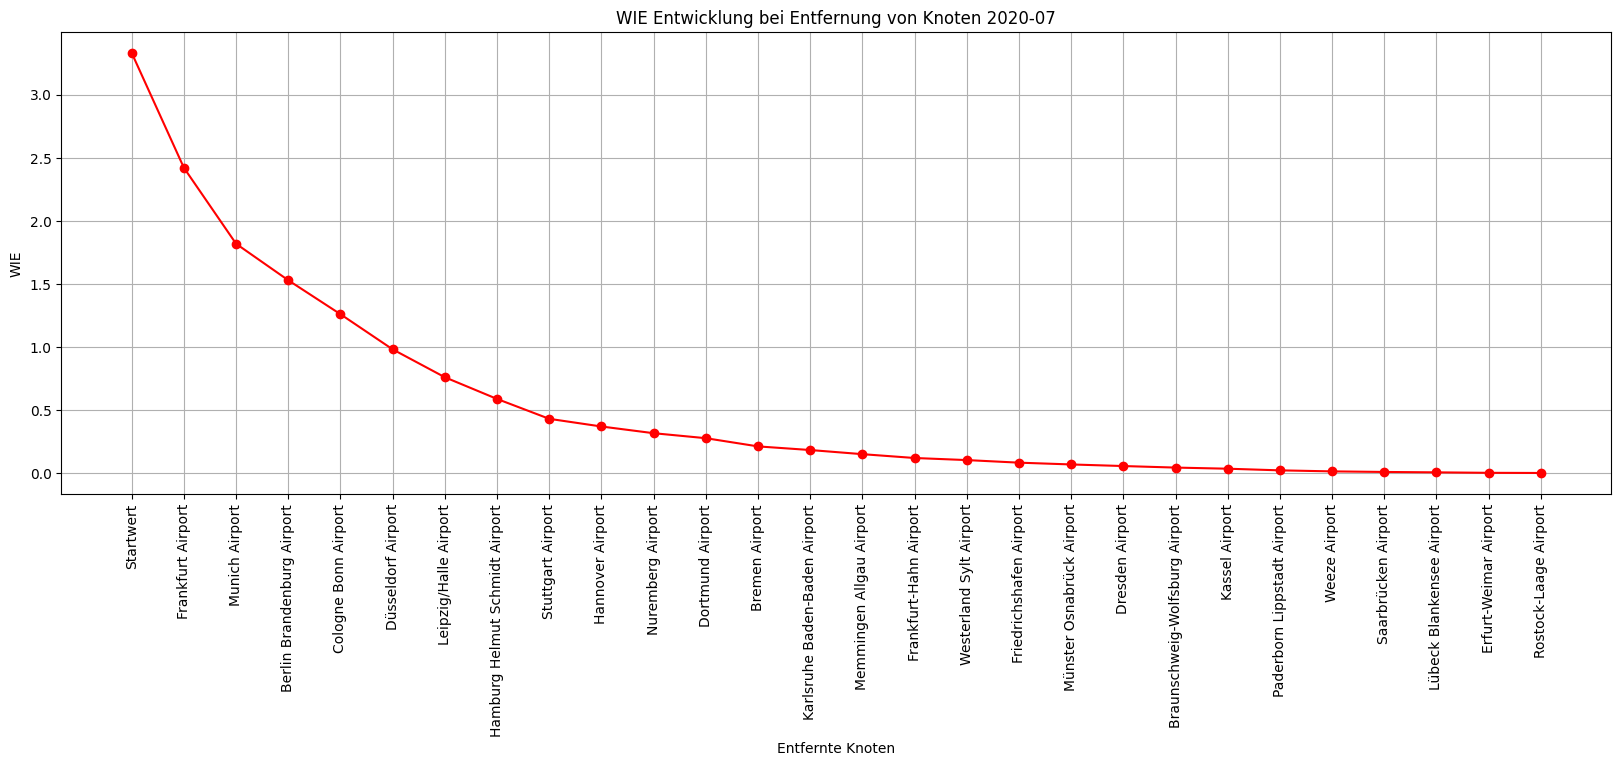

Number of nodes (airports): 898
Number of edges (flight routes): 5439, sum of weights (flights) 36283.0
Found 888 international airports to check against
Number of edges (domestic flight routes): 1967, sum of weights (domestic flights) 11101.0
Number of edges (international flight routes): 3472, sum of weights (international flights) 25182.0
WIE_post has become zero.
International robustness for 2020-08: 0.7268247689382284


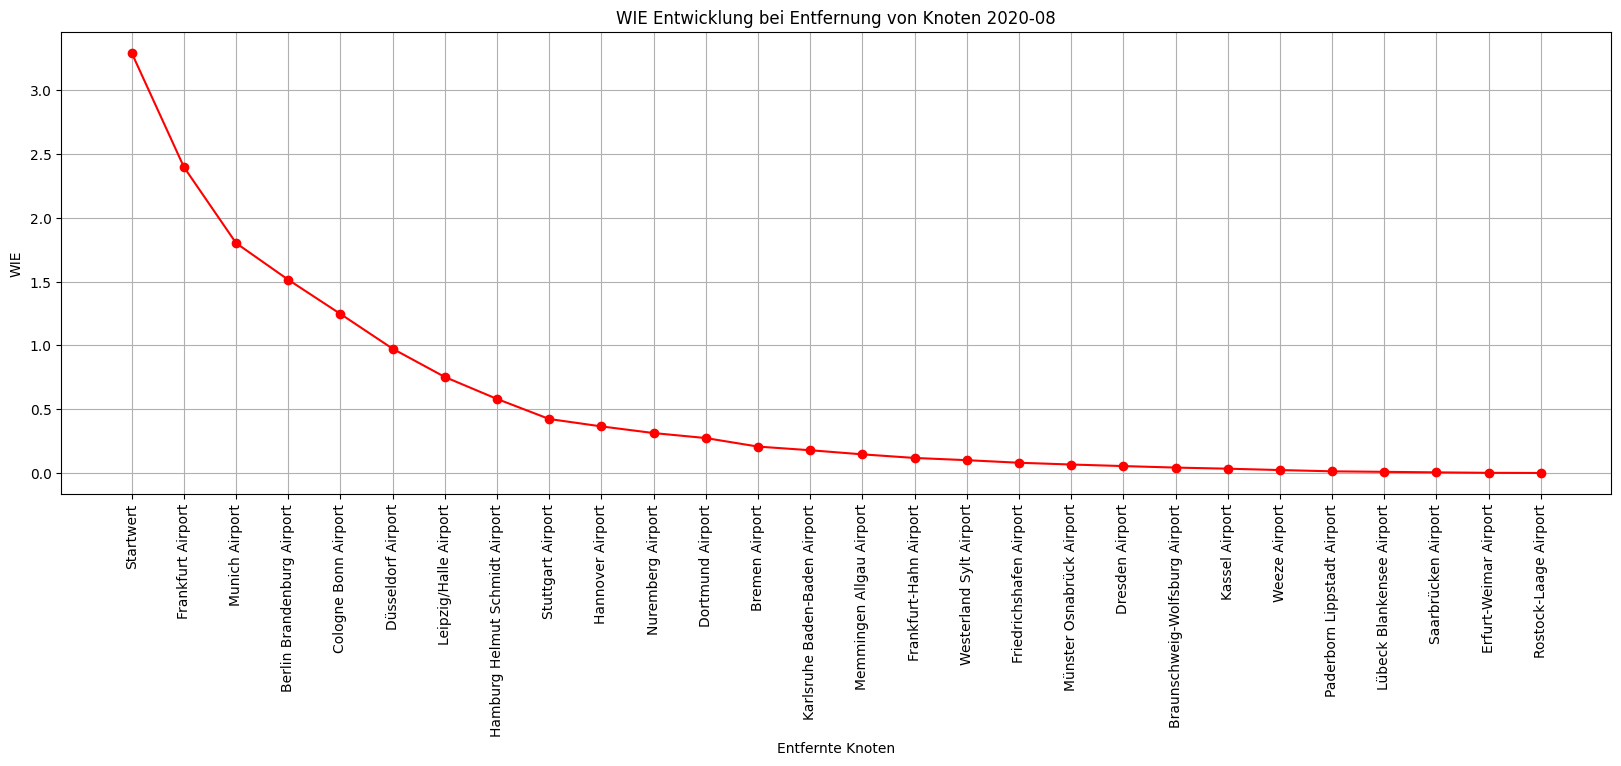

Number of nodes (airports): 897
Number of edges (flight routes): 5379, sum of weights (flights) 36164.0
Found 888 international airports to check against
Number of edges (domestic flight routes): 1973, sum of weights (domestic flights) 11118.0
Number of edges (international flight routes): 3406, sum of weights (international flights) 25046.0
WIE_post has become zero.
International robustness for 2020-09: 0.724004448500853


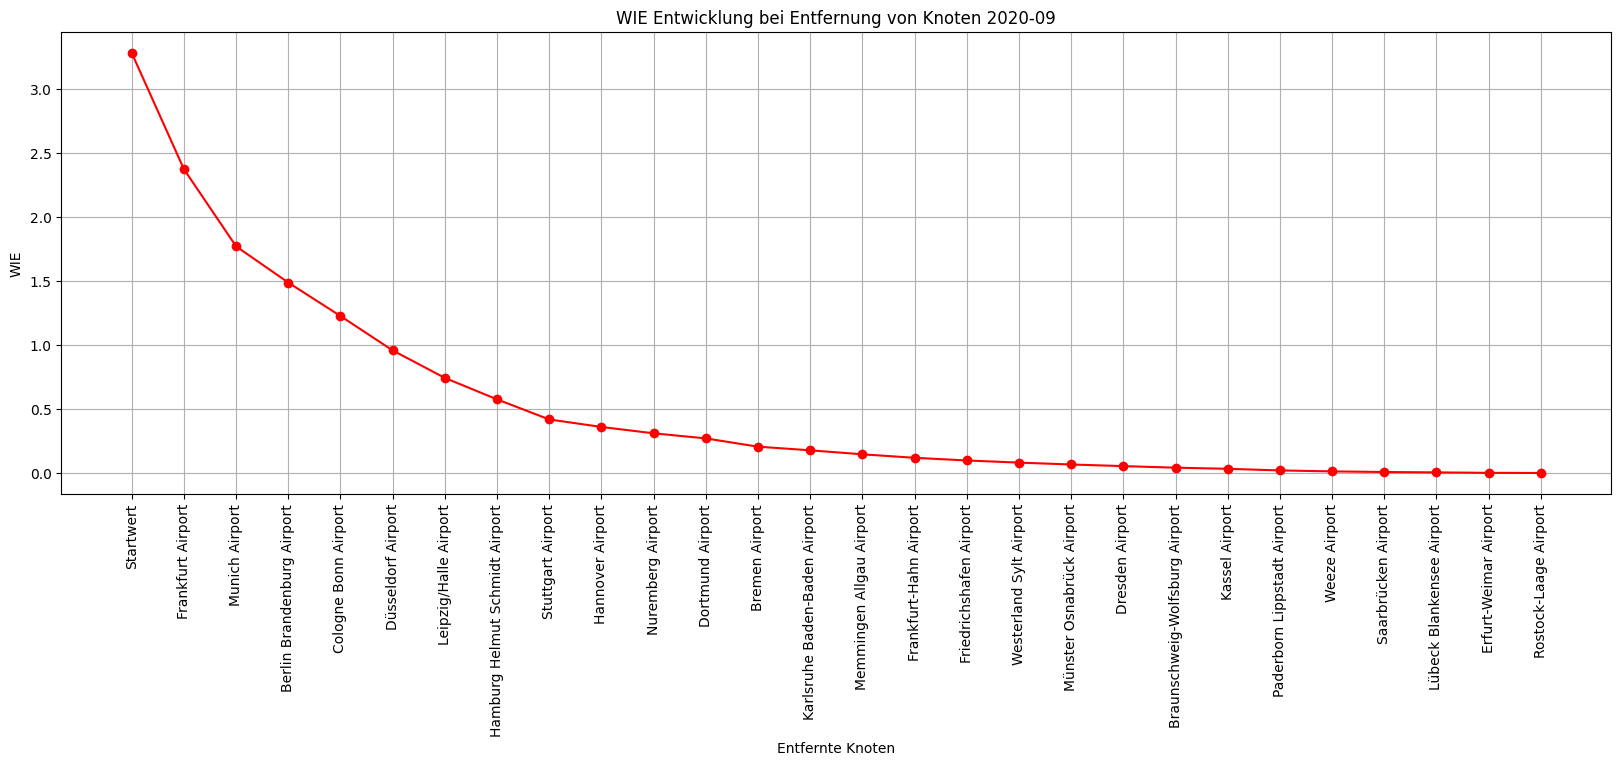

/content/drive/My Drive/2024KomplexeNetze/Daten/2020-10-01_2021-01-01_deutschland_v2.csv
Number of nodes (airports): 828
Number of edges (flight routes): 4519, sum of weights (flights) 23375.0
Found 783 international airports to check against
Number of edges (domestic flight routes): 1570, sum of weights (domestic flights) 6831.0
Number of edges (international flight routes): 2949, sum of weights (international flights) 16544.0
WIE_post has become zero.
International robustness for 2020-10: 0.7195540655946564


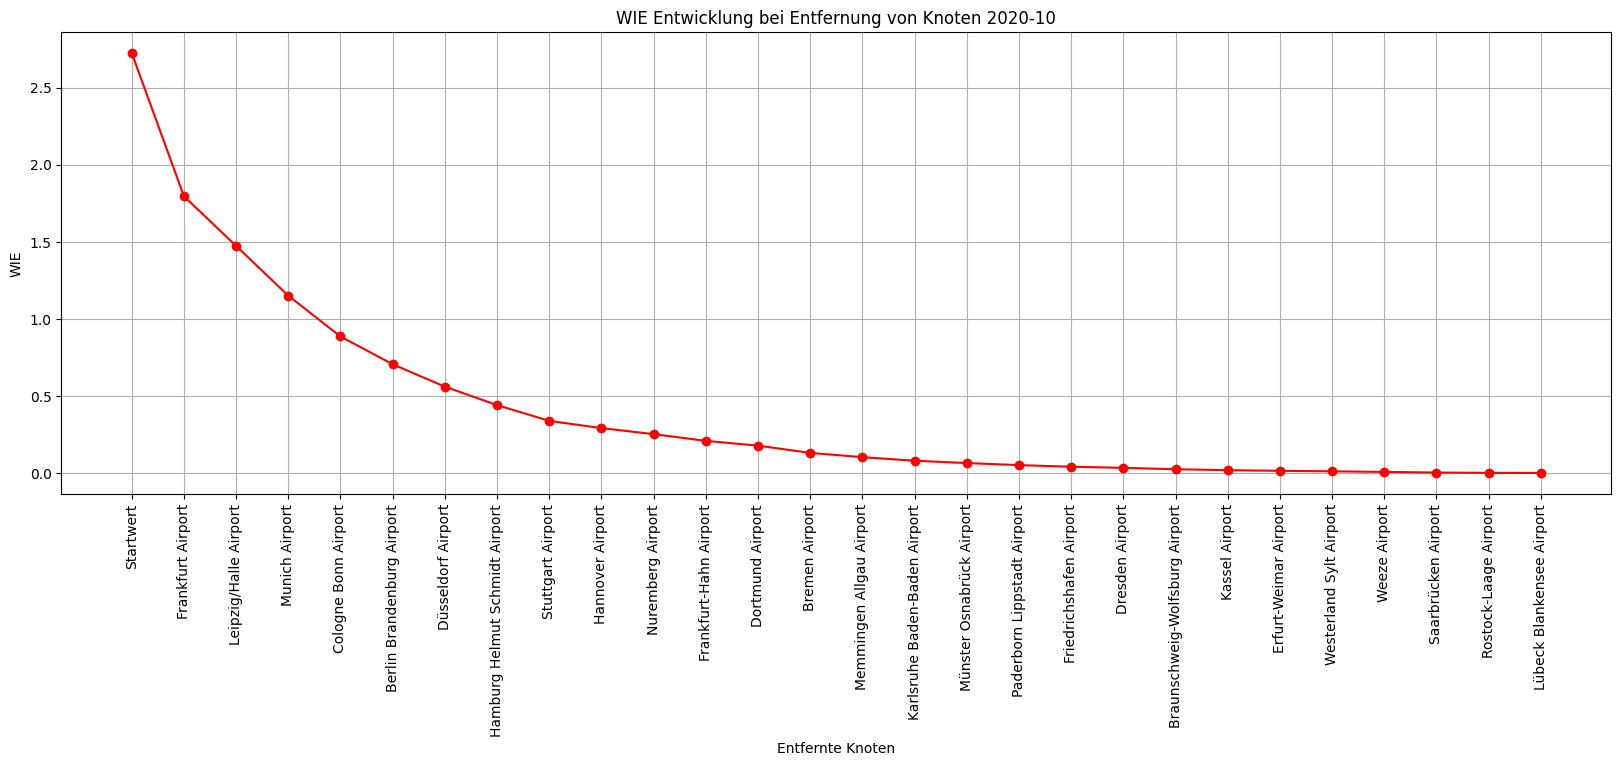

Number of nodes (airports): 714
Number of edges (flight routes): 4261, sum of weights (flights) 22944.0
Found 783 international airports to check against
Number of edges (domestic flight routes): 1491, sum of weights (domestic flights) 6750.0
Number of edges (international flight routes): 2770, sum of weights (international flights) 16194.0
WIE_post has become zero.
International robustness for 2020-11: 0.7199723511233067


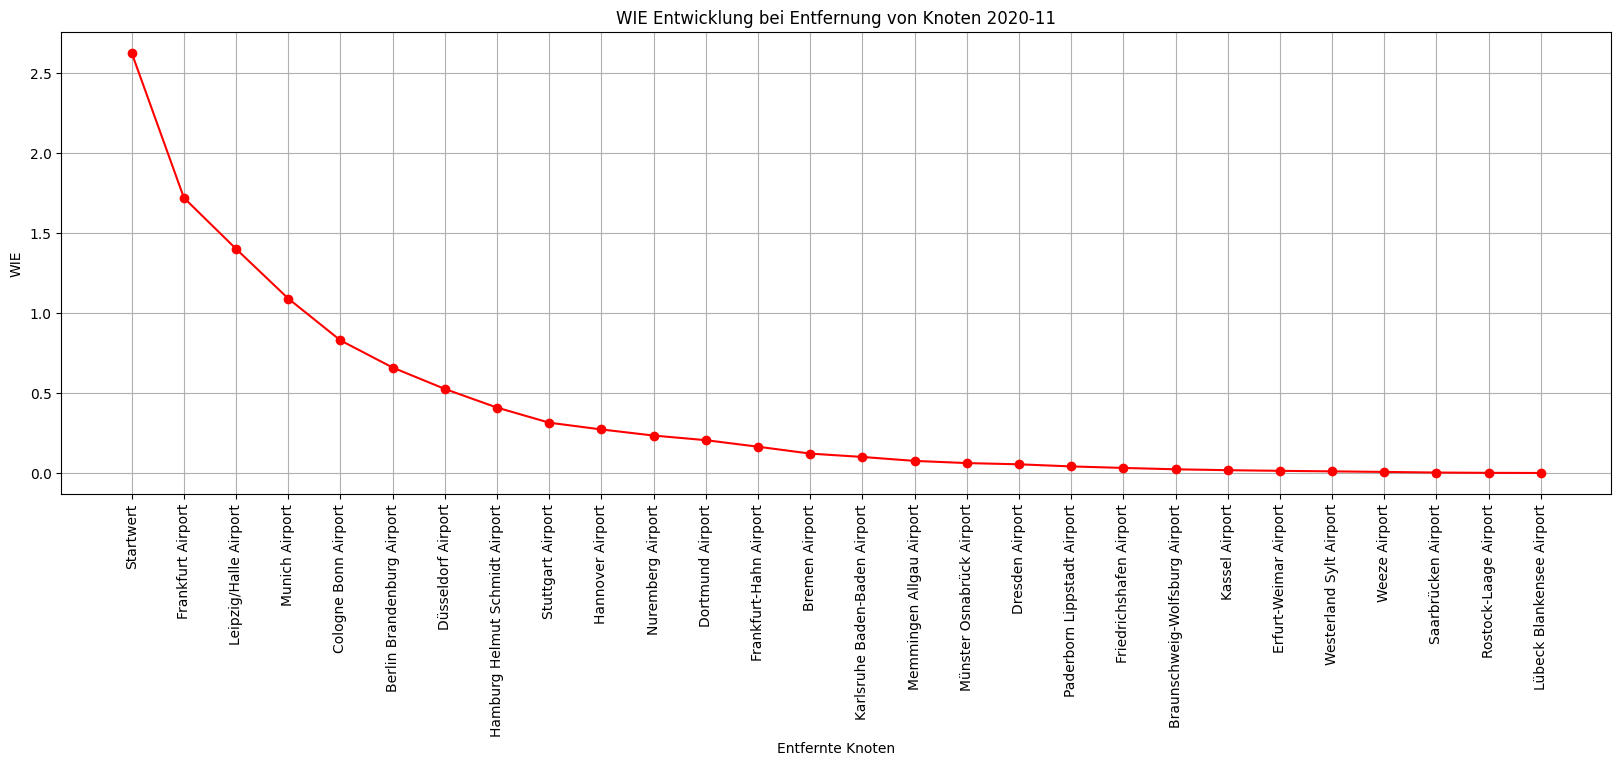

Number of nodes (airports): 698
Number of edges (flight routes): 4124, sum of weights (flights) 22607.0
Found 783 international airports to check against
Number of edges (domestic flight routes): 1494, sum of weights (domestic flights) 6744.0
Number of edges (international flight routes): 2630, sum of weights (international flights) 15863.0
WIE_post has become zero.
International robustness for 2020-12: 0.7196861885587756


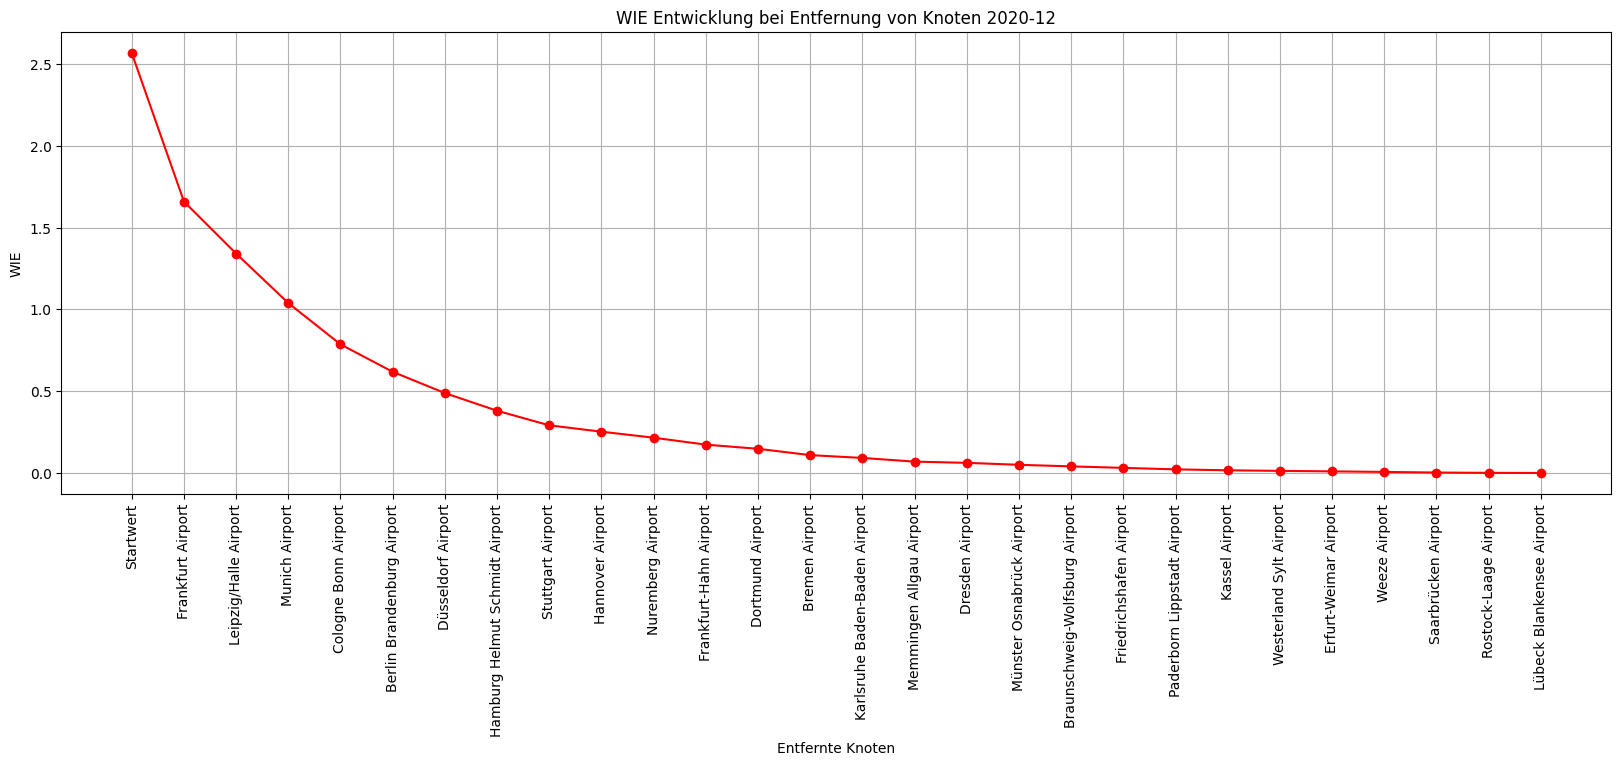

/content/drive/My Drive/2024KomplexeNetze/Daten/2021-01-01_2021-04-01_deutschland_v2.csv
Number of nodes (airports): 655
Number of edges (flight routes): 3714, sum of weights (flights) 21030.0
Found 718 international airports to check against
Number of edges (domestic flight routes): 1398, sum of weights (domestic flights) 6487.0
Number of edges (international flight routes): 2316, sum of weights (international flights) 14543.0
WIE_post has become zero.
International robustness for 2021-01: 0.7248642831761407


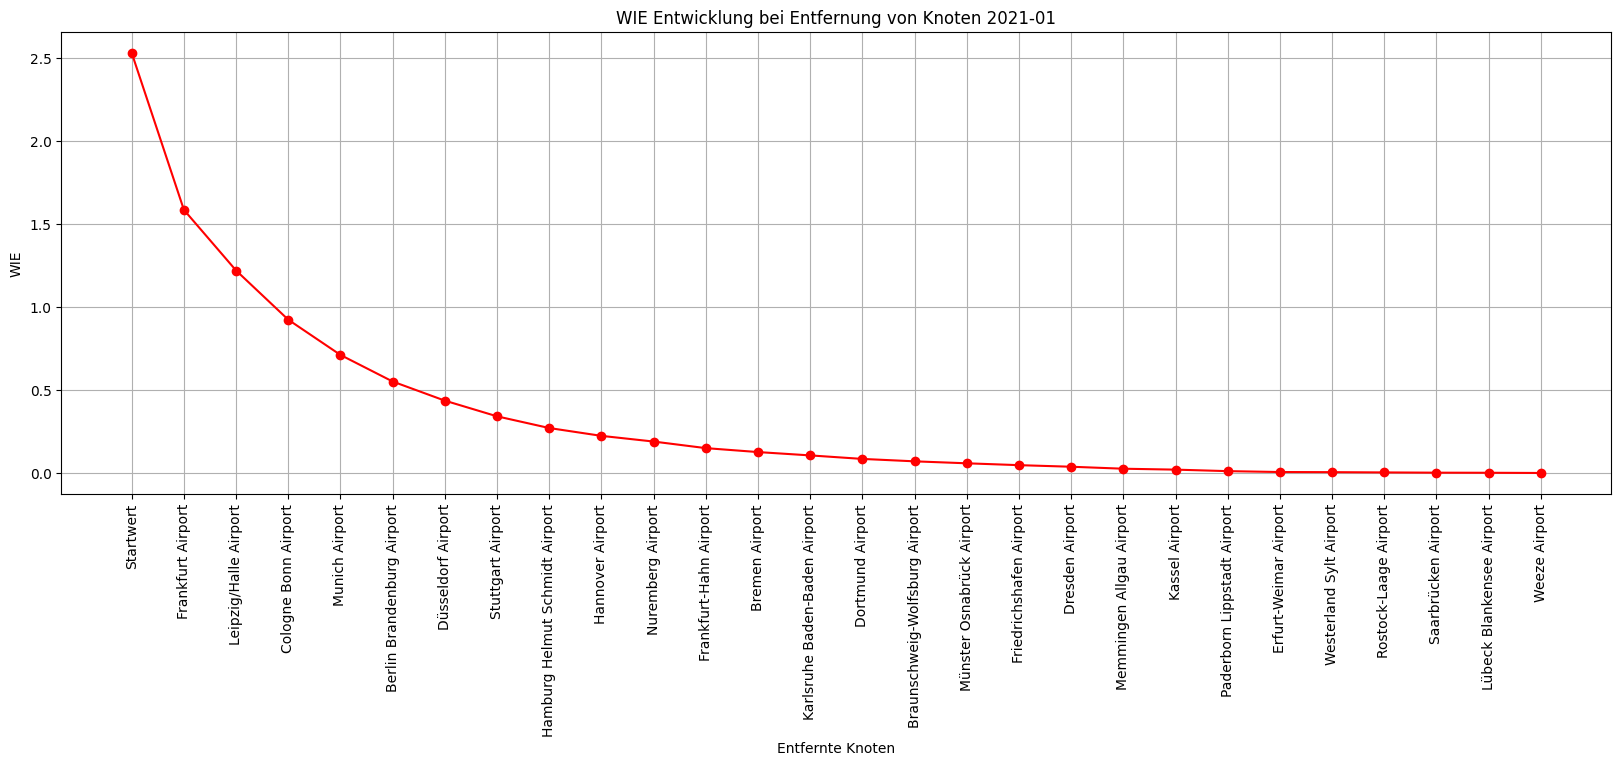

Number of nodes (airports): 704
Number of edges (flight routes): 3793, sum of weights (flights) 21176.0
Found 718 international airports to check against
Number of edges (domestic flight routes): 1463, sum of weights (domestic flights) 6588.0
Number of edges (international flight routes): 2330, sum of weights (international flights) 14588.0
WIE_post has become zero.
International robustness for 2021-02: 0.722195365080802


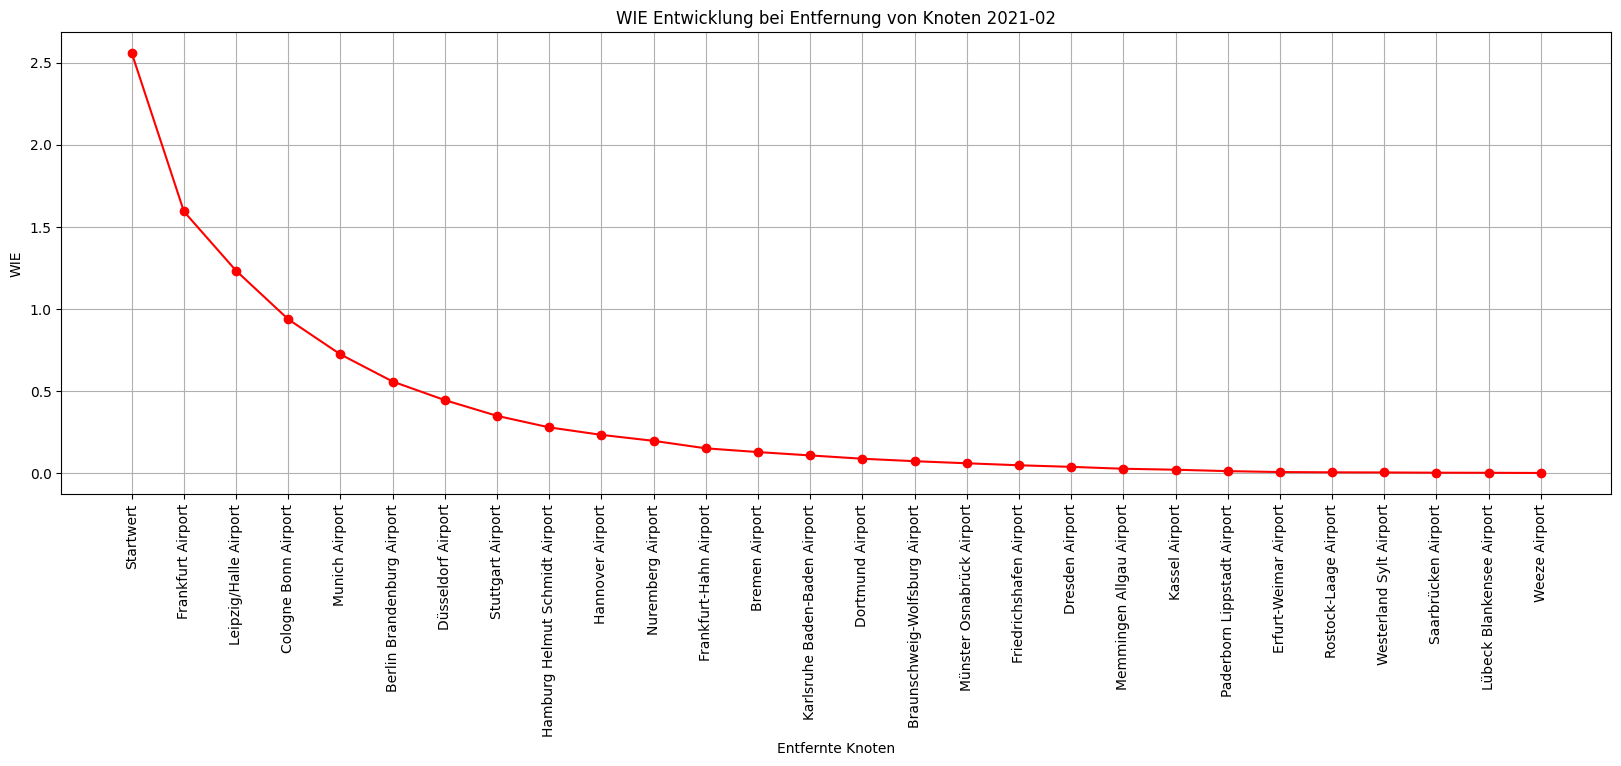

Number of nodes (airports): 753
Number of edges (flight routes): 3887, sum of weights (flights) 21229.0
Found 718 international airports to check against
Number of edges (domestic flight routes): 1524, sum of weights (domestic flights) 6660.0
Number of edges (international flight routes): 2363, sum of weights (international flights) 14569.0
WIE_post has become zero.
International robustness for 2021-03: 0.7188109399730146


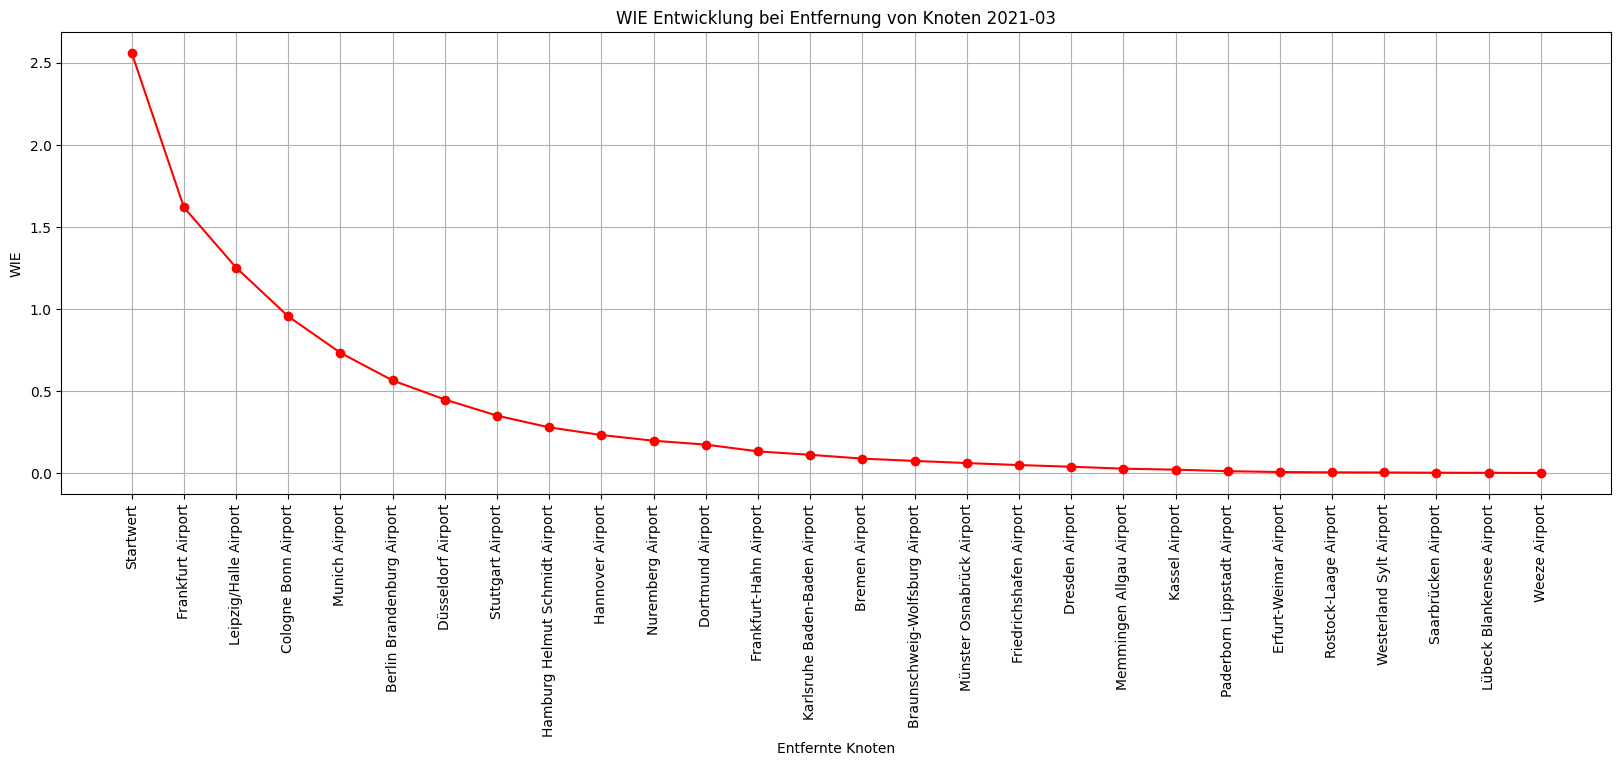

/content/drive/My Drive/2024KomplexeNetze/Daten/2021-04-01_2021-07-01_deutschland_v2.csv
Number of nodes (airports): 789
Number of edges (flight routes): 4944, sum of weights (flights) 33371.0
Found 864 international airports to check against
Number of edges (domestic flight routes): 1892, sum of weights (domestic flights) 9237.0
Number of edges (international flight routes): 3052, sum of weights (international flights) 24134.0
WIE_post has become zero.
International robustness for 2021-04: 0.7232619217454445


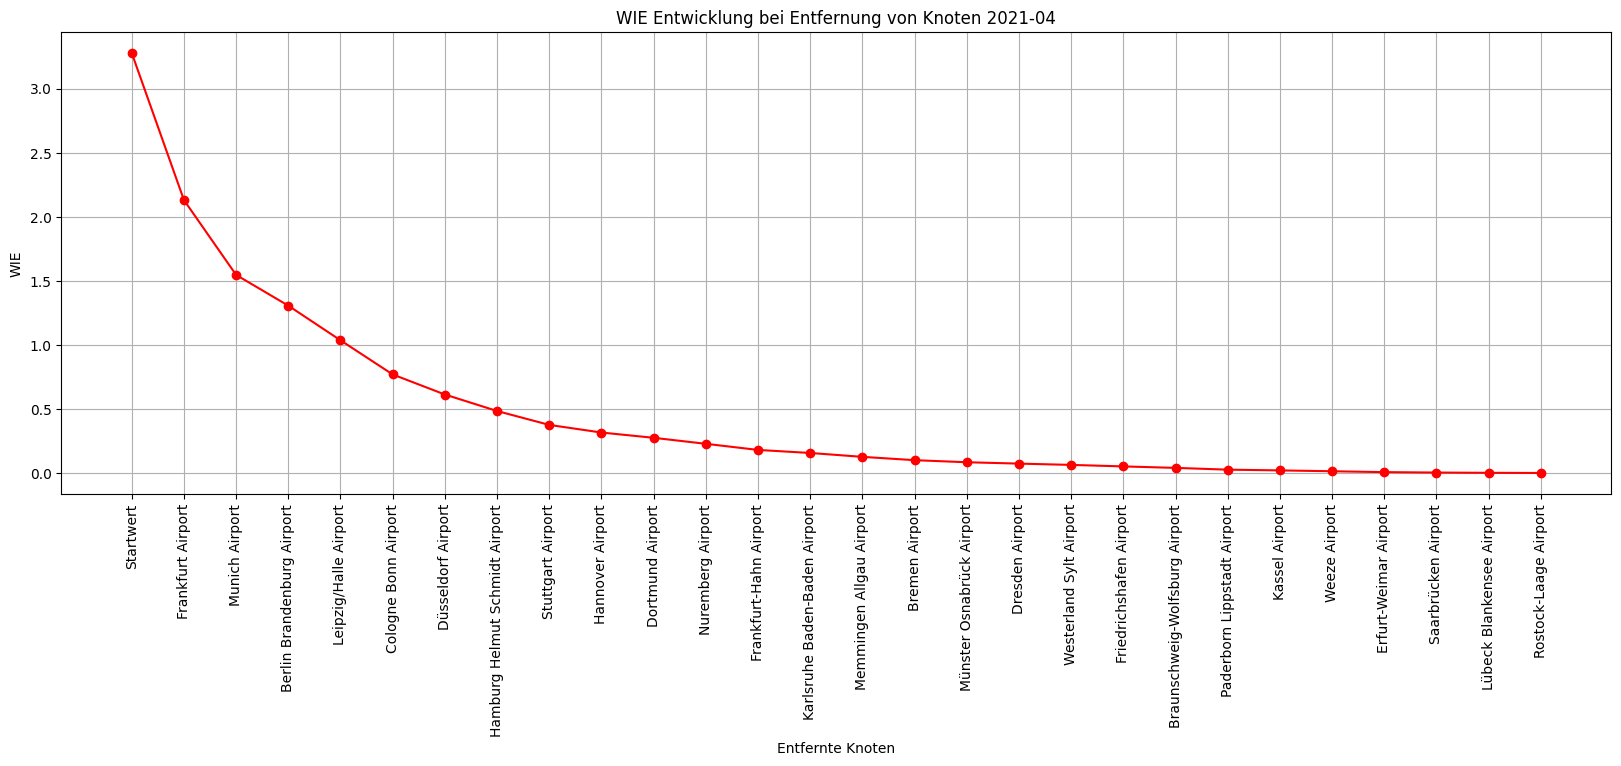

Number of nodes (airports): 848
Number of edges (flight routes): 5143, sum of weights (flights) 33801.0
Found 864 international airports to check against
Number of edges (domestic flight routes): 1896, sum of weights (domestic flights) 9244.0
Number of edges (international flight routes): 3247, sum of weights (international flights) 24557.0
WIE_post has become zero.
International robustness for 2021-05: 0.7231432441031823


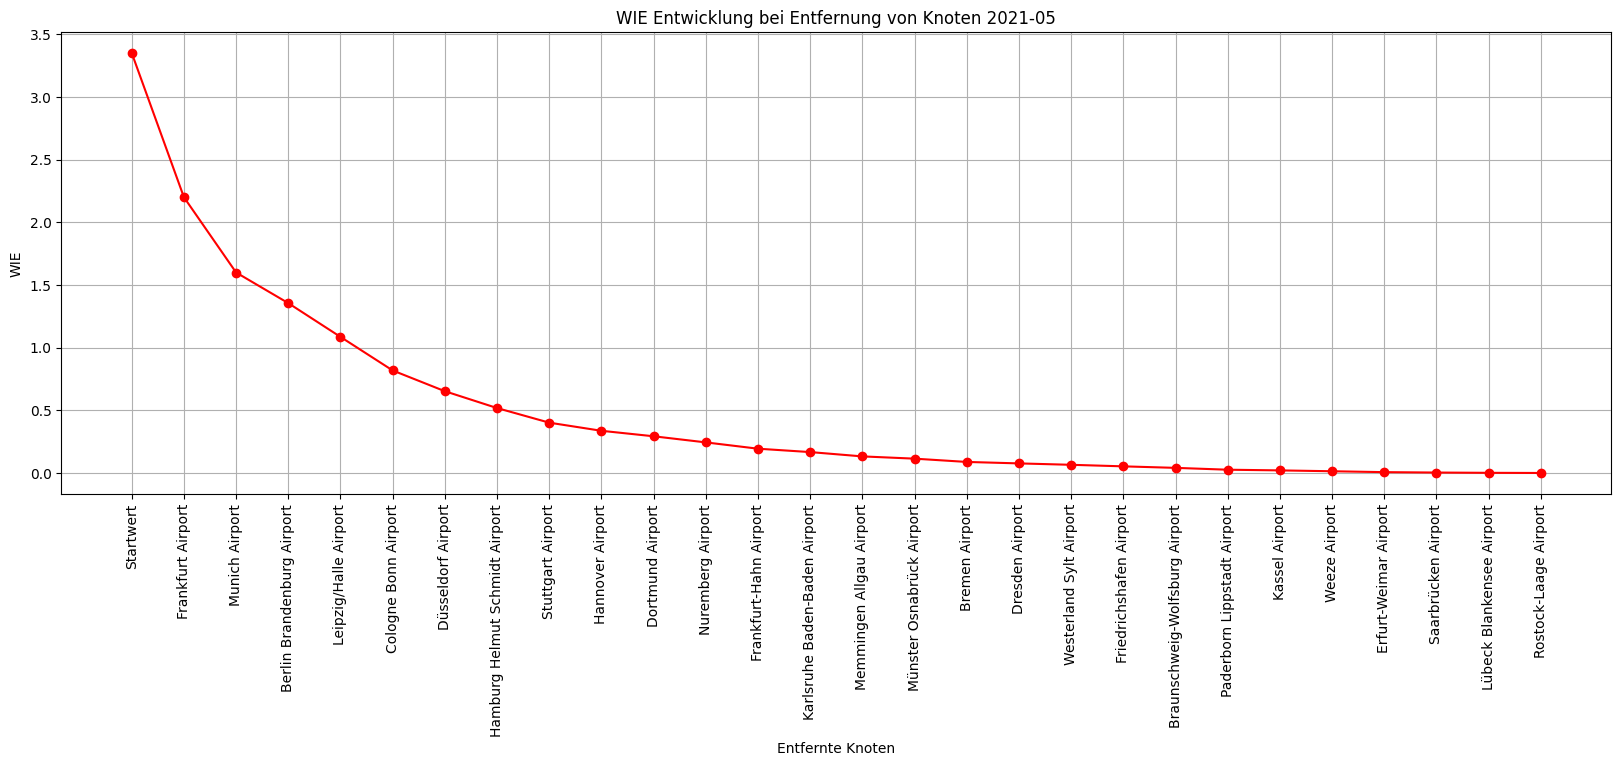

Number of nodes (airports): 942
Number of edges (flight routes): 5301, sum of weights (flights) 34082.0
Found 864 international airports to check against
Number of edges (domestic flight routes): 1945, sum of weights (domestic flights) 9301.0
Number of edges (international flight routes): 3356, sum of weights (international flights) 24781.0
WIE_post has become zero.
International robustness for 2021-06: 0.722534417562755


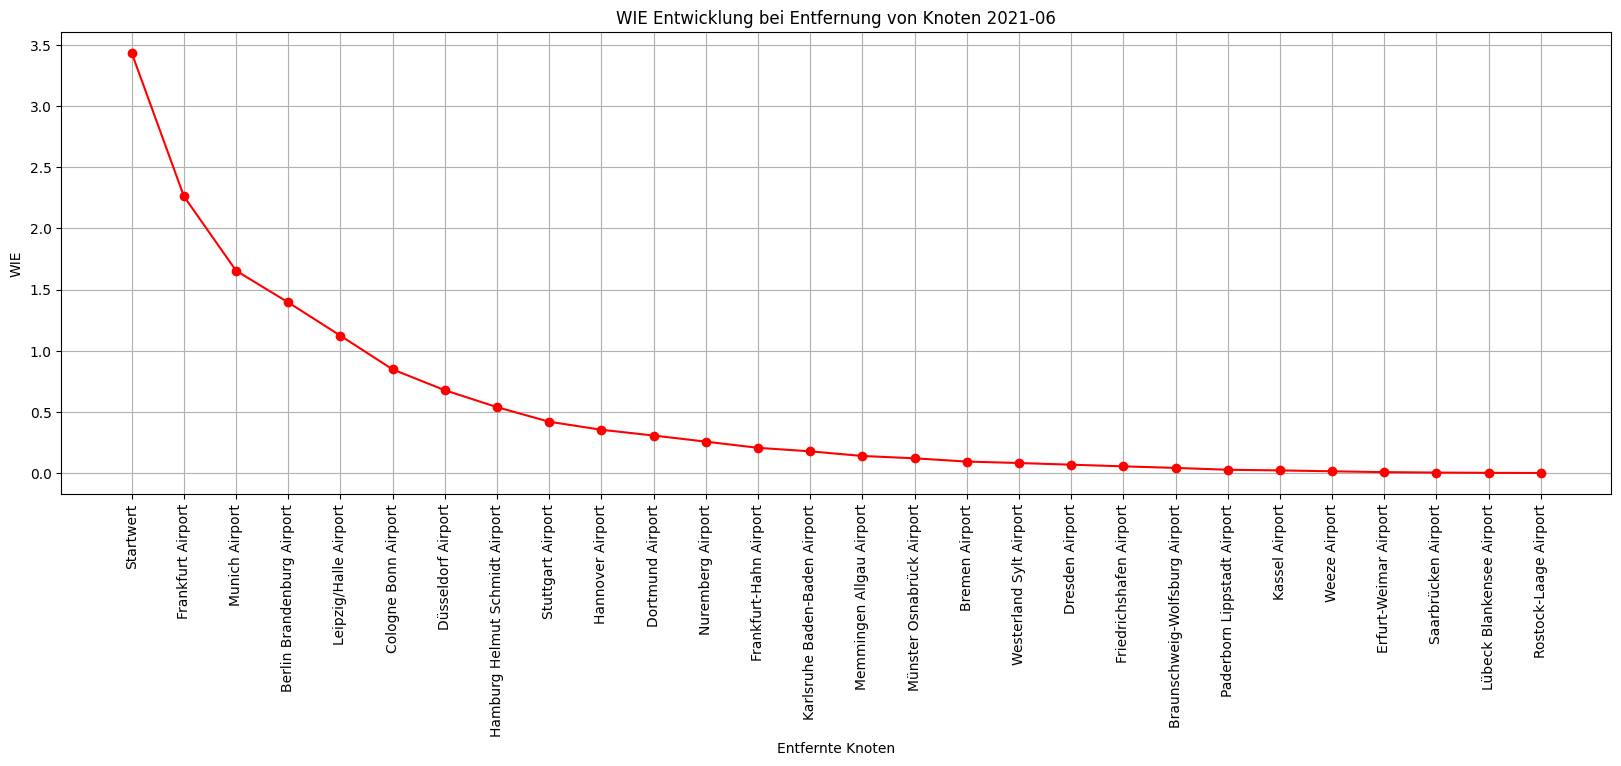

/content/drive/My Drive/2024KomplexeNetze/Daten/2021-07-01_2021-10-01_deutschland_v2.csv
Number of nodes (airports): 1000
Number of edges (flight routes): 6486, sum of weights (flights) 49443.0
Found 1028 international airports to check against
Number of edges (domestic flight routes): 2195, sum of weights (domestic flights) 12565.0
Number of edges (international flight routes): 4291, sum of weights (international flights) 36878.0
WIE_post has become zero.
International robustness for 2021-07: 0.7232234704053648


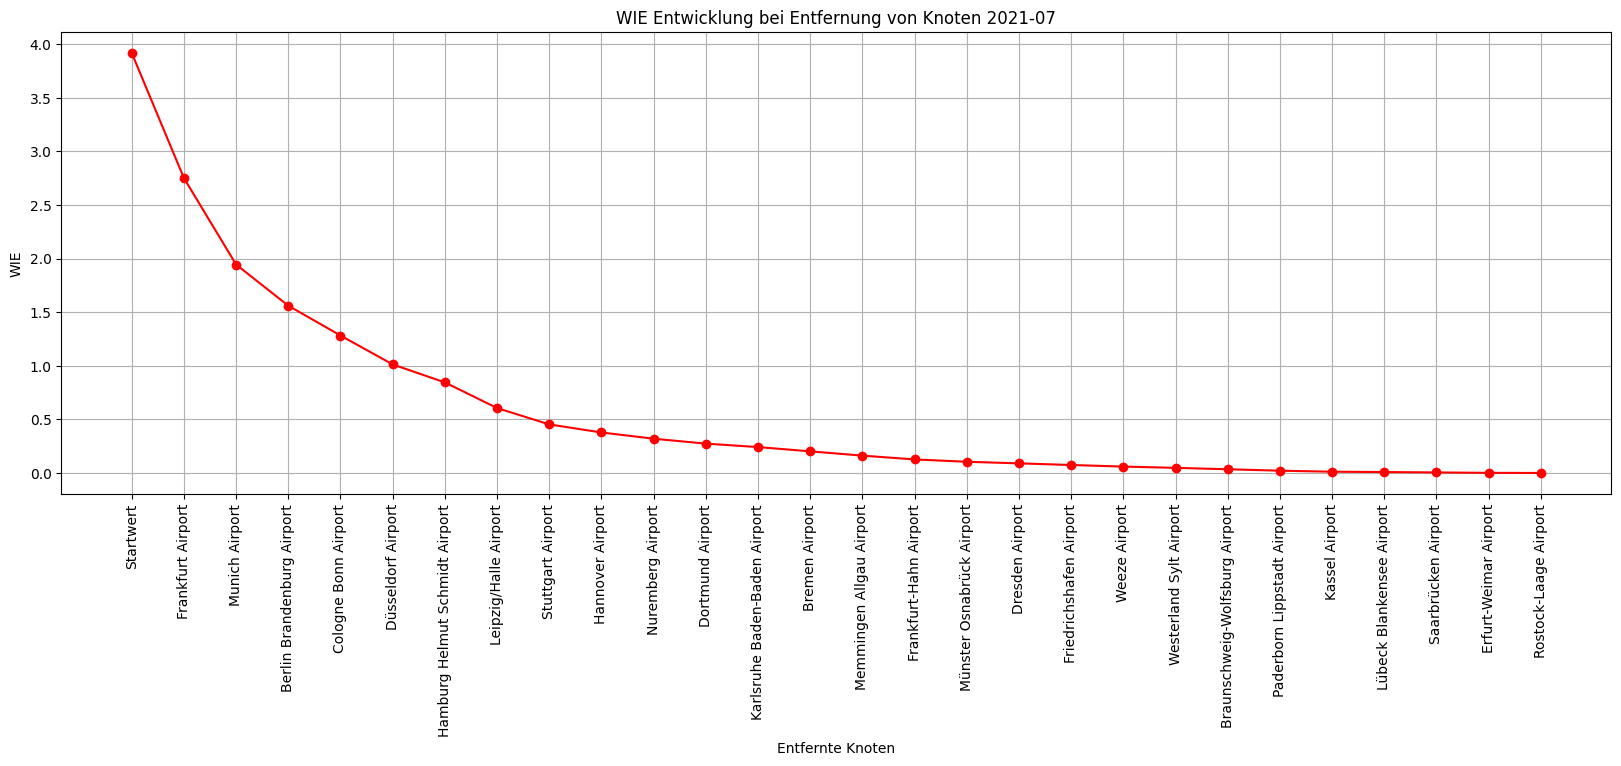

Number of nodes (airports): 975
Number of edges (flight routes): 6386, sum of weights (flights) 49258.0
Found 1028 international airports to check against
Number of edges (domestic flight routes): 2156, sum of weights (domestic flights) 12525.0
Number of edges (international flight routes): 4230, sum of weights (international flights) 36733.0
WIE_post has become zero.
International robustness for 2021-08: 0.7247072069224734


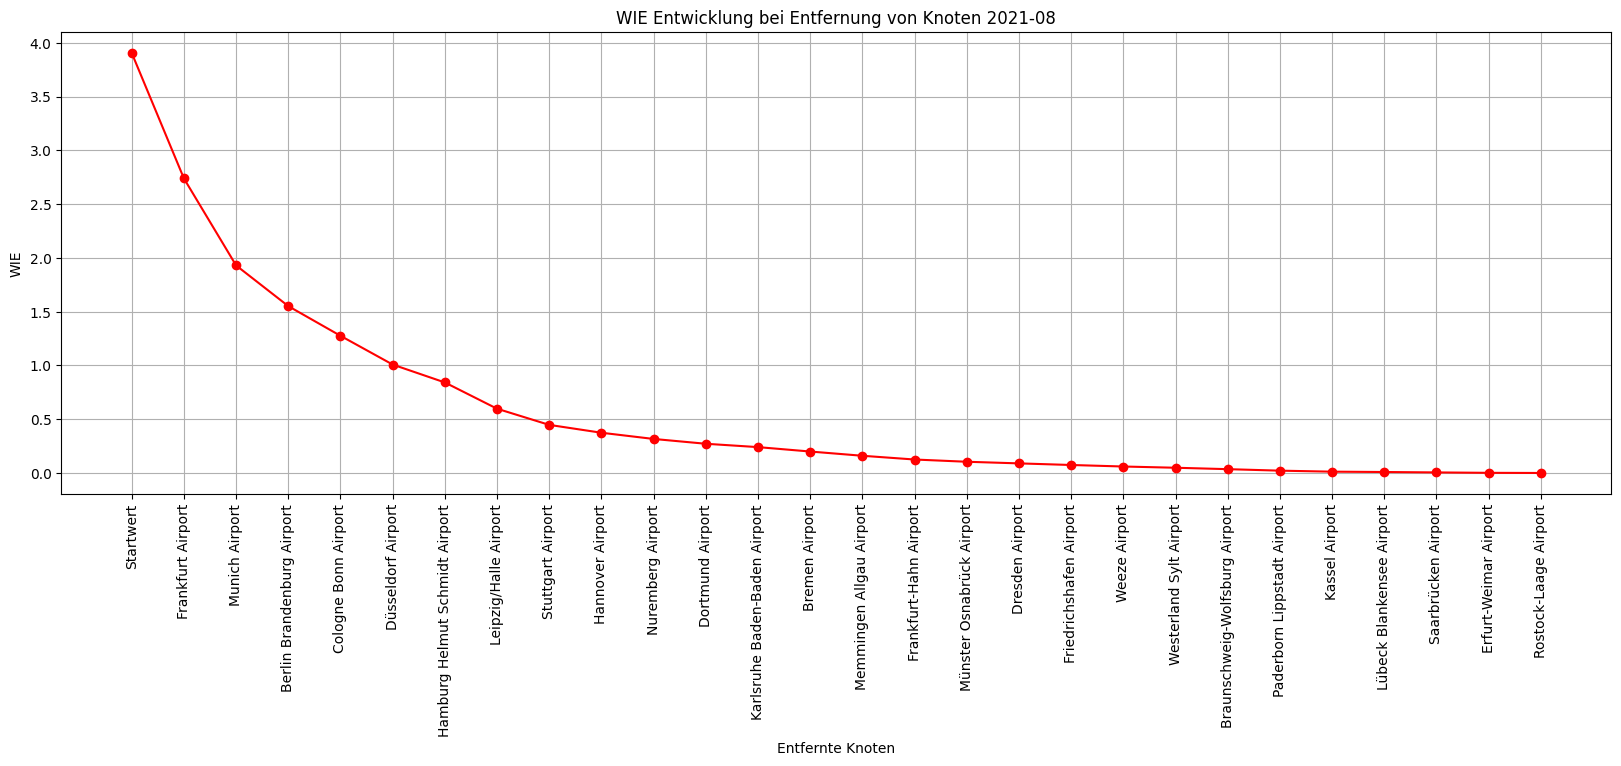

Number of nodes (airports): 1038
Number of edges (flight routes): 6444, sum of weights (flights) 49204.0
Found 1028 international airports to check against
Number of edges (domestic flight routes): 2222, sum of weights (domestic flights) 12593.0
Number of edges (international flight routes): 4222, sum of weights (international flights) 36611.0
WIE_post has become zero.
International robustness for 2021-09: 0.7241576998929387


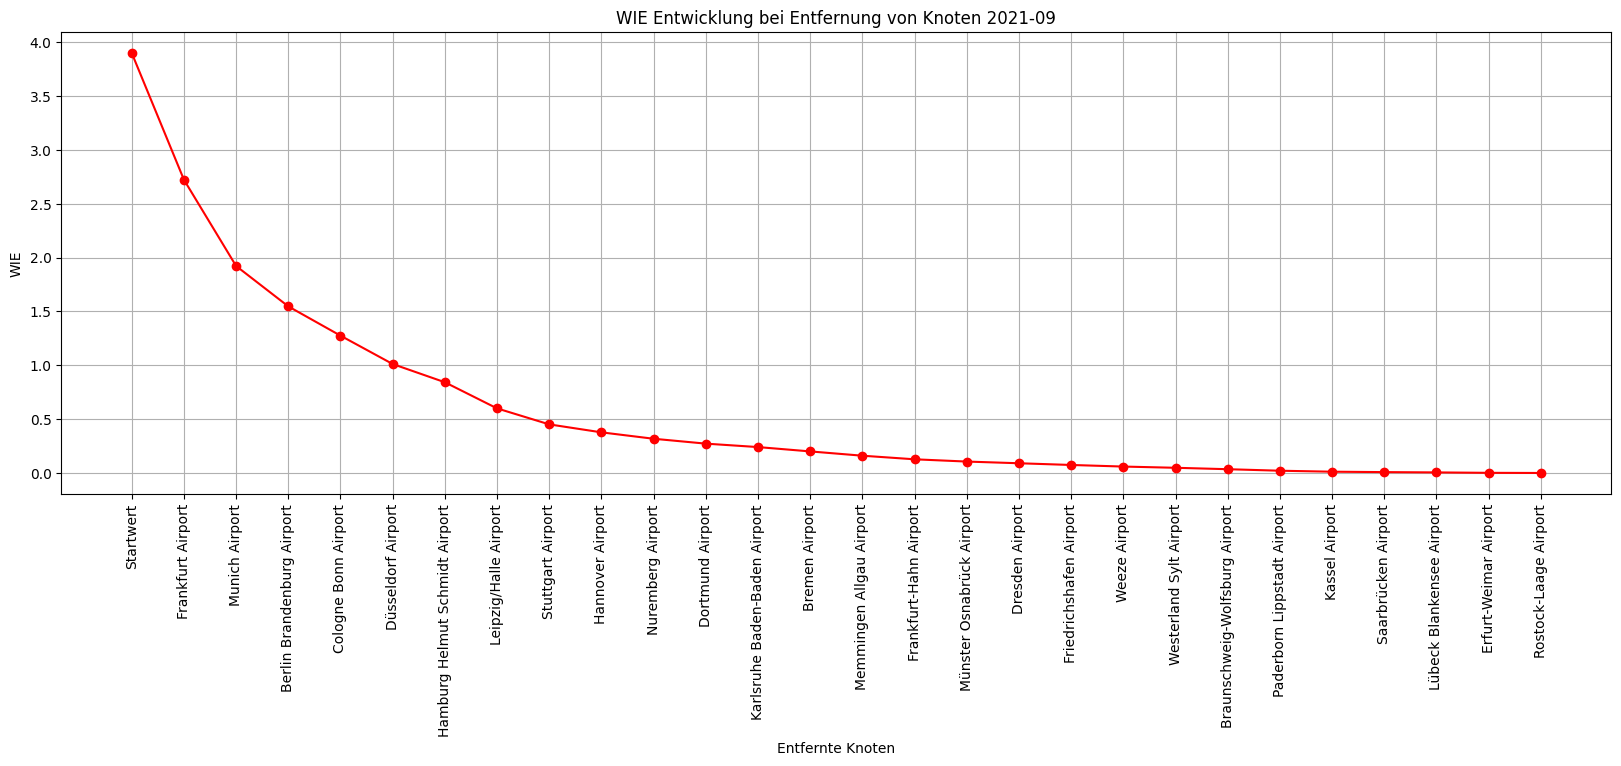

/content/drive/My Drive/2024KomplexeNetze/Daten/2021-10-01_2022-01-01_deutschland_v2.csv
Number of nodes (airports): 1127
Number of edges (flight routes): 6188, sum of weights (flights) 48464.0
Found 1028 international airports to check against
Number of edges (domestic flight routes): 2002, sum of weights (domestic flights) 12181.0
Number of edges (international flight routes): 4186, sum of weights (international flights) 36283.0
WIE_post has become zero.
International robustness for 2021-10: 0.7151601762242868


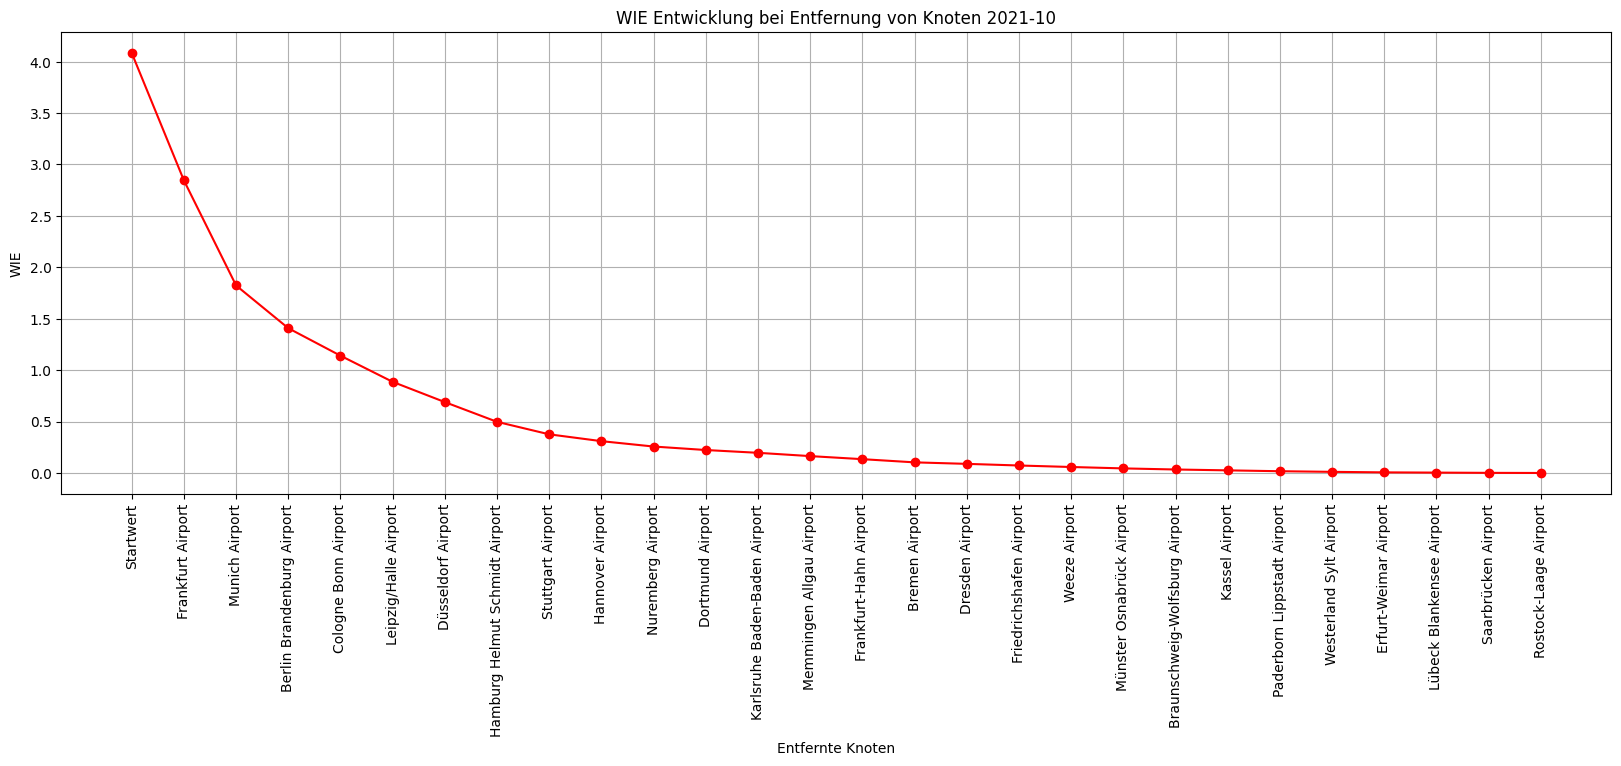

Number of nodes (airports): 846
Number of edges (flight routes): 5587, sum of weights (flights) 47621.0
Found 1028 international airports to check against
Number of edges (domestic flight routes): 1808, sum of weights (domestic flights) 11936.0
Number of edges (international flight routes): 3779, sum of weights (international flights) 35685.0
WIE_post has become zero.
International robustness for 2021-11: 0.7153220066393183


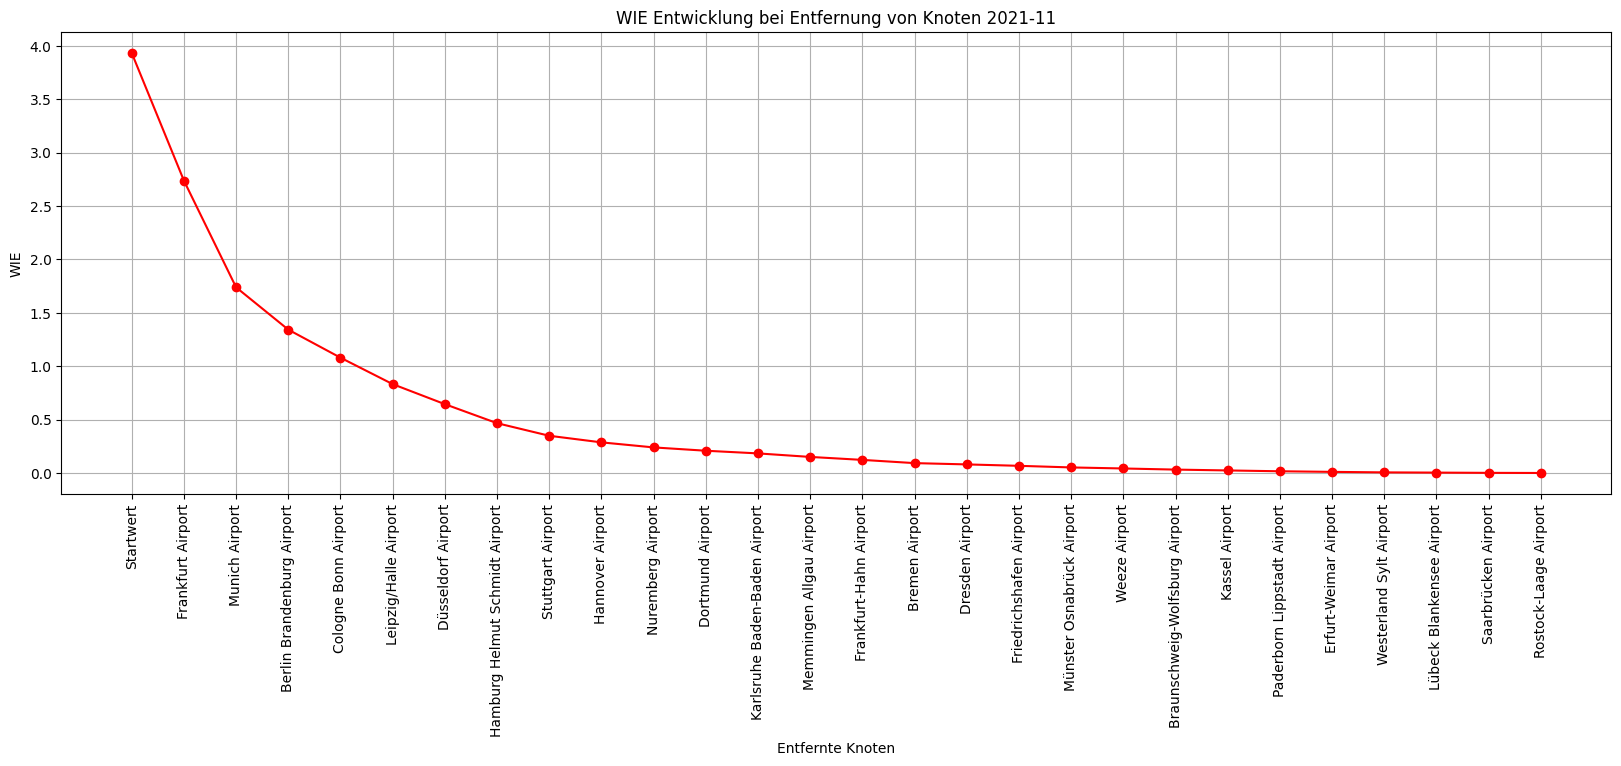

Number of nodes (airports): 825
Number of edges (flight routes): 5463, sum of weights (flights) 47487.0
Found 1028 international airports to check against
Number of edges (domestic flight routes): 1800, sum of weights (domestic flights) 11927.0
Number of edges (international flight routes): 3663, sum of weights (international flights) 35560.0
WIE_post has become zero.
International robustness for 2021-12: 0.715549264444165


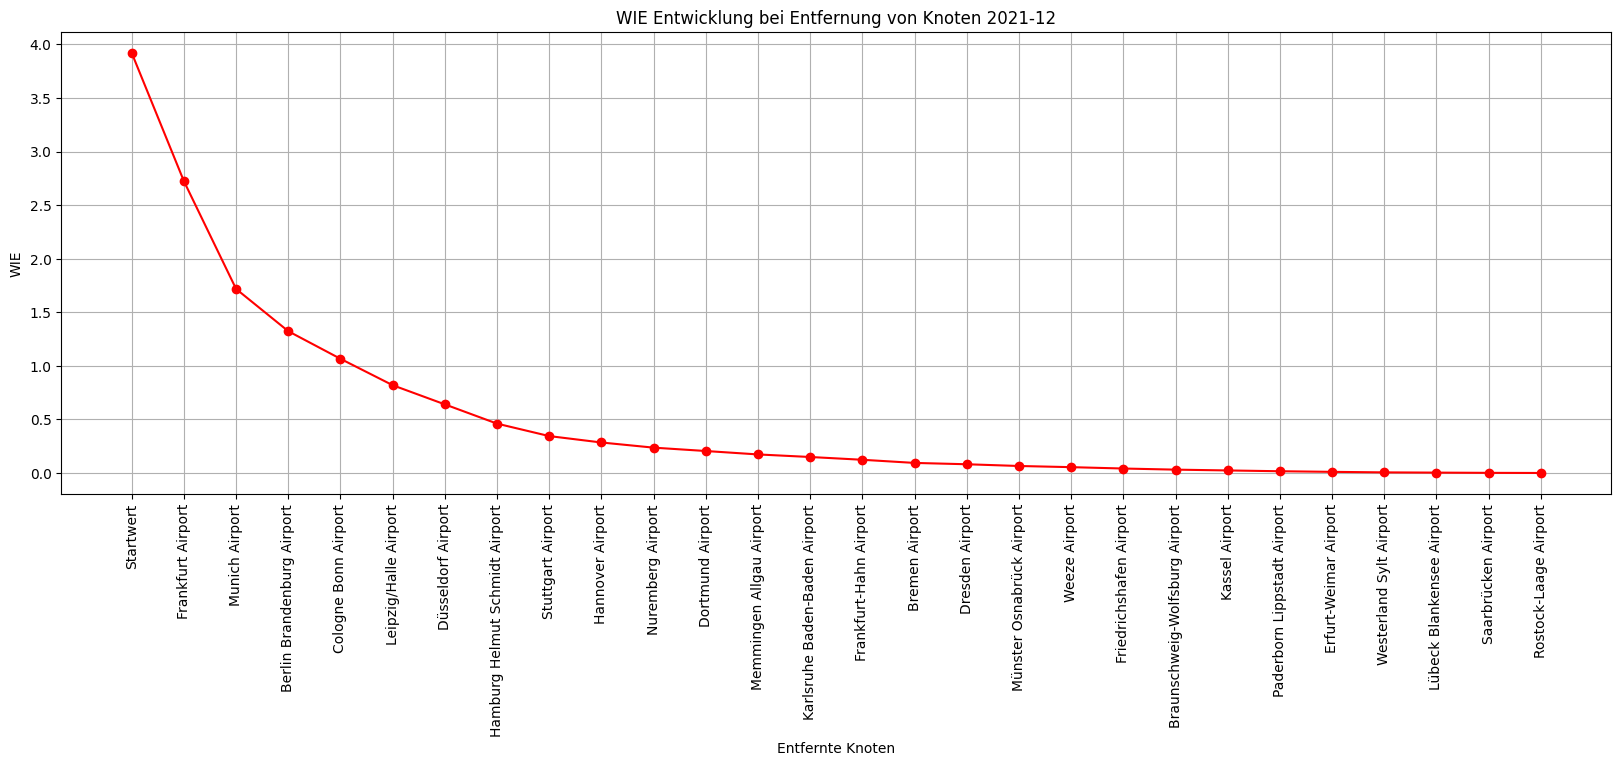

/content/drive/My Drive/2024KomplexeNetze/Daten/2023-01-01_2023-04-01_deutschland_v2.csv
Number of nodes (airports): 850
Number of edges (flight routes): 5372, sum of weights (flights) 54886.0
Found 928 international airports to check against
Number of edges (domestic flight routes): 1778, sum of weights (domestic flights) 14191.0
Number of edges (international flight routes): 3594, sum of weights (international flights) 40695.0
WIE_post has become zero.
International robustness for 2023-01: 0.7190657061427563


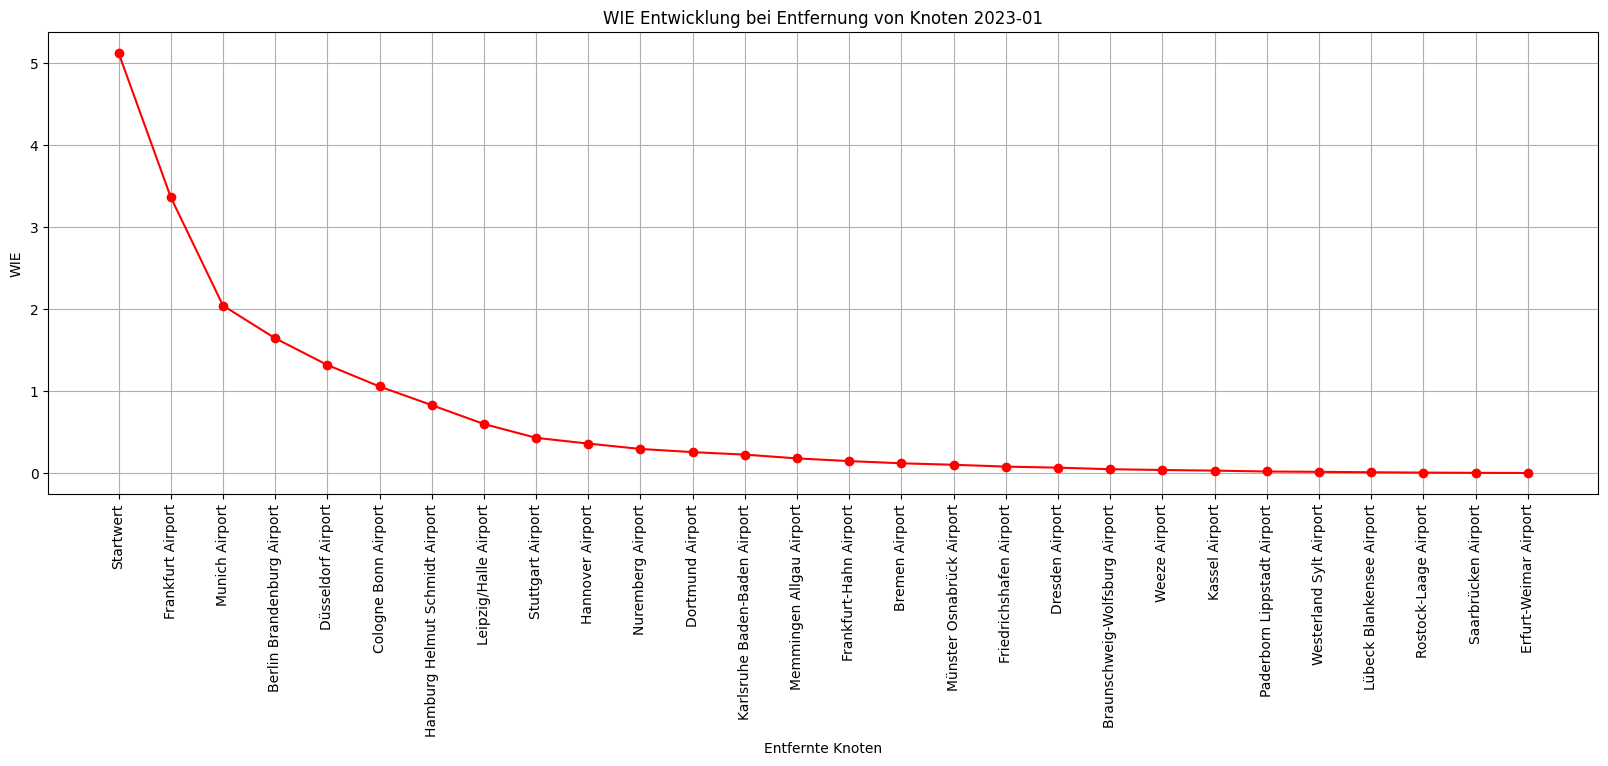

Number of nodes (airports): 858
Number of edges (flight routes): 5384, sum of weights (flights) 54949.0
Found 928 international airports to check against
Number of edges (domestic flight routes): 1795, sum of weights (domestic flights) 14219.0
Number of edges (international flight routes): 3589, sum of weights (international flights) 40730.0
WIE_post has become zero.
International robustness for 2023-02: 0.7154548982850883


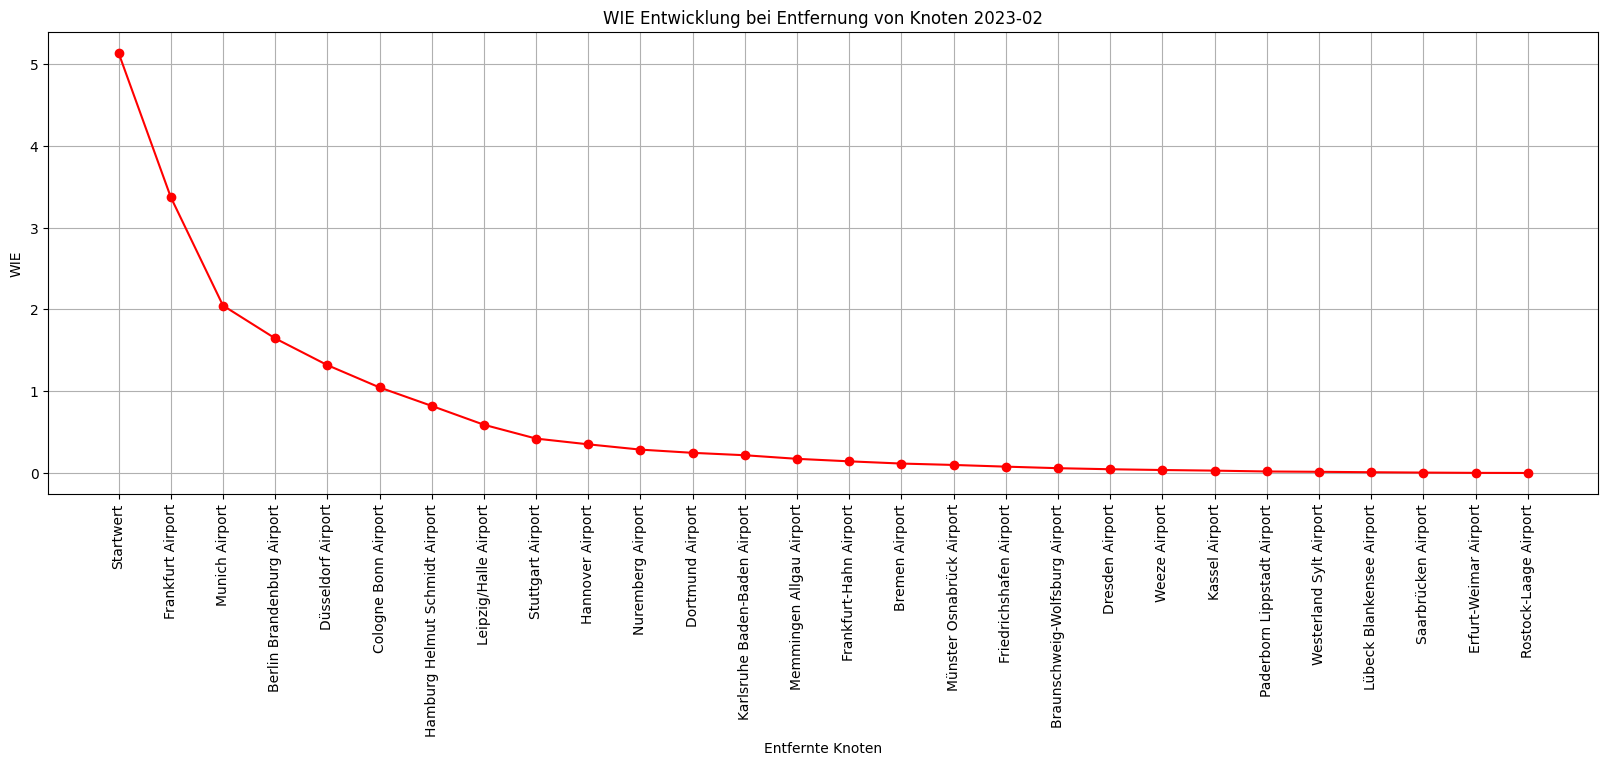

Number of nodes (airports): 942
Number of edges (flight routes): 5593, sum of weights (flights) 55431.0
Found 928 international airports to check against
Number of edges (domestic flight routes): 1828, sum of weights (domestic flights) 14276.0
Number of edges (international flight routes): 3765, sum of weights (international flights) 41155.0
WIE_post has become zero.
International robustness for 2023-03: 0.7196444680396245


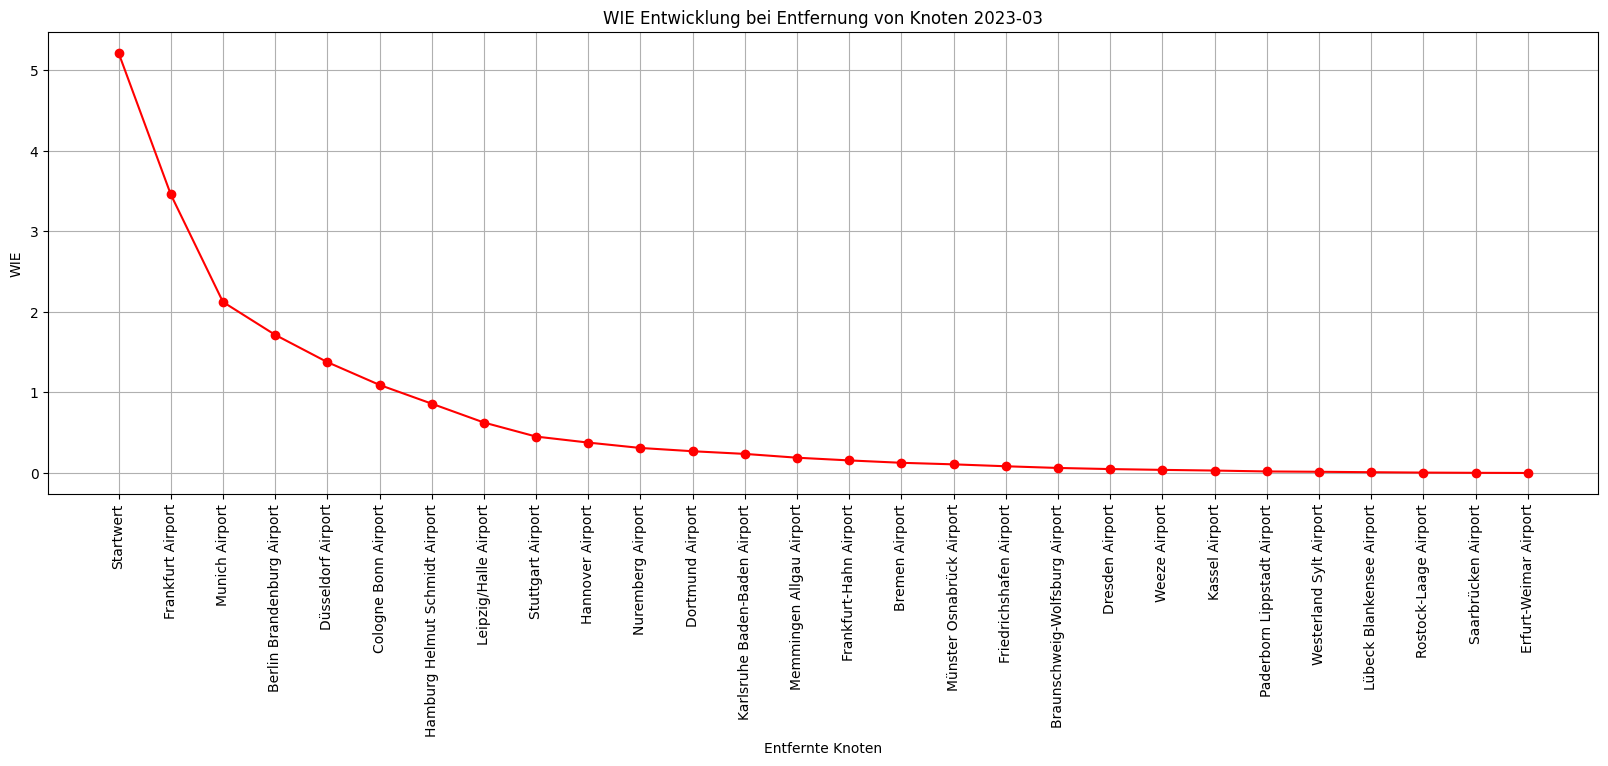

/content/drive/My Drive/2024KomplexeNetze/Daten/2023-04-01_2023-07-01_deutschland_v2.csv
Number of nodes (airports): 1049
Number of edges (flight routes): 6941, sum of weights (flights) 66597.0
Found 1110 international airports to check against
Number of edges (domestic flight routes): 2428, sum of weights (domestic flights) 16017.0
Number of edges (international flight routes): 4513, sum of weights (international flights) 50580.0
WIE_post has become zero.
International robustness for 2023-04: 0.7184690838059756


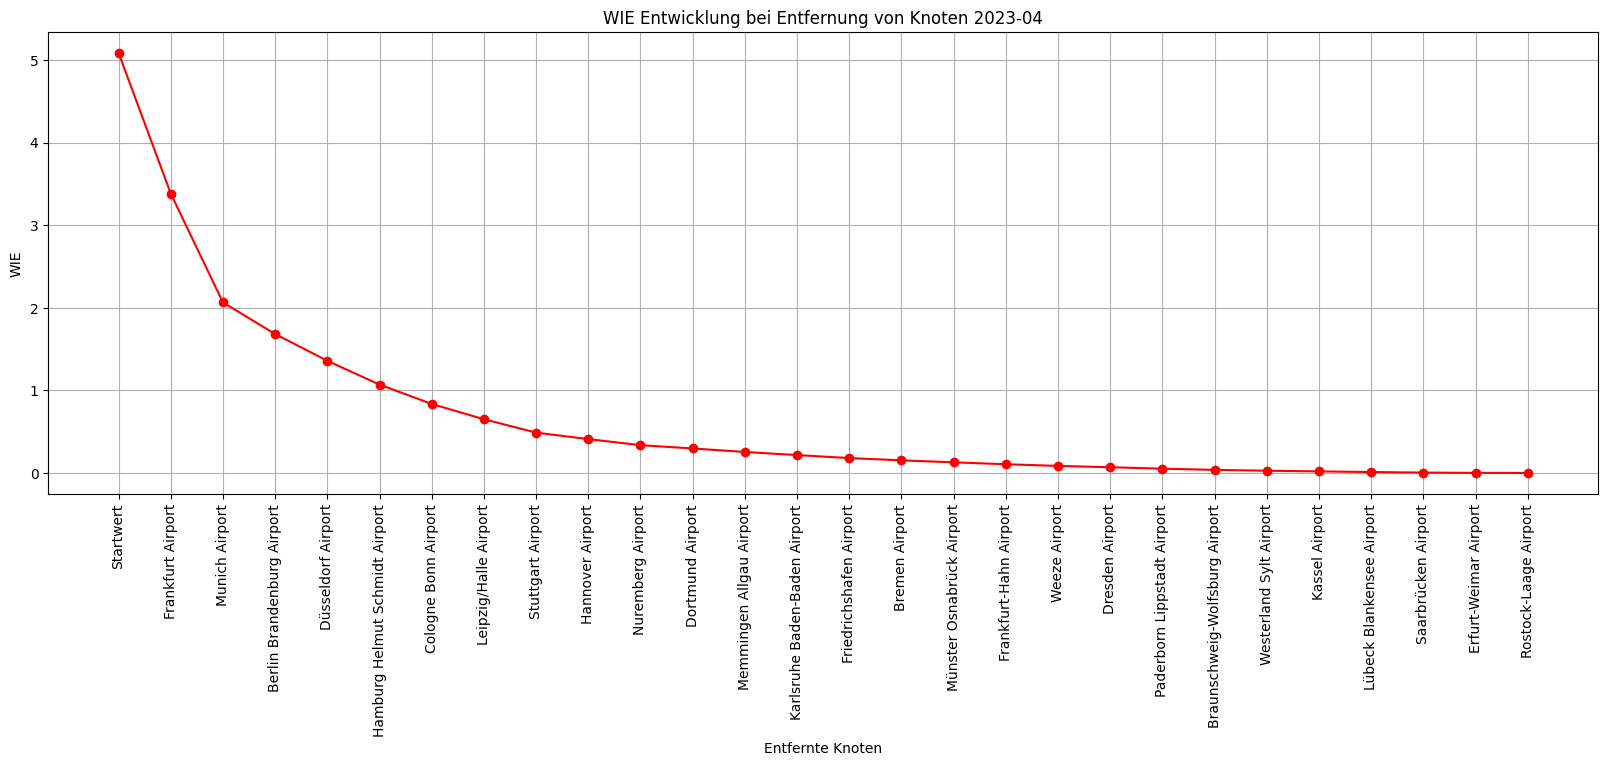

Number of nodes (airports): 1075
Number of edges (flight routes): 7087, sum of weights (flights) 67269.0
Found 1110 international airports to check against
Number of edges (domestic flight routes): 2454, sum of weights (domestic flights) 16041.0
Number of edges (international flight routes): 4633, sum of weights (international flights) 51228.0
WIE_post has become zero.
International robustness for 2023-05: 0.7195109571184624


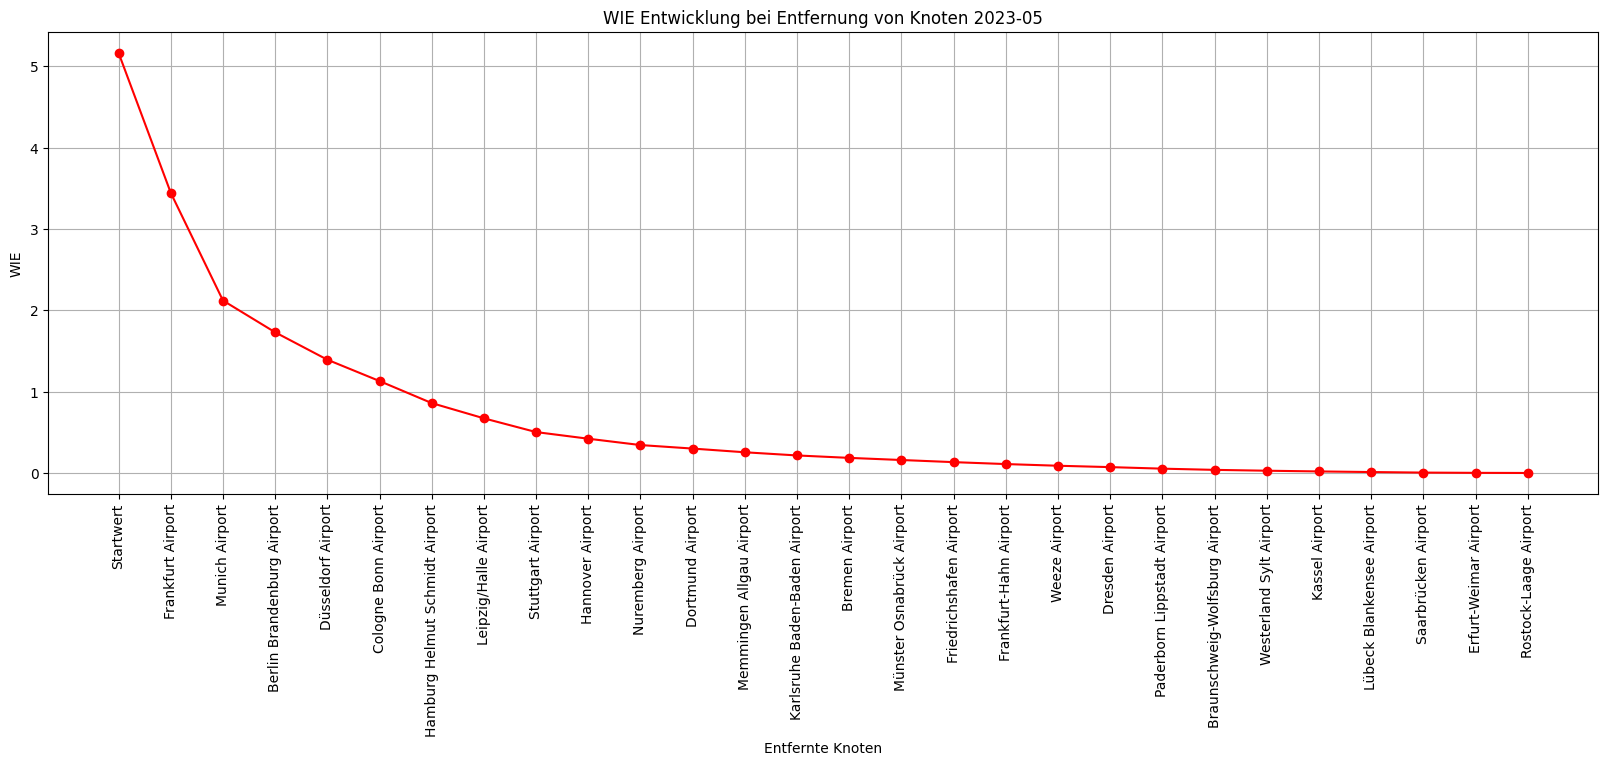

Number of nodes (airports): 1139
Number of edges (flight routes): 7176, sum of weights (flights) 67347.0
Found 1110 international airports to check against
Number of edges (domestic flight routes): 2475, sum of weights (domestic flights) 16074.0
Number of edges (international flight routes): 4701, sum of weights (international flights) 51273.0
WIE_post has become zero.
International robustness for 2023-06: 0.7190186429636372


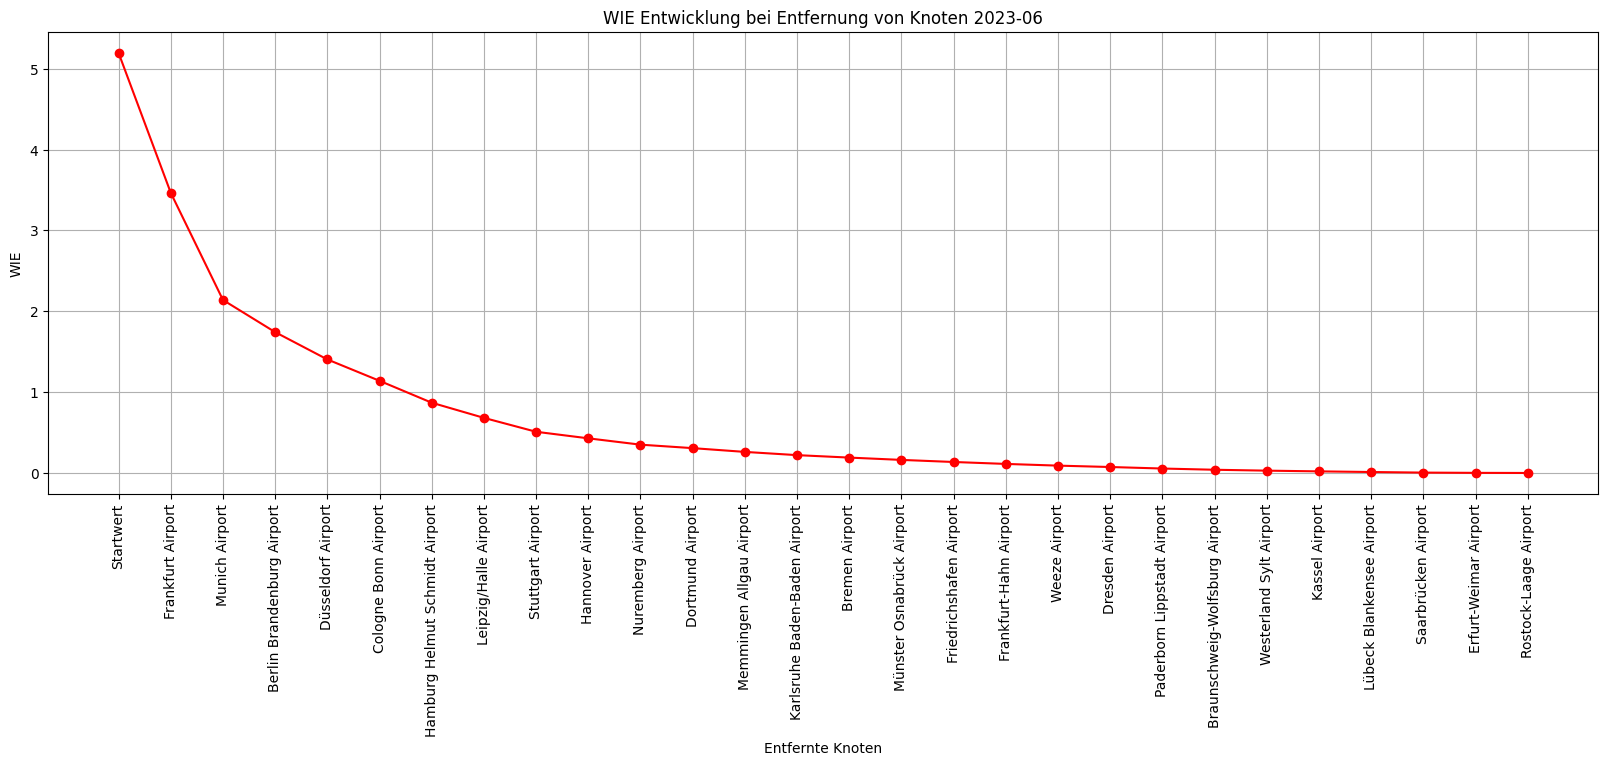

/content/drive/My Drive/2024KomplexeNetze/Daten/2023-07-01_2023-10-01_deutschland_v2.csv
Number of nodes (airports): 1120
Number of edges (flight routes): 7304, sum of weights (flights) 70346.0
Found 1109 international airports to check against
Number of edges (domestic flight routes): 2469, sum of weights (domestic flights) 16705.0
Number of edges (international flight routes): 4835, sum of weights (international flights) 53641.0
WIE_post has become zero.
International robustness for 2023-07: 0.7220887380425951


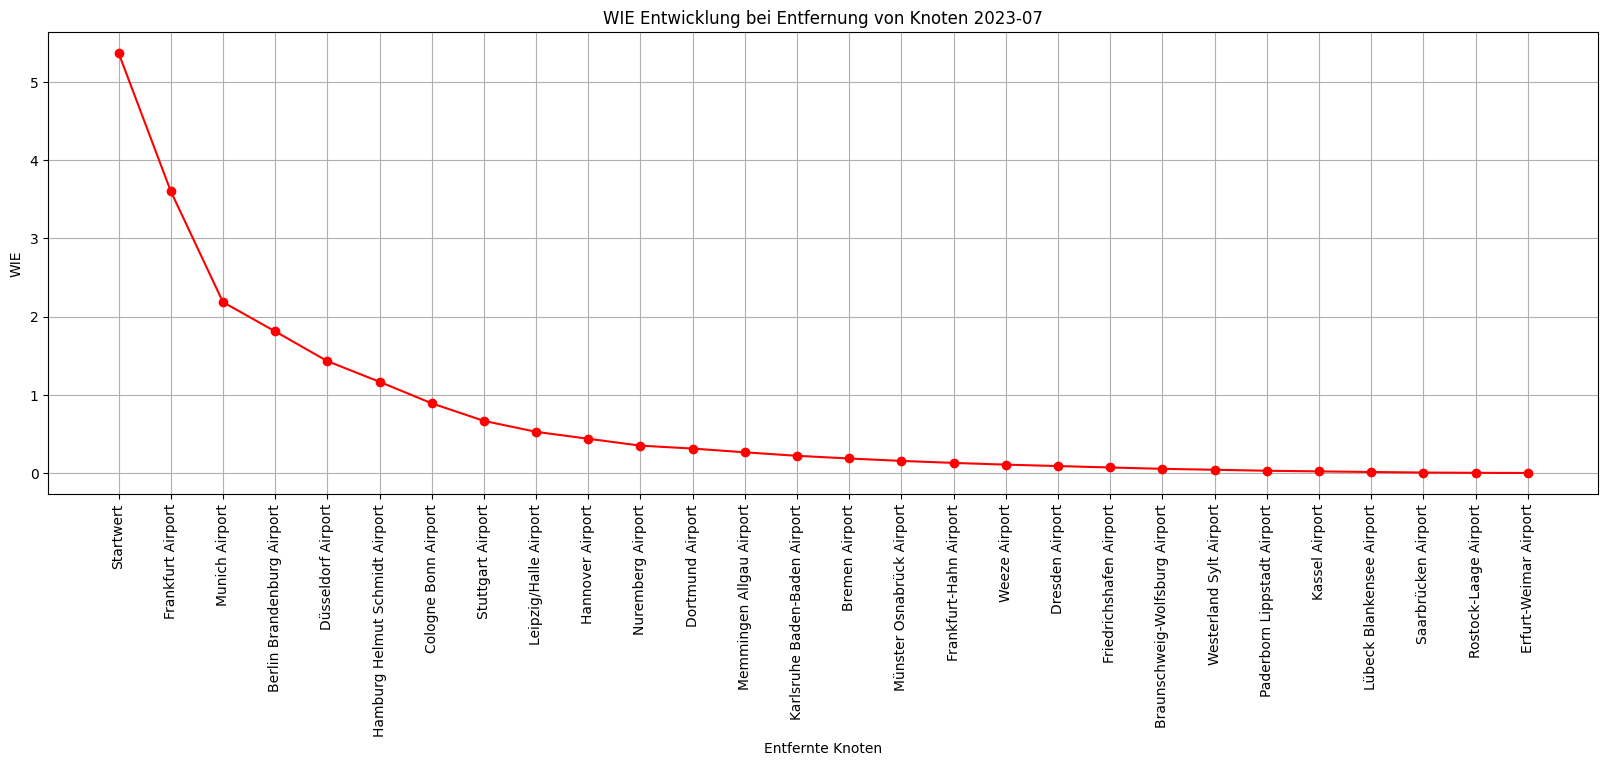

Number of nodes (airports): 1099
Number of edges (flight routes): 7296, sum of weights (flights) 70531.0
Found 1109 international airports to check against
Number of edges (domestic flight routes): 2433, sum of weights (domestic flights) 16670.0
Number of edges (international flight routes): 4863, sum of weights (international flights) 53861.0
WIE_post has become zero.
International robustness for 2023-08: 0.722252463325723


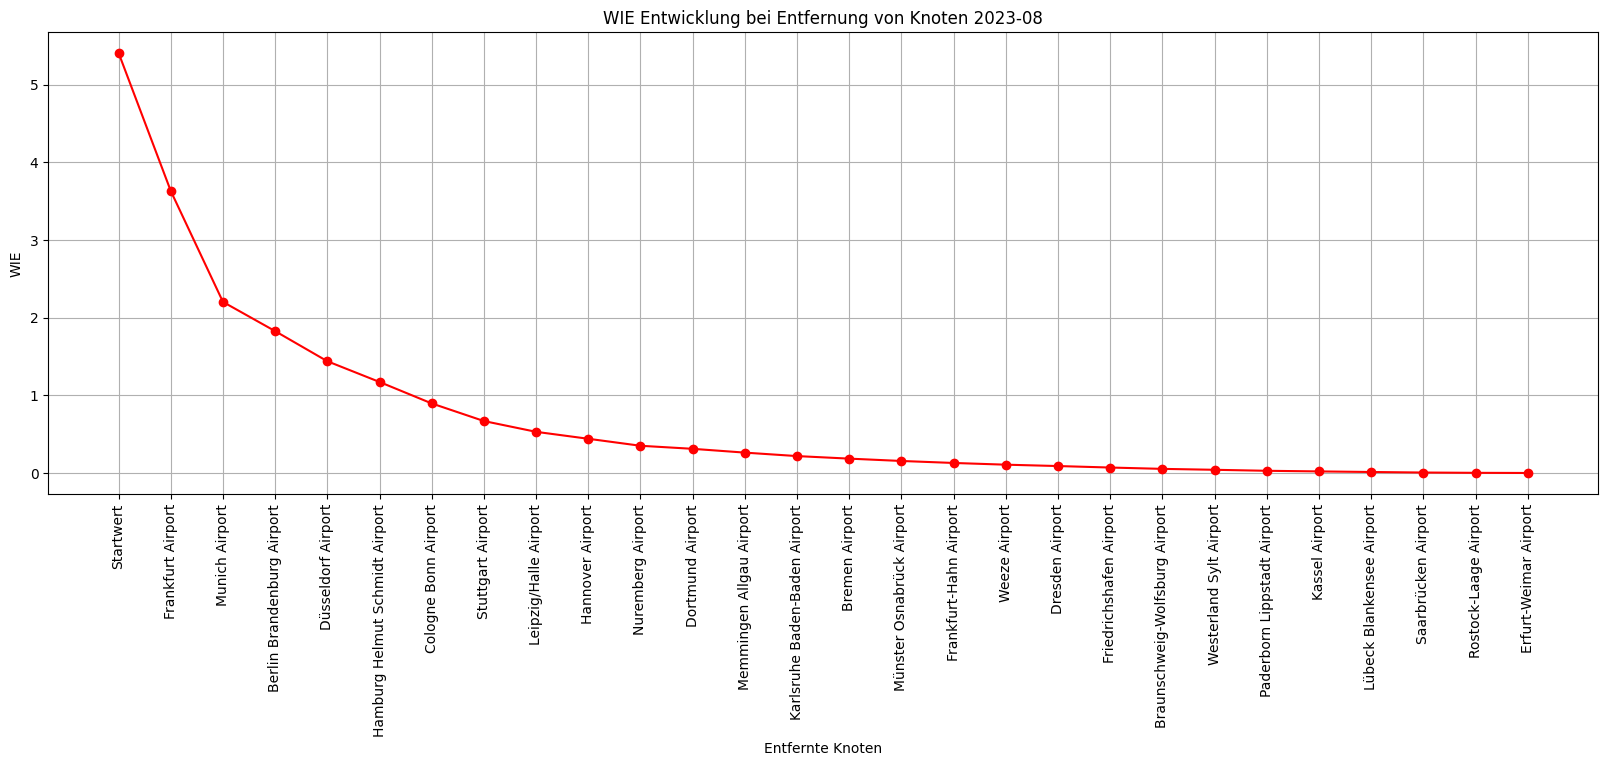

Number of nodes (airports): 1113
Number of edges (flight routes): 7290, sum of weights (flights) 70399.0
Found 1109 international airports to check against
Number of edges (domestic flight routes): 2477, sum of weights (domestic flights) 16719.0
Number of edges (international flight routes): 4813, sum of weights (international flights) 53680.0
WIE_post has become zero.
International robustness for 2023-09: 0.7225671685326509


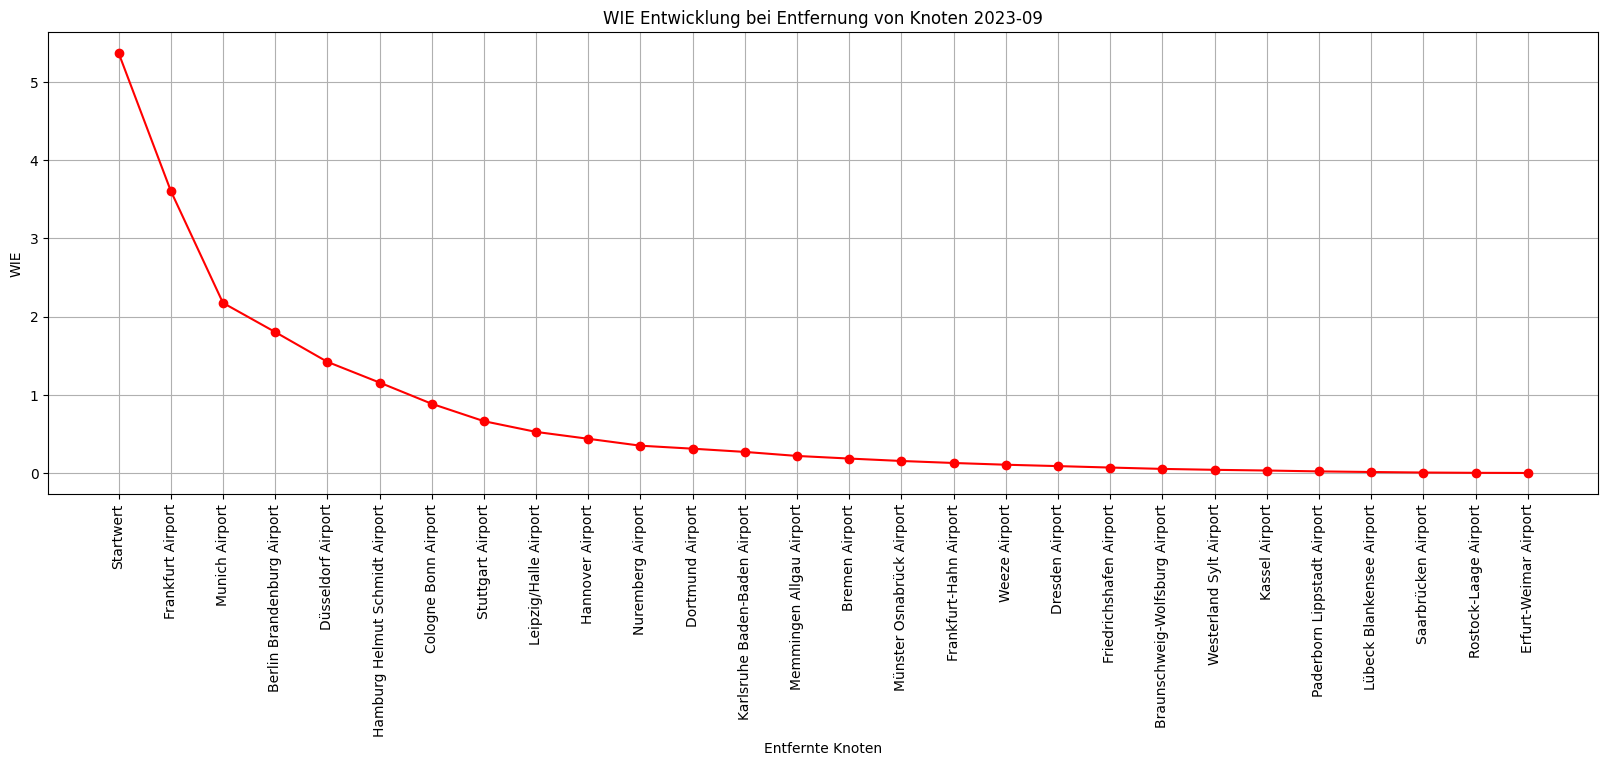

/content/drive/My Drive/2024KomplexeNetze/Daten/2023-10-01_2024-01-01_deutschland_v2.csv
Number of nodes (airports): 1106
Number of edges (flight routes): 6100, sum of weights (flights) 49378.0
Found 1012 international airports to check against
Number of edges (domestic flight routes): 1914, sum of weights (domestic flights) 11437.0
Number of edges (international flight routes): 4186, sum of weights (international flights) 37941.0
WIE_post has become zero.
International robustness for 2023-10: 0.7189998017117112


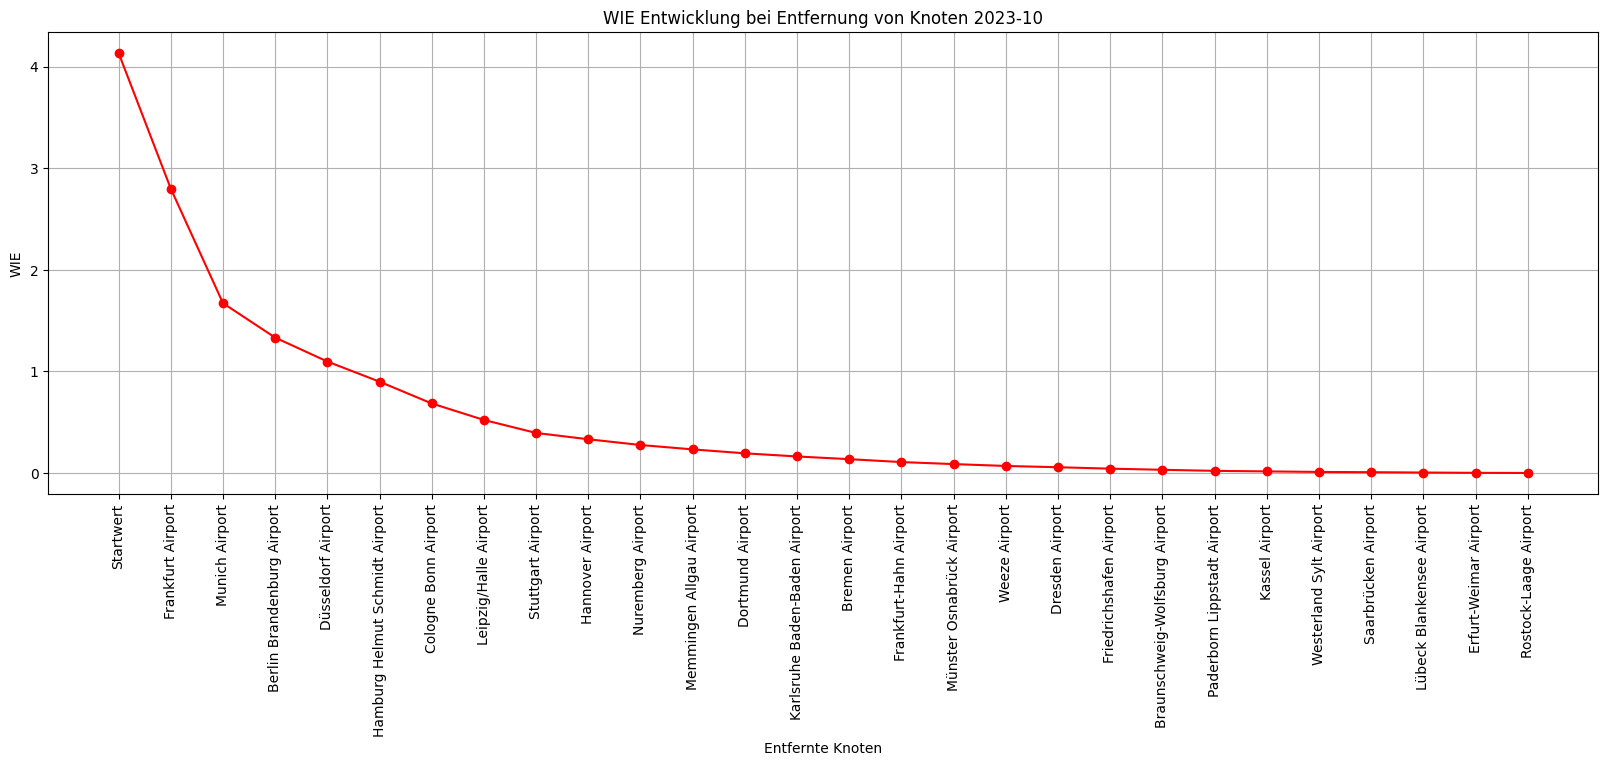

Number of nodes (airports): 893
Number of edges (flight routes): 5616, sum of weights (flights) 48330.0
Found 1012 international airports to check against
Number of edges (domestic flight routes): 1772, sum of weights (domestic flights) 11232.0
Number of edges (international flight routes): 3844, sum of weights (international flights) 37098.0
WIE_post has become zero.
International robustness for 2023-11: 0.7190284397016945


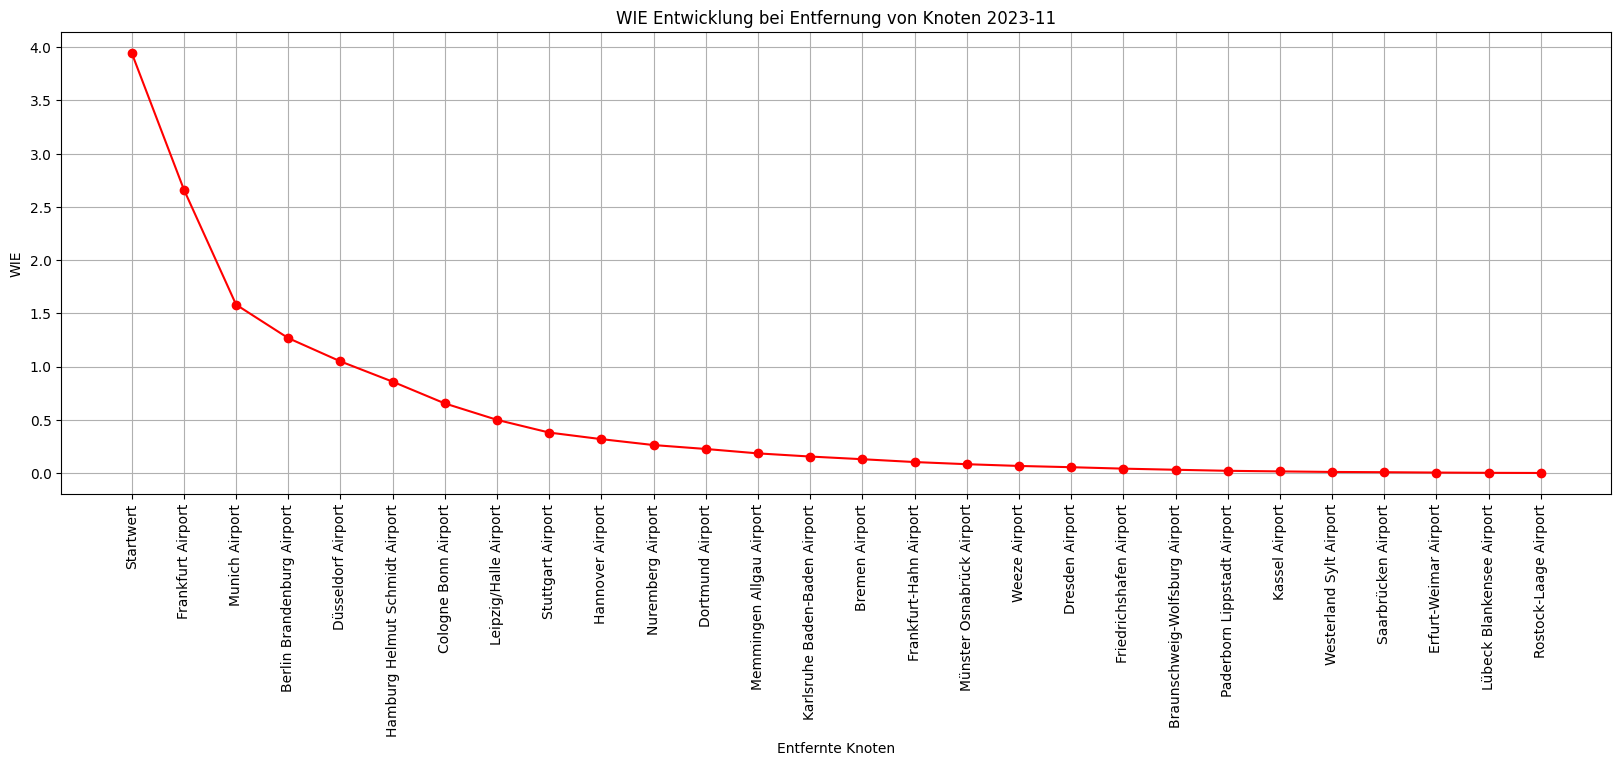

Number of nodes (airports): 812
Number of edges (flight routes): 5431, sum of weights (flights) 48096.0
Found 1012 international airports to check against
Number of edges (domestic flight routes): 1723, sum of weights (domestic flights) 11139.0
Number of edges (international flight routes): 3708, sum of weights (international flights) 36957.0
WIE_post has become zero.
International robustness for 2023-12: 0.7177406341201477


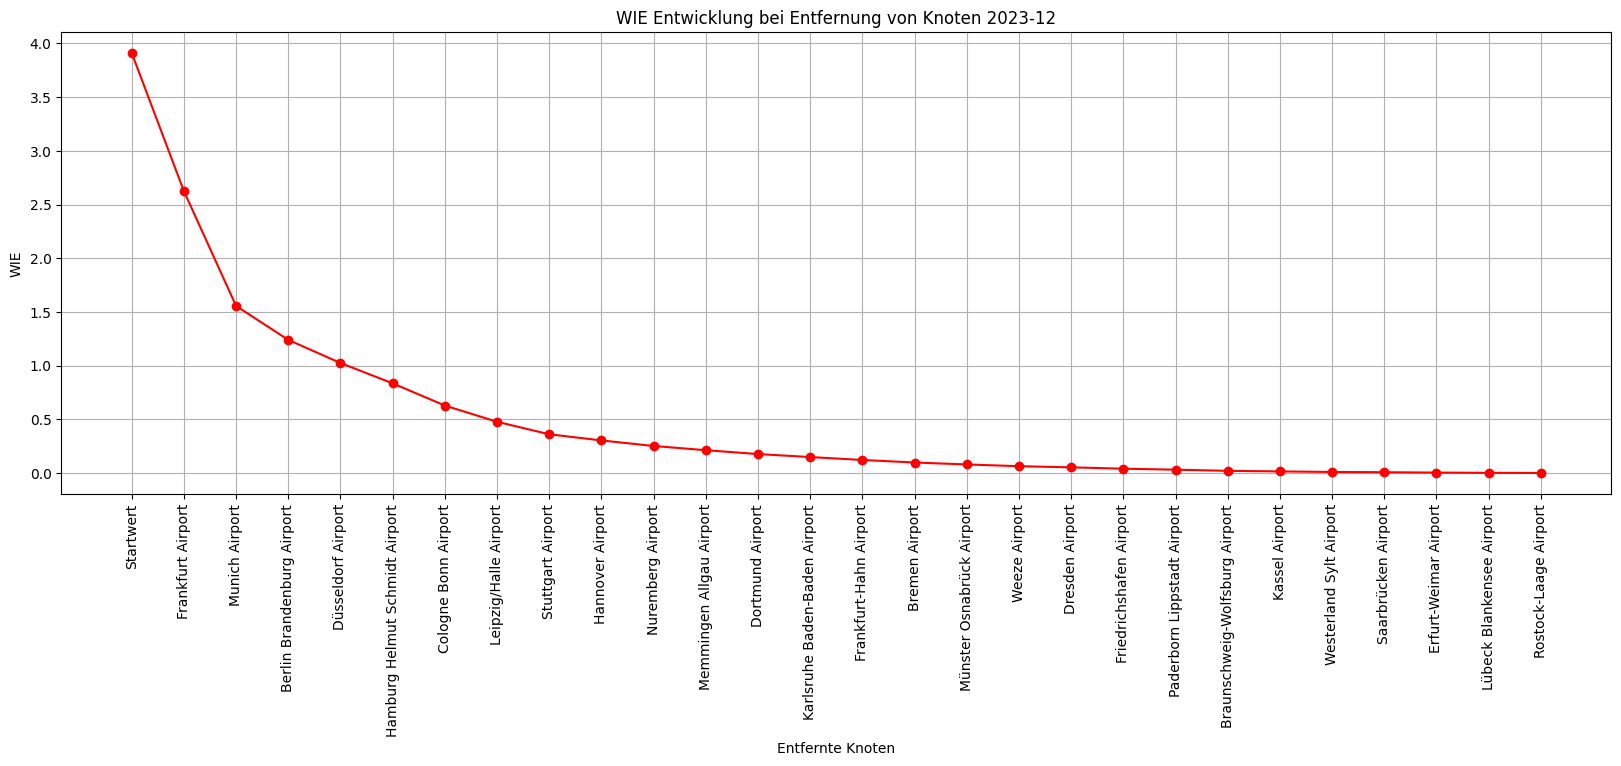

/content/drive/My Drive/2024KomplexeNetze/Daten/2024-01-01_2024-04-01_deutschland_v2.csv
Number of nodes (airports): 892
Number of edges (flight routes): 5564, sum of weights (flights) 54618.0
Found 968 international airports to check against
Number of edges (domestic flight routes): 1892, sum of weights (domestic flights) 14025.0
Number of edges (international flight routes): 3672, sum of weights (international flights) 40593.0
WIE_post has become zero.
International robustness for 2024-01: 0.723536414326049


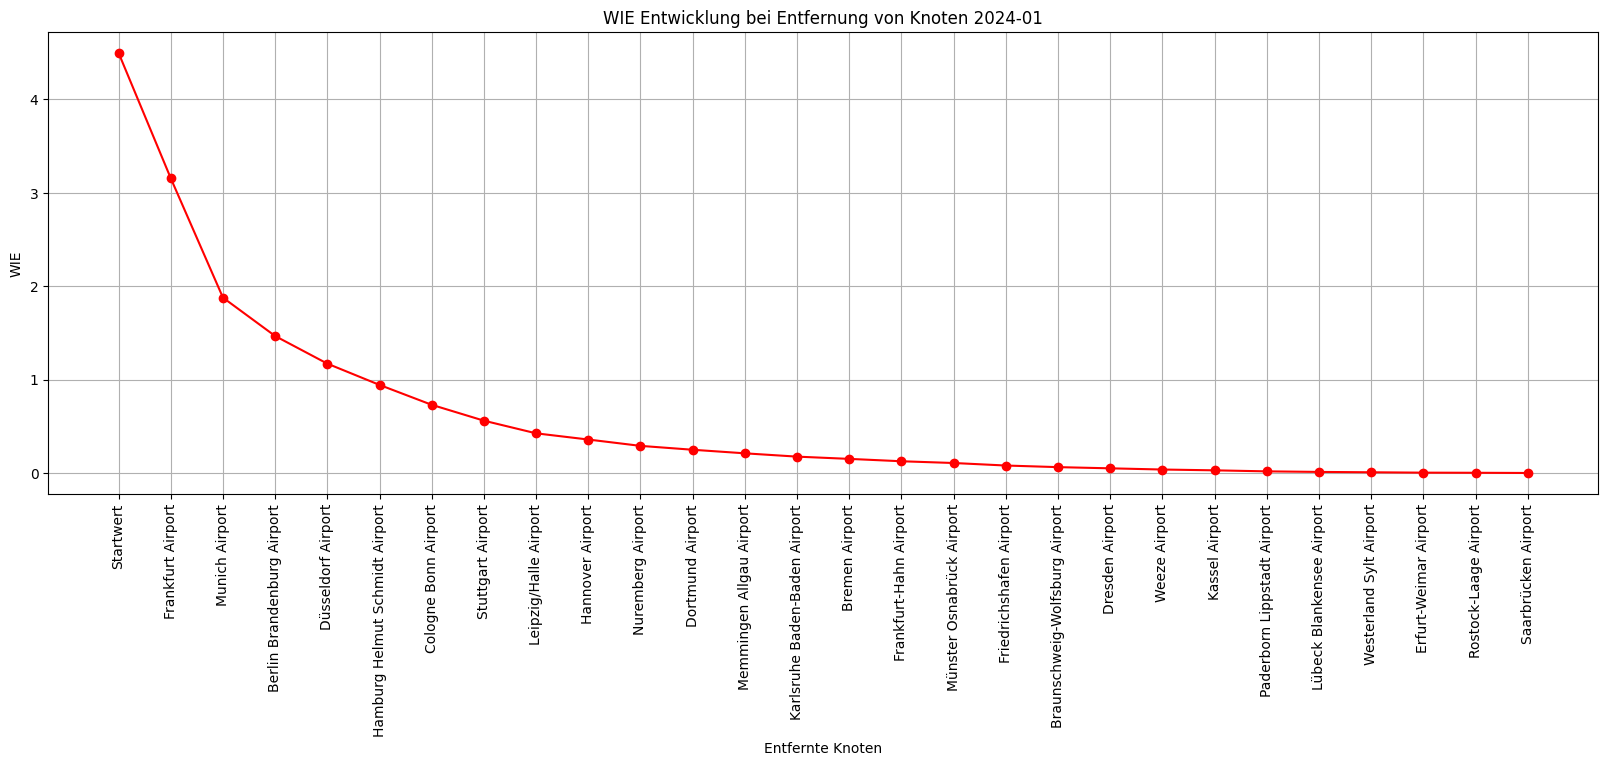

Number of nodes (airports): 907
Number of edges (flight routes): 5564, sum of weights (flights) 54677.0
Found 968 international airports to check against
Number of edges (domestic flight routes): 1869, sum of weights (domestic flights) 13998.0
Number of edges (international flight routes): 3695, sum of weights (international flights) 40679.0
WIE_post has become zero.
International robustness for 2024-02: 0.7230235043874179


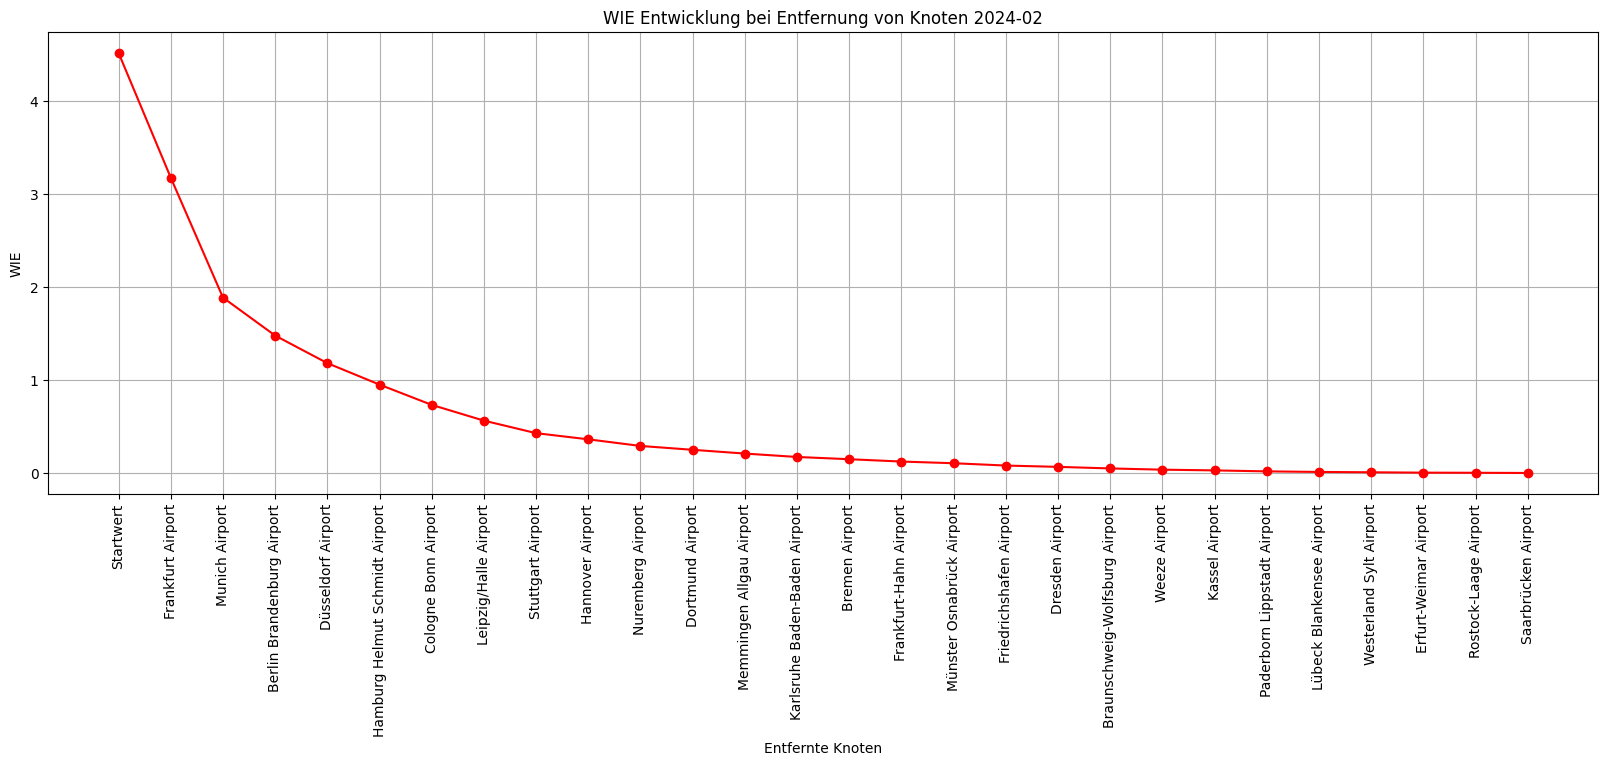

Number of nodes (airports): 995
Number of edges (flight routes): 5743, sum of weights (flights) 54923.0
Found 968 international airports to check against
Number of edges (domestic flight routes): 1965, sum of weights (domestic flights) 14128.0
Number of edges (international flight routes): 3778, sum of weights (international flights) 40795.0
WIE_post has become zero.
International robustness for 2024-03: 0.7245217871771277


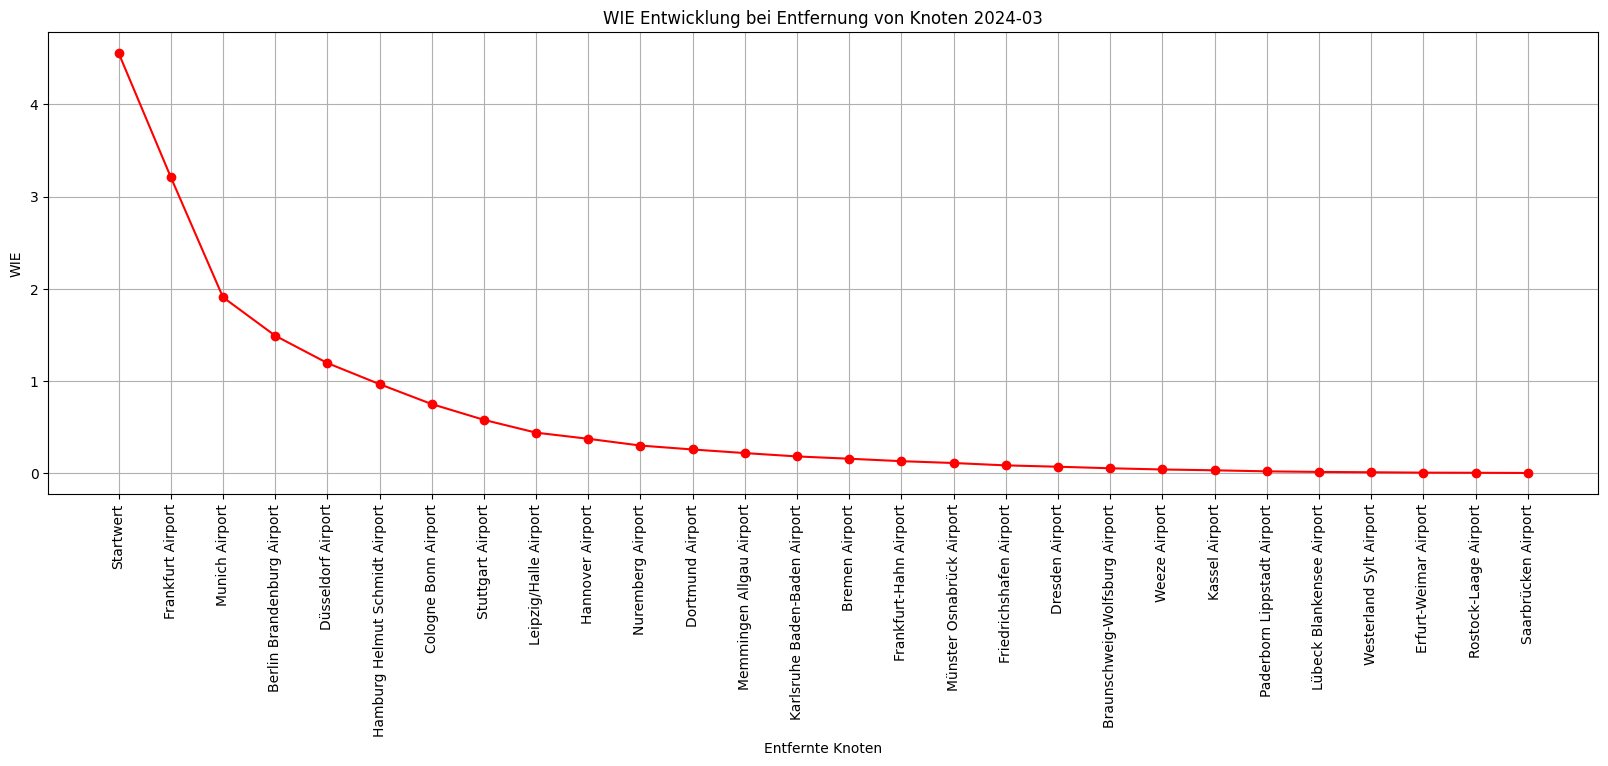

/content/drive/My Drive/2024KomplexeNetze/Daten/2024-04-01_2024-07-01_deutschland_v2.csv
Number of nodes (airports): 1066
Number of edges (flight routes): 7011, sum of weights (flights) 65518.0
Found 1157 international airports to check against
Number of edges (domestic flight routes): 2439, sum of weights (domestic flights) 16054.0
Number of edges (international flight routes): 4572, sum of weights (international flights) 49464.0
WIE_post has become zero.
International robustness for 2024-04: 0.7300029887924054


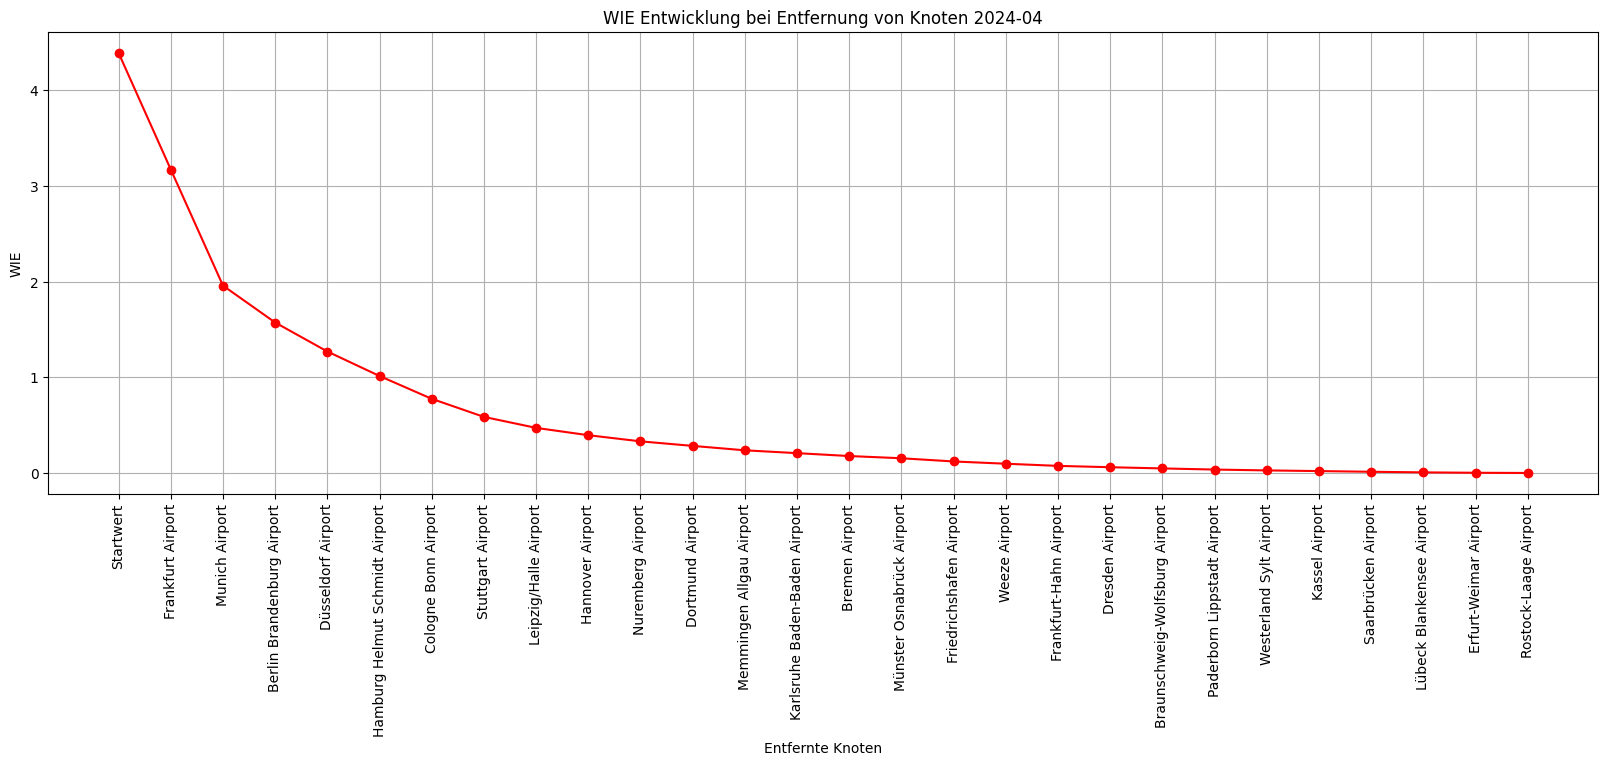

Number of nodes (airports): 1104
Number of edges (flight routes): 7186, sum of weights (flights) 66031.0
Found 1157 international airports to check against
Number of edges (domestic flight routes): 2468, sum of weights (domestic flights) 16106.0
Number of edges (international flight routes): 4718, sum of weights (international flights) 49925.0
WIE_post has become zero.
International robustness for 2024-05: 0.7287596073023791


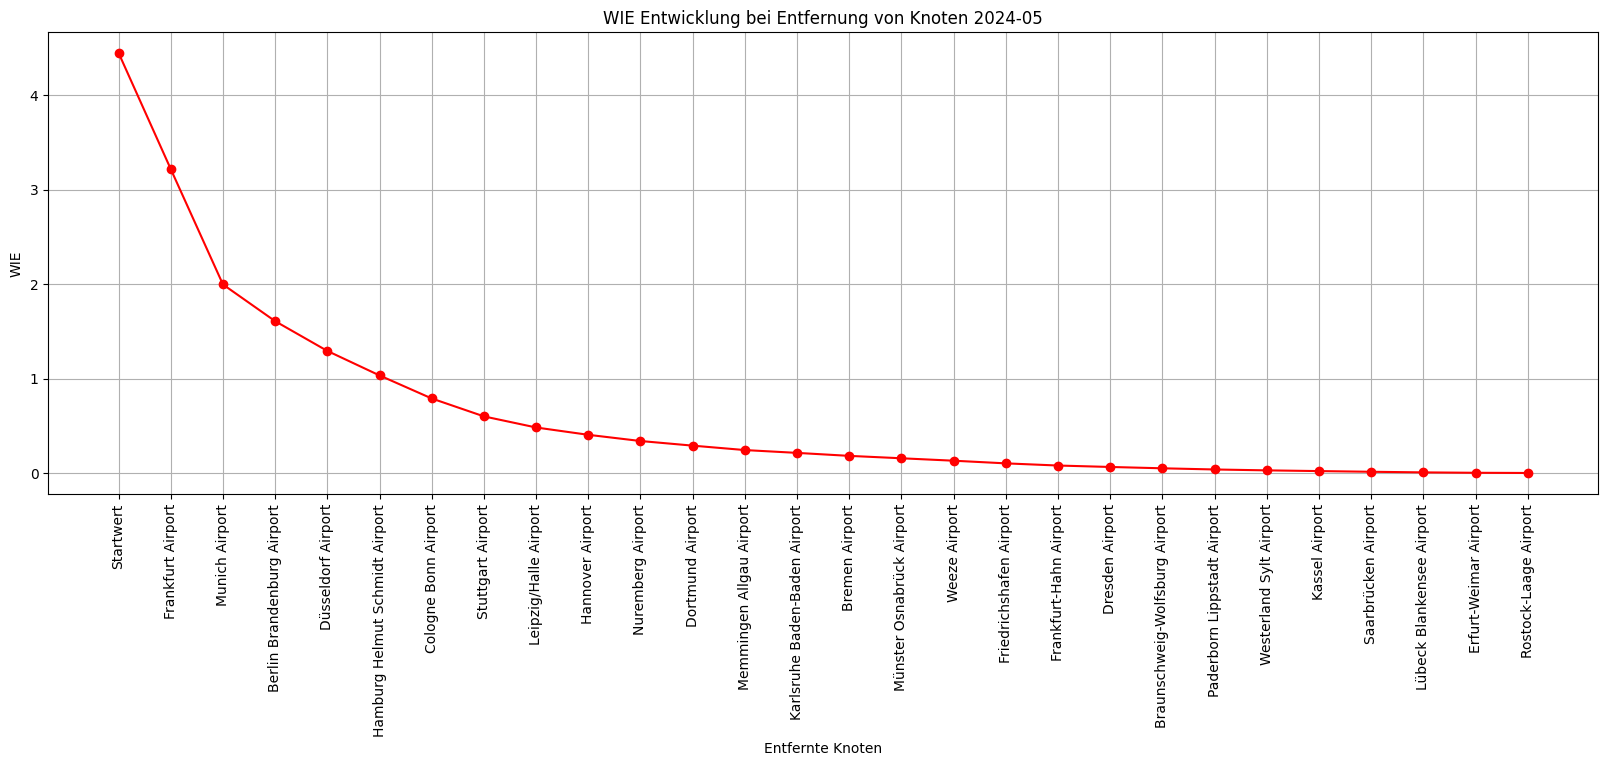

Number of nodes (airports): 1181
Number of edges (flight routes): 7358, sum of weights (flights) 66256.0
Found 1157 international airports to check against
Number of edges (domestic flight routes): 2524, sum of weights (domestic flights) 16179.0
Number of edges (international flight routes): 4834, sum of weights (international flights) 50077.0
WIE_post has become zero.
International robustness for 2024-06: 0.7283843279765626


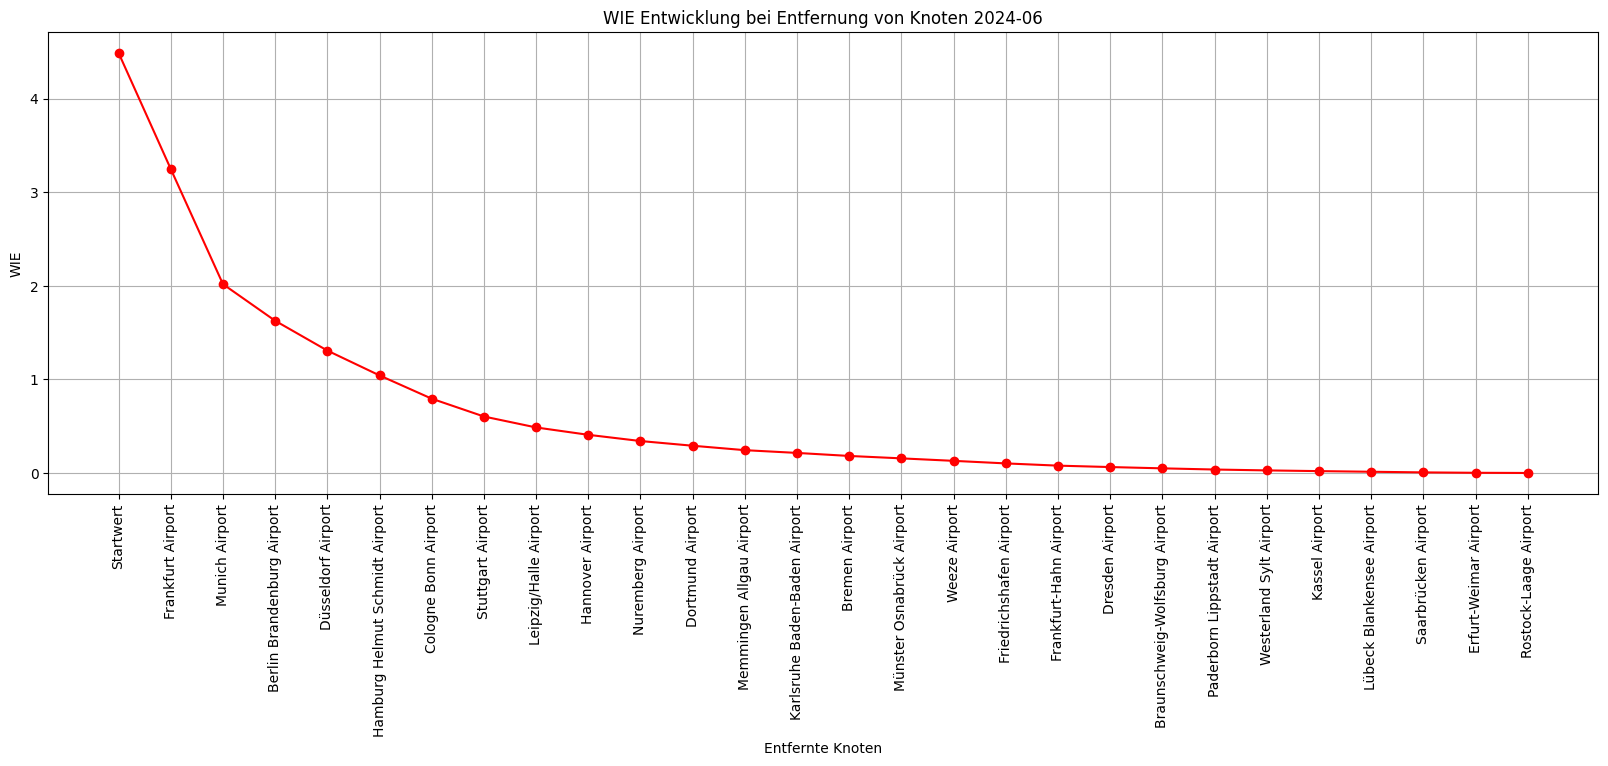

/content/drive/My Drive/2024KomplexeNetze/Daten/2024-07-01_2024-10-01_deutschland_v2.csv
Number of nodes (airports): 1121
Number of edges (flight routes): 7311, sum of weights (flights) 72623.0
Found 1112 international airports to check against
Number of edges (domestic flight routes): 2468, sum of weights (domestic flights) 16273.0
Number of edges (international flight routes): 4843, sum of weights (international flights) 56350.0
WIE_post has become zero.
International robustness for 2024-07: 0.7349589391543954


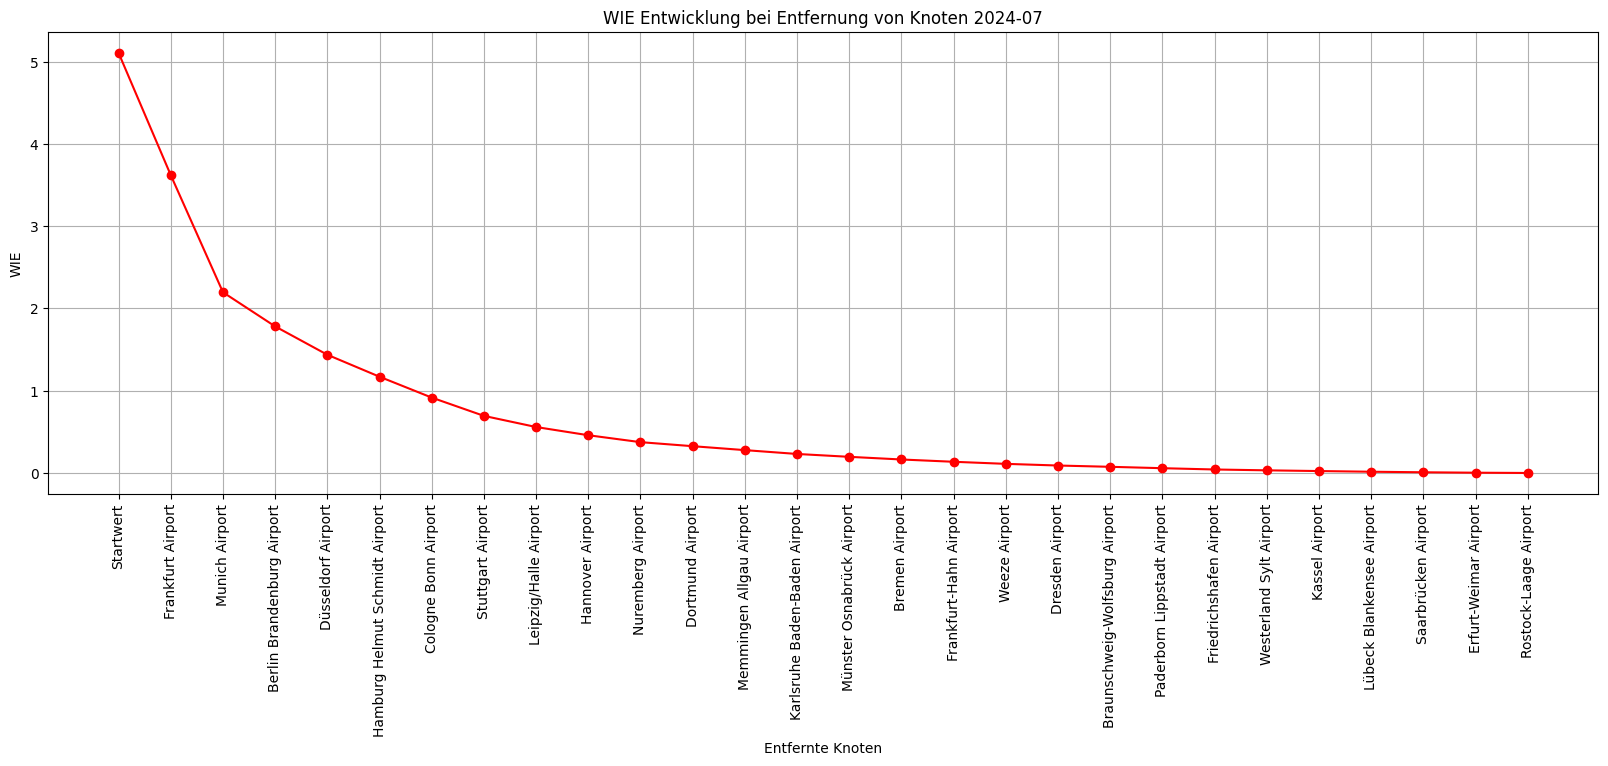

Number of nodes (airports): 1106
Number of edges (flight routes): 7289, sum of weights (flights) 72854.0
Found 1112 international airports to check against
Number of edges (domestic flight routes): 2475, sum of weights (domestic flights) 16280.0
Number of edges (international flight routes): 4814, sum of weights (international flights) 56574.0
WIE_post has become zero.
International robustness for 2024-08: 0.7355833828264735


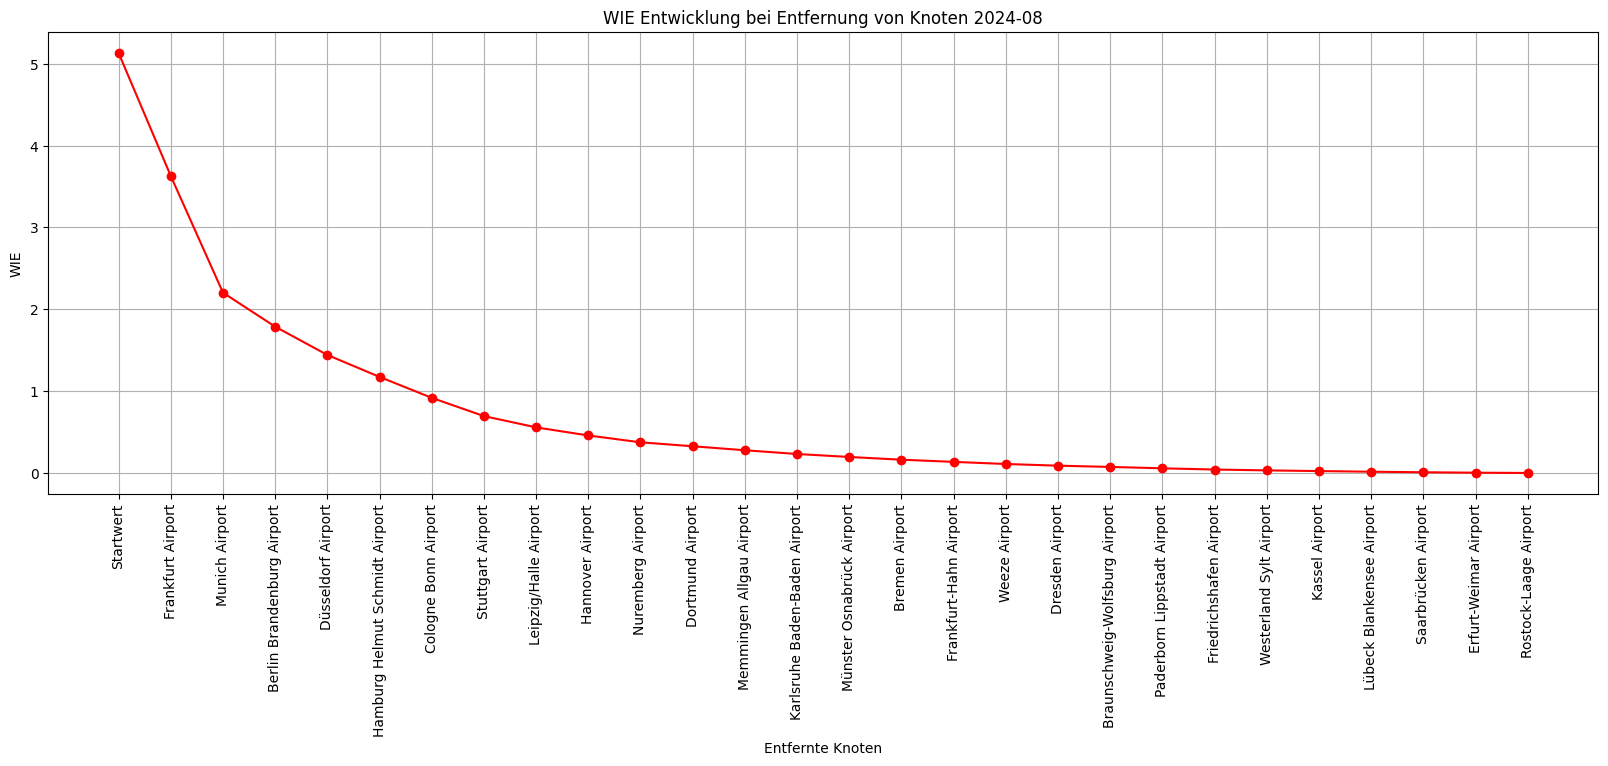

Number of nodes (airports): 1083
Number of edges (flight routes): 7224, sum of weights (flights) 72672.0
Found 1112 international airports to check against
Number of edges (domestic flight routes): 2443, sum of weights (domestic flights) 16238.0
Number of edges (international flight routes): 4781, sum of weights (international flights) 56434.0
WIE_post has become zero.
International robustness for 2024-09: 0.7346956144656112


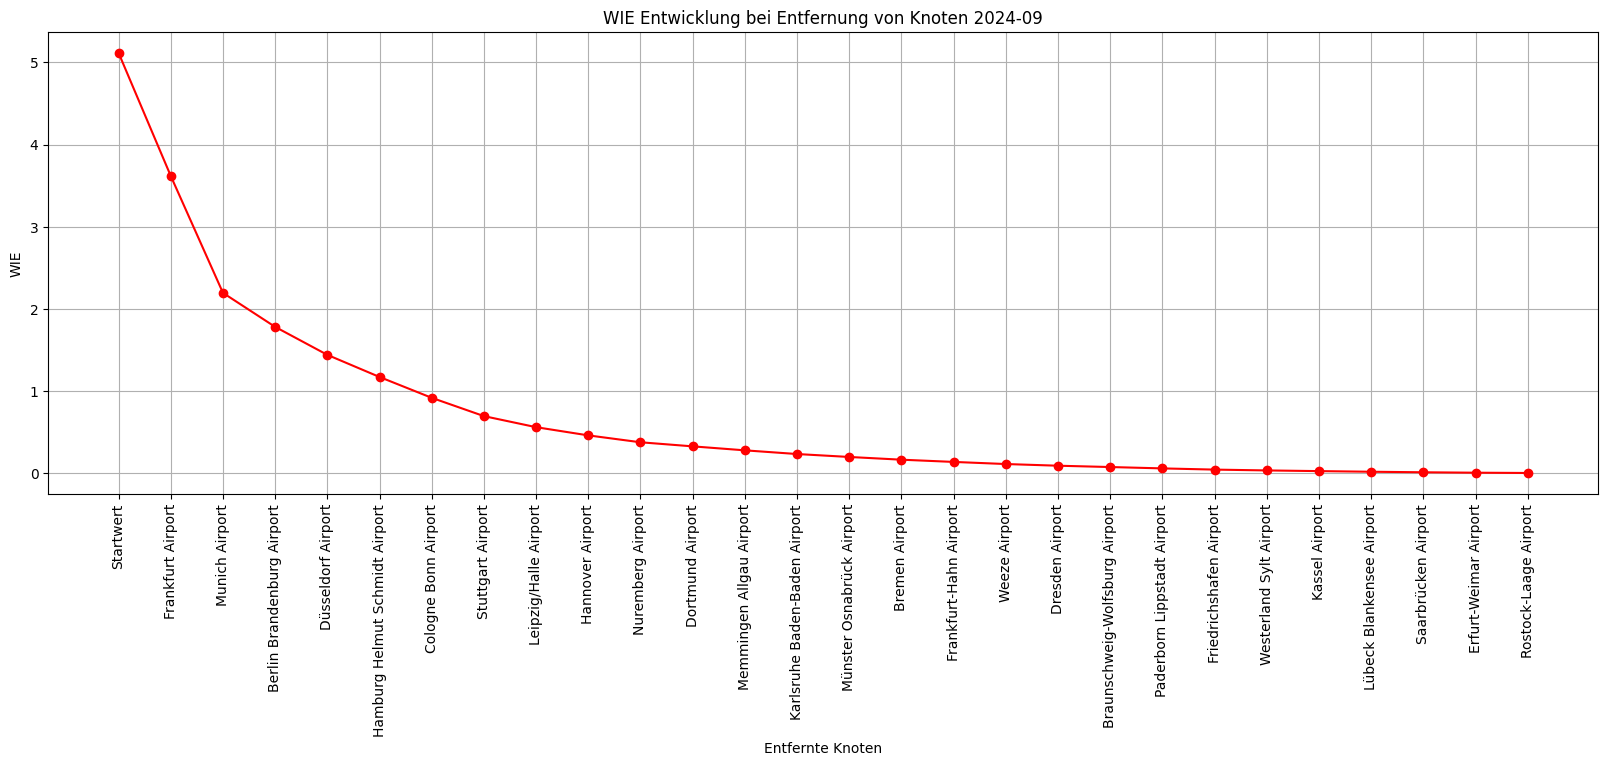

/content/drive/My Drive/2024KomplexeNetze/Daten/2024-10-01_2025-01-01_deutschland_v2.csv
Number of nodes (airports): 1083
Number of edges (flight routes): 6316, sum of weights (flights) 54972.0
Found 1020 international airports to check against
Number of edges (domestic flight routes): 2031, sum of weights (domestic flights) 13170.0
Number of edges (international flight routes): 4285, sum of weights (international flights) 41802.0
WIE_post has become zero.
International robustness for 2024-10: 0.7281404349123379


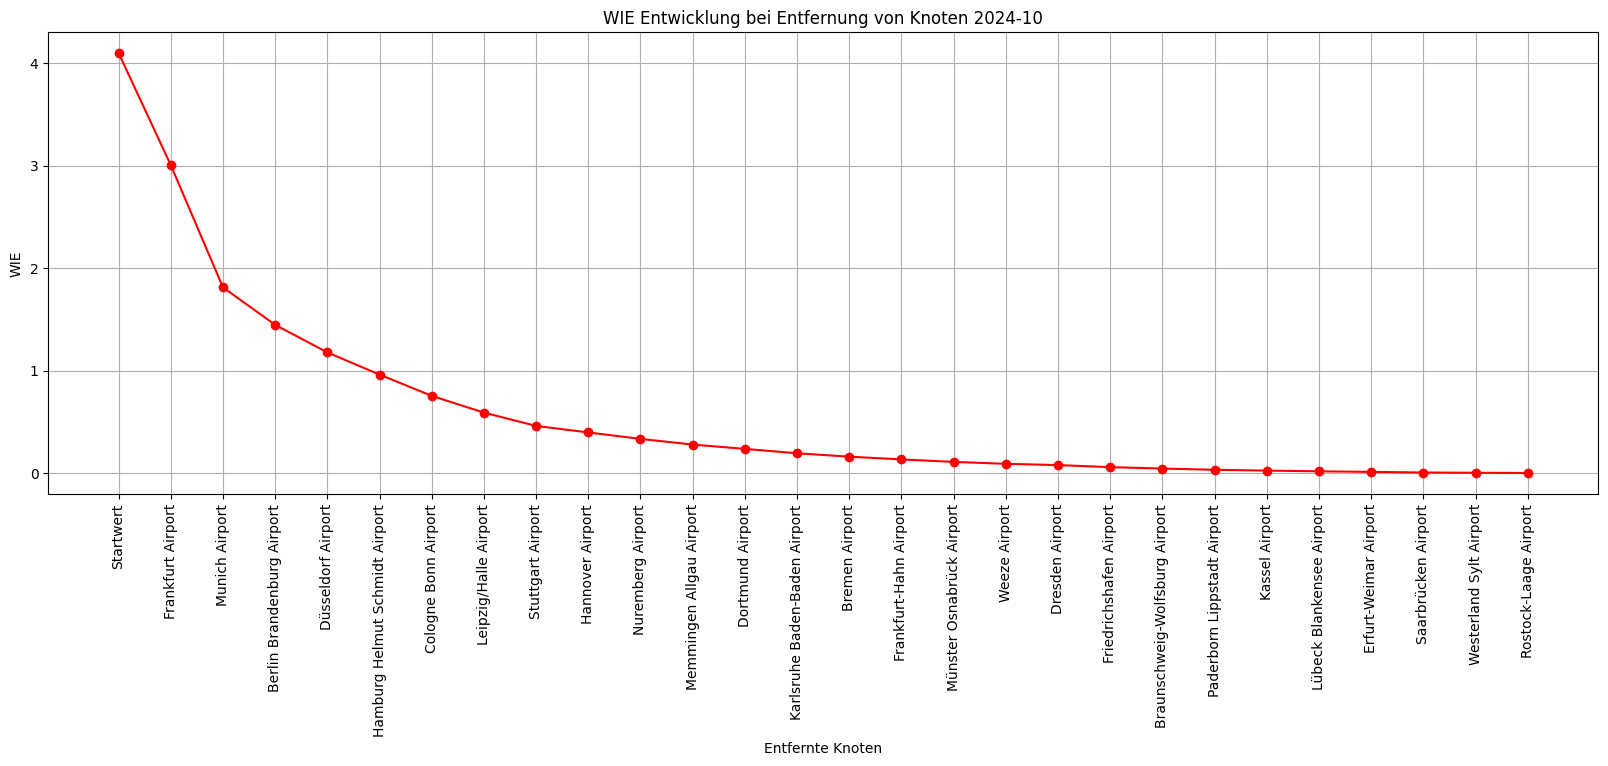

Number of nodes (airports): 918
Number of edges (flight routes): 5970, sum of weights (flights) 54378.0
Found 1020 international airports to check against
Number of edges (domestic flight routes): 1910, sum of weights (domestic flights) 12956.0
Number of edges (international flight routes): 4060, sum of weights (international flights) 41422.0
WIE_post has become zero.
International robustness for 2024-11: 0.7286806179124161


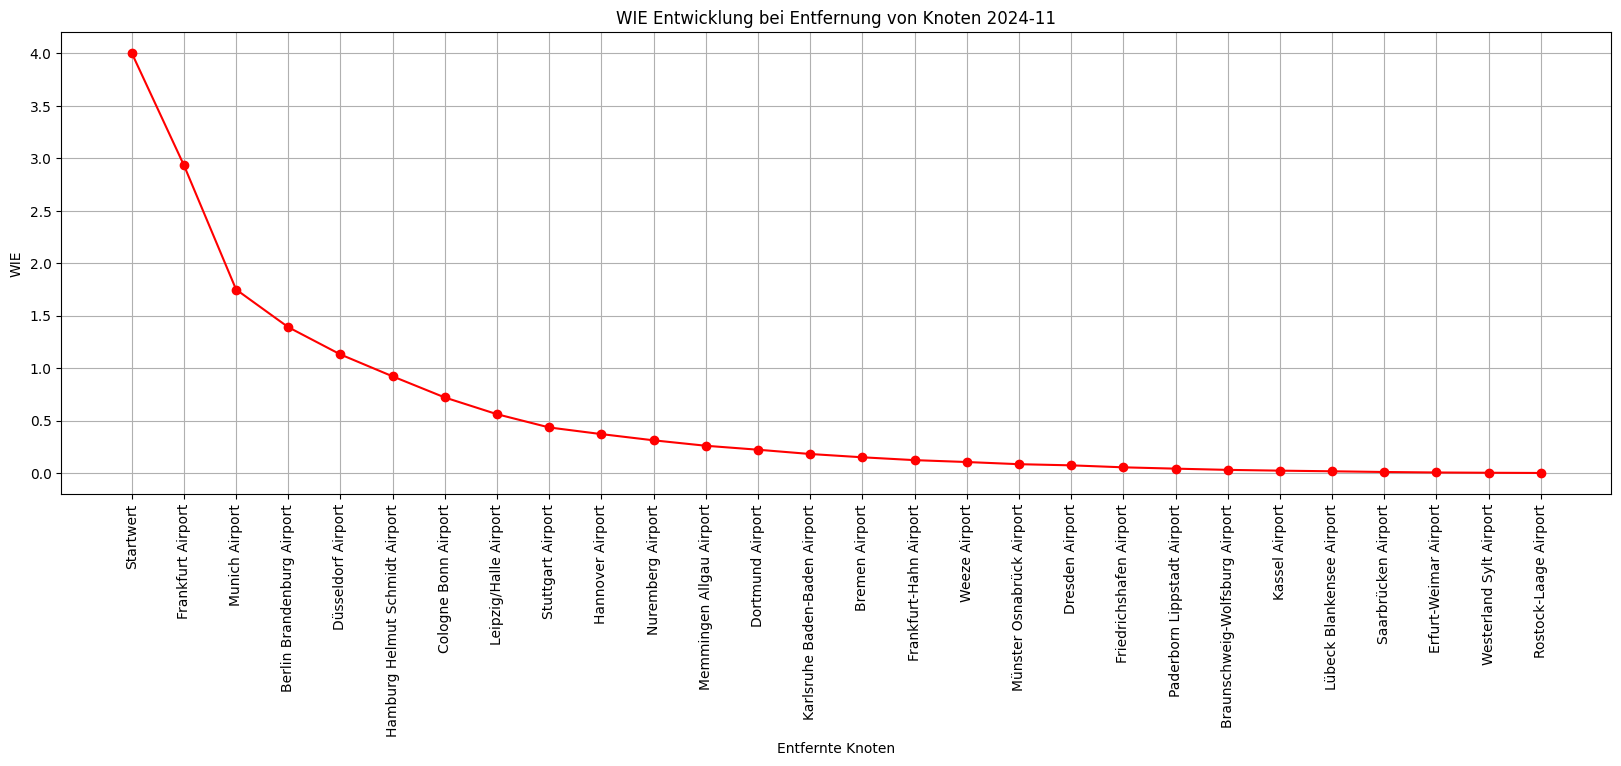

Number of nodes (airports): 868
Number of edges (flight routes): 5830, sum of weights (flights) 54026.0
Found 1020 international airports to check against
Number of edges (domestic flight routes): 1883, sum of weights (domestic flights) 12943.0
Number of edges (international flight routes): 3947, sum of weights (international flights) 41083.0
WIE_post has become zero.
International robustness for 2024-12: 0.73113206194937


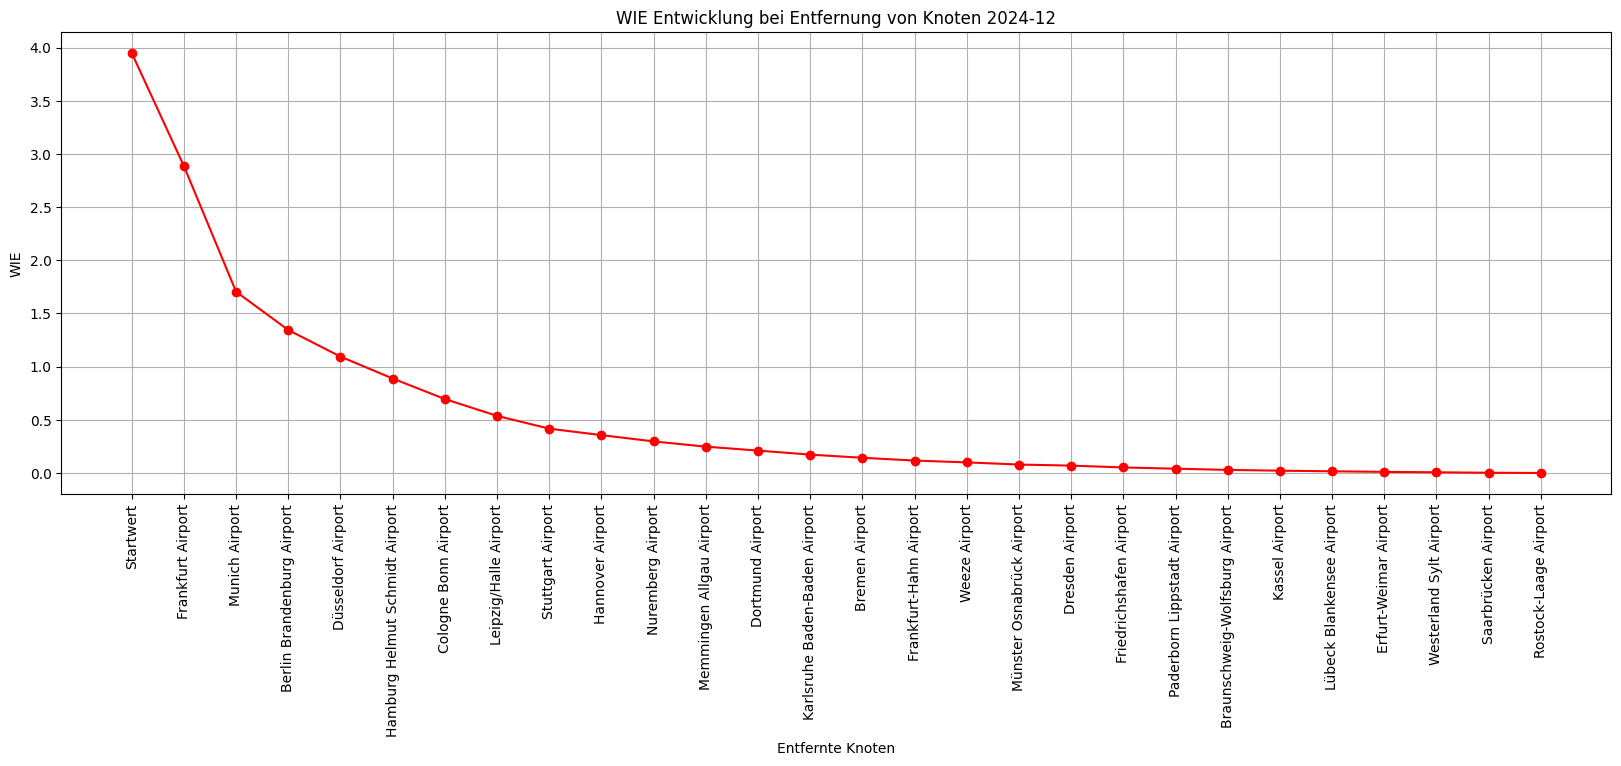

DataFrame saved to: /content/drive/My Drive/2024KomplexeNetze/Ergebnisse/wie_deutschland_v2_20250102_171627.csv


In [ ]:
# Get the current date and time
now = datetime.now()
timestamp = now.strftime("%Y%m%d_%H%M%S")

# Initialize lists to store WIE and IR values for each year
wie_2019 = []
wie_2018 = []
wie_2023 = []
wie_2024 = []
ir_2019 = []
ir_2018 = []
ir_2023 = []
ir_2024 = []
ieflight_2019 = []
ieflight_2018 = []
ieflight_2023 = []
ieflight_2024 = []
neroute_2019 = []
neroute_2018 = []
neroute_2023 = []
neroute_2024 = []
ieflight_int_2019 = []
ieflight_int_2018 = []
ieflight_int_2023 = []
ieflight_int_2024 = []
neroute_int_2019 = []
neroute_int_2018 = []
neroute_int_2023 = []
neroute_int_2024 = []
ieflight_nat_2019 = []
ieflight_nat_2018 = []
ieflight_nat_2023 = []
ieflight_nat_2024 = []
neroute_nat_2019 = []
neroute_nat_2018 = []
neroute_nat_2023 = []
neroute_nat_2024 = []
months_2019 = []
months_2018 = []
months_2023 = []
months_2024 = []

for csv_file in csv_files:

  flightdata = pd.read_csv(csv_file, parse_dates=["firstseen", "lastseen", "day"])
  print(csv_file)


  #flightdata.head()
  #flightdata.describe()
  #nan_percentage = (flightdata.isna().sum() / len(flightdata)) * 100
  #print(nan_percentage)
  flightdata.dropna(inplace=True)
#  flightdata.describe()

  #replace all entries EDDT with EDDB  for account for Berlin-Brandenburg replacing Tegel in 2020
  flightdata['departure'] = flightdata['departure'].replace('EDDT', 'EDDB')
  flightdata['arrival'] = flightdata['arrival'].replace('EDDT', 'EDDB')

  #departure_counts = flightdata['departure'].value_counts()
  #eddm_count = departure_counts.get('EDDM', 0)
  #eddf_count = departure_counts.get('EDDF', 0)
  #print(f"at the start: The departure value 'EDDF' appears {eddf_count} times, and EDDM {eddm_count} times.")

  flightdata=flightdata.merge(airports.data[["icao", "municipality"]], left_on="departure", right_on="icao", how="left", )
  flightdata = flightdata.rename(columns={"municipality": "departure_city"})
  flightdata=flightdata.merge(airports.data[["icao", "municipality"]], left_on="arrival", right_on="icao", how="left", )
  flightdata = flightdata.rename(columns={"municipality": "arrival_city"})

  # add a column to flightdata dataframe with contains week-and-year
  flightdata['week_and_year'] = flightdata['day'].dt.strftime('%Y-%U')
  #flightdata.tail()

  # add a column to flightdata dataframe with contains month-and-year
  flightdata['month_and_year'] = flightdata['day'].dt.strftime('%Y-%m')
  #flightdata.tail()

  # query dataframe for everything starting/ending at one of the selected airports
  #flightdata = flightdata[flightdata['departure'].isin(icaolist) | flightdata['arrival'].isin(icaolist)]
  flightdata = flightdata[flightdata['departure'].isin(icaolist)]

  # analyse the data by month
  for month_year in flightdata['month_and_year'].unique():
    # Filter the flightdata for the chosen year_month
    filtered_flightdata = flightdata[flightdata['month_and_year'] == month_year]
    #departure_counts = filtered_flightdata['departure'].value_counts()
    #eddm_count = departure_counts.get('EDDM', 0)
    #eddf_count = departure_counts.get('EDDF', 0)
    #print(f"after selecting {month_year}: The departure value 'EDDF' appears {eddf_count} times, and EDDM {eddm_count} times.")

    # Create a directed graph
    #    trafficgraph = nx.DiGraph()
    weightedgraph = nx.DiGraph()

    # Part 1: Add nodes from the flights data
    for index, row in filtered_flightdata.iterrows():
        origin = row['departure']
        destination = row['arrival']

        # Add the origin and destination as nodes if they don't exist (and are not identical)
        if origin != destination:
          if origin not in weightedgraph:
              weightedgraph.add_node(origin)
          if destination not in weightedgraph:
              weightedgraph.add_node(destination)


    print("Number of nodes (airports):", weightedgraph.number_of_nodes())

    # Part 2: Add weighted edges from the flights data

    # Group flights by origin, destination, and day to count weekly connections
    #weekly_connections = flightdata.groupby(['departure', 'arrival', 'week_and_year']).size().reset_index(name='connections')
    #print(weekly_connections.tail())
    #average_connections = weekly_connections.groupby(['departure', 'arrival'])['connections'].mean().reset_index()
    #print(average_connections.tail())

    # Group flights by origin, destination, and day to count monthly connections
    monthly_connections = flightdata.groupby(['departure', 'arrival', 'month_and_year']).size().reset_index(name='connections')
    #print(monthly_connections.head())

    # Calculate the average connections for each departure-arrival combination
    #average_connections = monthly_connections.groupby(['departure', 'arrival'])['connections'].mean().reset_index()
    #print(average_connections.tail())

    # Add weighted edges based on average connections
    for index, row in monthly_connections.iterrows():
      if row['departure'] != row['arrival']:
        origin = row['departure']
        destination = row['arrival']
        weight = row['connections']

        # Add the edge with the calculated weight
        if origin in weightedgraph and destination in weightedgraph:
            weightedgraph.add_edge(origin, destination, weight=weight)

    nflights= weightedgraph.size(weight="weight")
    nroutes=weightedgraph.number_of_edges()
    print(f"Number of edges (flight routes): {nroutes}, sum of weights (flights) {nflights}" )
    #print(list(weightedgraph.degree(['EDDF','EDDM'], weight="weight")))

    # make a list of all arrival airports with icao not matching a string starting with ED
    international_list = flightdata[~flightdata['arrival'].str.startswith('ED')]['arrival'].unique()
    print (f'Found {len(international_list)} international airports to check against')

    # construct subgraph of weightedgraph that contains only arrivals in international_list
    international_graph = nx.DiGraph()
    # construct subgraph of weightedgraph that contains only arrivals NOT in international_list
    domestic_graph = nx.DiGraph()
    for u, v, data in weightedgraph.edges(data=True):
      if v in international_list:
        international_graph.add_edge(u, v, weight=data['weight'])
      else:
        domestic_graph.add_edge(u, v, weight=data['weight'])

    nflights_nat= domestic_graph.size(weight="weight")
    nroutes_nat=domestic_graph.number_of_edges()
    print(f"Number of edges (domestic flight routes): {nroutes_nat}, sum of weights (domestic flights) {nflights_nat}" )
    nflights_int= international_graph.size(weight="weight")
    nroutes_int=international_graph.number_of_edges()
    print(f"Number of edges (international flight routes): {nroutes_int}, sum of weights (international flights) {nflights_int}" )


    # Extract year and month
    year, month = map(int, month_year.split('-'))

    # Let's see what the WIE is
    # While doing that, calculate the ratio of post- and pre- WIEs.
    modified_graph = weightedgraph.copy()
    sum_ratio = 0
    WIE_pre = analyze_graph_WIE(modified_graph.copy())
    if year == 2019:
      wie_2019.append(WIE_pre)
      months_2019.append(f'{month:02}')
    elif year == 2018:
      wie_2018.append(WIE_pre)
      months_2018.append(f'{month:02}')
    elif year == 2023:
      wie_2023.append(WIE_pre)
      months_2023.append(f'{month:02}')
    elif year == 2024:
      wie_2024.append(WIE_pre)
      months_2024.append(f'{month:02}')

    ratio_values = []
    removed_nodes = []
    ratio_values.append(WIE_pre)
    removed_nodes.append("Startwert")
    while True and WIE_pre > 0:
        nodes_in_icaolist = [node for node in modified_graph.nodes if node in icaolist]
        if not nodes_in_icaolist:
            break
        modified_graph, removed_node = remove_highest_degree_node(modified_graph, icaolist)
        WIE_post=analyze_graph_WIE(modified_graph.copy())
        ratio = WIE_post/WIE_pre
        if WIE_post == 0:
            print("WIE_post has become zero.")
        WIE_pre = WIE_post
        sum_ratio += ratio
        ratio_values.append(WIE_post)
        #print(f"removed node: {removed_node}, WIE_pre: {WIE_pre}, WIE_post: {WIE_post}, ratio: {ratio}")
        removed_nodes.append(airports[removed_node].name)
        #removed_nodes.append(removed_node)

    ir = sum_ratio / len(icaolist)
    if year == 2019:
      ir_2019.append(ir)
      ieflight_2019.append(nflights)
      ieflight_int_2019.append(nflights_int)
      ieflight_nat_2019.append(nflights_nat)
      neroute_2019.append(nroutes)
      neroute_nat_2019.append(nroutes_nat)
      neroute_int_2019.append(nroutes_int)
    elif year == 2018:
      ir_2018.append(ir)
      ieflight_2018.append(nflights)
      ieflight_int_2018.append(nflights_int)
      ieflight_nat_2018.append(nflights_nat)
      neroute_2018.append(nroutes)
      neroute_nat_2018.append(nroutes_nat)
      neroute_int_2018.append(nroutes_int)
    elif year == 2023:
      ir_2023.append(ir)
      ieflight_2023.append(nflights)
      ieflight_int_2023.append(nflights_int)
      ieflight_nat_2023.append(nflights_nat)
      neroute_2023.append(nroutes)
      neroute_nat_2023.append(nroutes_nat)
      neroute_int_2023.append(nroutes_int)
    elif year == 2024:
      ir_2024.append(ir)
      ieflight_2024.append(nflights)
      ieflight_int_2024.append(nflights_int)
      ieflight_nat_2024.append(nflights_nat)
      neroute_2024.append(nroutes)
      neroute_nat_2024.append(nroutes_nat)
      neroute_int_2024.append(nroutes_int)
    print(f"International robustness for {month_year}: {ir}")


    # Plotting after the loops
    fig = fig = plt.figure(figsize=(20, 6))
    #plt.plot(range(1, len(ratio_values) + 1), ratio_values, marker='o', linestyle='-')
    #plt.xlabel('Loop Iteration')
    #plt.title('WIE Value vs. Loop Iteration')
    plt.plot(removed_nodes, ratio_values, markerToUse,  color=colorToUse)
    plt.xlabel('Entfernte Knoten')
    plt.xticks(rotation=90)
    plt.title(f'WIE Entwicklung bei Entfernung von Knoten {month_year}')
    plt.ylabel('WIE')
    plt.grid(True)
    resultfilename = f"/content/drive/My Drive/2024KomplexeNetze/Ergebnisse/png/wieloop_{year}_{month}_{countryname}_{timestamp}.png"
    plt.savefig(resultfilename, bbox_inches=Bbox([[0,-3],fig.get_size_inches()]))
    resultfilename = f"/content/drive/My Drive/2024KomplexeNetze/Ergebnisse/svg/wieloop_{year}_{month}_{countryname}_{timestamp}.svg"
    plt.savefig(resultfilename, bbox_inches=Bbox([[0,-3],fig.get_size_inches()]))
    plt.show()



    # Create a DataFrame for the current month_year
    df_current_month = pd.DataFrame({
        'month': [month] * len(ratio_values),
        'year': [year] * len(ratio_values),
        'removed_nodes': removed_nodes,
        'ratio_values': ratio_values
    })

    # Concatenate the current month's DataFrame with the existing DataFrame (if it exists)
    if 'df_all_months' not in locals():
        df_all_months = df_current_month
    else:
        df_all_months = pd.concat([df_all_months, df_current_month], ignore_index=True)



# When the loop is done, save the dataframe with all the WIE-steps to a CSV file in Google Drive
resultfilename = f"/content/drive/My Drive/2024KomplexeNetze/Ergebnisse/wie_{countryname}_{timestamp}.csv"
df_all_months.to_csv(resultfilename, index=False)
print(f"DataFrame saved to: {resultfilename}")

-------------------------
Export the results

In [ ]:
# Create a list to store all dataframes for each year
dfs = []

# Iterate through the years
for year in [2018, 2019, 2023, 2024]:
    # Create a dictionary to hold data for the current year
    year_data = {
        'Month': [],
        'WIE': [],
        'IR': [],
        'ieflight': [],
        'ieflight_int': [],
        'ieflight_nat': [],
        'neroute': [],
        'neroute_nat': [],
        'neroute_int': []
    }

    # Assign the correct month list and data lists for the year
    if year == 2018:
        months = months_2018
        wie = wie_2018
        ir = ir_2018
        ieflight = ieflight_2018
        ieflight_int = ieflight_int_2018
        ieflight_nat = ieflight_nat_2018
        neroute = neroute_2018
        neroute_nat = neroute_nat_2018
        neroute_int = neroute_int_2018
    elif year == 2019:
        months = months_2019
        wie = wie_2019
        ir = ir_2019
        ieflight = ieflight_2019
        ieflight_int = ieflight_int_2019
        ieflight_nat = ieflight_nat_2019
        neroute = neroute_2019
        neroute_nat = neroute_nat_2019
        neroute_int = neroute_int_2019
    elif year == 2023:
        months = months_2023
        wie = wie_2023
        ir = ir_2023
        ieflight = ieflight_2023
        ieflight_int = ieflight_int_2023
        ieflight_nat = ieflight_nat_2023
        neroute = neroute_2023
        neroute_nat = neroute_nat_2023
        neroute_int = neroute_int_2023
    elif year == 2024:
        months = months_2024
        wie = wie_2024
        ir = ir_2024
        ieflight = ieflight_2024
        ieflight_int = ieflight_int_2024
        ieflight_nat = ieflight_nat_2024
        neroute = neroute_2024
        neroute_nat = neroute_nat_2024
        neroute_int = neroute_int_2024
    else:
        continue

    # print the lengths of the different lists
    print(f"months: {len(months)}, wie: {len(wie)}, ir: {len(ir)}, ieflight: {len(ieflight)}, neroute: {len(neroute)}")
    print(months)
    print(ieflight)

    # Populate the year_data dictionary
    year_data['Month'] = months
    year_data['WIE'] = wie
    year_data['IR'] = ir
    year_data['ieflight'] = ieflight
    year_data['ieflight_int'] = ieflight_int
    year_data['ieflight_nat'] = ieflight_nat
    year_data['neroute'] = neroute
    year_data['neroute_nat'] = neroute_nat
    year_data['neroute_int'] = neroute_int

    # Create a dataframe for the current year
    df_year = pd.DataFrame(year_data)
    df_year['Year'] = year  # Add a 'Year' column

    #Append the year's dataframe to the list
    dfs.append(df_year)


# Concatenate all dataframes into a single dataframe
dfresult = pd.concat(dfs, ignore_index=True)

# Define the filename with the timestamp
resultfilename = f"/content/drive/My Drive/2024KomplexeNetze/Ergebnisse/ir_{countryname}_{timestamp}.csv"

# Save the result dataframe to a CSV file in Google Drive
dfresult.to_csv(resultfilename, index=False)
print(f"DataFrame saved to: {resultfilename}")


months: 12, wie: 12, ir: 12, ieflight: 12, neroute: 12
['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
[52388.0, 52528.0, 52910.0, 55162.0, 59806.0, 59808.0, 57994.0, 58447.0, 58069.0, 55461.0, 54915.0, 54820.0]
months: 12, wie: 12, ir: 12, ieflight: 12, neroute: 12
['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
[61483.0, 61525.0, 61725.0, 65711.0, 66620.0, 66643.0, 73245.0, 73460.0, 73582.0, 64030.0, 63470.0, 63380.0]
months: 12, wie: 12, ir: 12, ieflight: 12, neroute: 12
['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
[54886.0, 54949.0, 55431.0, 66597.0, 67269.0, 67347.0, 70346.0, 70531.0, 70399.0, 49378.0, 48330.0, 48096.0]
months: 12, wie: 12, ir: 12, ieflight: 12, neroute: 12
['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
[54618.0, 54677.0, 54923.0, 65518.0, 66031.0, 66256.0, 72623.0, 72854.0, 72672.0, 54972.0, 54378.0, 54026.0]
DataFrame saved to: /content/drive/My Drive/2024Komp

Now make some plots of the reults

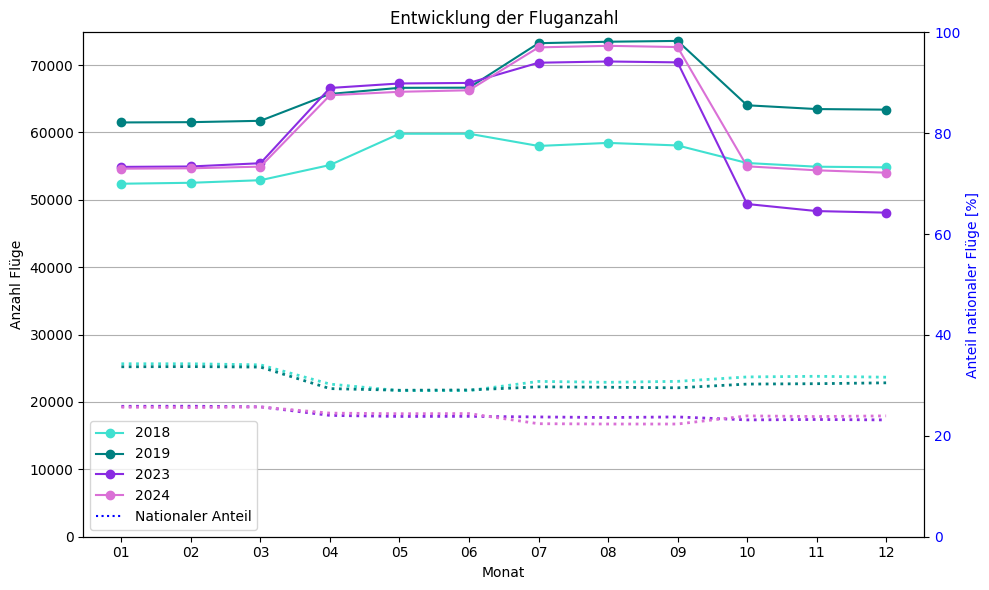

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot ieflight data on the first axis
ax1.plot(months_2018, ieflight_2018, markerToUse, color='turquoise', label='2018')
ax1.plot(months_2019, ieflight_2019, markerToUse, color='teal', label='2019')
ax1.plot(months_2023, ieflight_2023, markerToUse, color='blueviolet', label='2023')
ax1.plot(months_2024, ieflight_2024, markerToUse, color='orchid', label='2024')

plt.title('Entwicklung der Fluganzahl')
ax1.set_xlabel('Monat')
ax1.set_ylabel('Anzahl Flüge')
ax1.tick_params(axis='y')

ax1.grid(True, axis='y') # Add gridlines only for y-axis


plt.ylim(bottom=0000)


from matplotlib.lines import Line2D
dotline = Line2D([0], [0], label='Nationaler Anteil', color='blue', linestyle='dotted')
handles, labels = plt.gca().get_legend_handles_labels()
# manually add line to legend
handles.extend([dotline])
plt.legend(handles=handles, loc='lower left')
# Create a second axis sharing the same x-axis
ax2 = ax1.twinx()

# Calculate and plot the ratio on the second axis
ratio = [100* i / (i+j) for i, j in zip(ieflight_nat_2018, ieflight_int_2018)]
ax2.plot(months_2018, ratio,  linewidth=2, linestyle='dotted', color='turquoise', label='Ratio 2018')
ratio = [100* i / (i+j) for i, j in zip(ieflight_nat_2019, ieflight_int_2019)]
ax2.plot(months_2019, ratio,  linewidth=2, linestyle='dotted', color='teal', label='Ratio 2019')
ratio = [100* i / (i+j) for i, j in zip(ieflight_nat_2023, ieflight_int_2023)]
ax2.plot(months_2023, ratio,  linewidth=2, linestyle='dotted', color='blueviolet', label='Ratio 2023')
ratio = [100* i / (i+j) for i, j in zip(ieflight_nat_2024, ieflight_int_2024)]
ax2.plot(months_2024, ratio,  linewidth=2, linestyle='dotted', color='orchid', label='Ratio 2024')

ax2.set_ylabel('Anteil nationaler Flüge [%]', color='blue')  # Set y-axis label color
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(0, 100)

plt.tight_layout()

filetitle="ieflight"
resultfilename = f"/content/drive/My Drive/2024KomplexeNetze/Ergebnisse/png/{filetitle}_{countryname}_{timestamp}.png"
plt.savefig(resultfilename)
resultfilename = f"/content/drive/My Drive/2024KomplexeNetze/Ergebnisse/svg/{filetitle}_{countryname}_{timestamp}.svg"
plt.savefig(resultfilename)

plt.show()

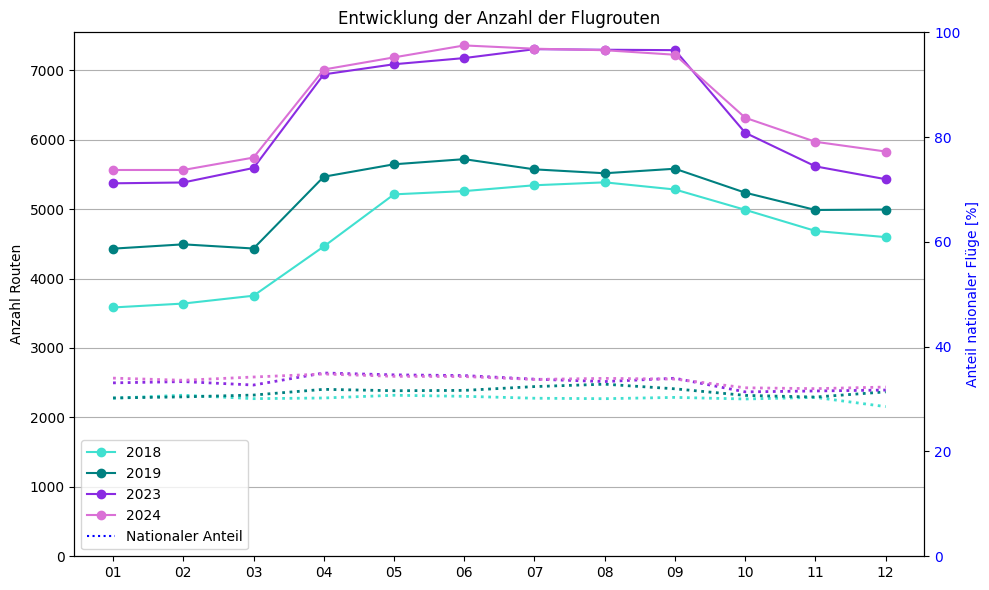

In [ ]:
# Create the plot for number of edges

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot neroutes data on the first axis
ax1.plot(months_2018, neroute_2018, markerToUse, color='turquoise', label='2018')
ax1.plot(months_2019, neroute_2019, markerToUse, color='teal', label='2019')
ax1.plot(months_2023, neroute_2023, markerToUse, color='blueviolet', label='2023')
ax1.plot(months_2024, neroute_2024, markerToUse, color='orchid', label='2024')

plt.title('Entwicklung der Fluganzahl')
plt.ylabel('Anzahl Routen')
plt.title('Entwicklung der Anzahl der Flugrouten')
ax1.tick_params(axis='y')

ax1.grid(True, axis='y') # Add gridlines only for y-axis


plt.ylim(bottom=0000)


from matplotlib.lines import Line2D
dotline = Line2D([0], [0], label='Nationaler Anteil', color='blue', linestyle='dotted')
handles, labels = plt.gca().get_legend_handles_labels()
# manually add line to legend
handles.extend([dotline])
plt.legend(handles=handles, loc='lower left')
# Create a second axis sharing the same x-axis
ax2 = ax1.twinx()

# Calculate and plot the ratio on the second axis
ratio = [100* i / (i+j) for i, j in zip(neroute_nat_2018, neroute_int_2018)]
ax2.plot(months_2018, ratio,  linewidth=2, linestyle='dotted', color='turquoise', label='Ratio 2018')
ratio = [100* i / (i+j) for i, j in zip(neroute_nat_2019, neroute_int_2019)]
ax2.plot(months_2019, ratio,  linewidth=2, linestyle='dotted', color='teal', label='Ratio 2019')
ratio = [100* i / (i+j) for i, j in zip(neroute_nat_2023, neroute_int_2023)]
ax2.plot(months_2023, ratio,  linewidth=2, linestyle='dotted', color='blueviolet', label='Ratio 2023')
ratio = [100* i / (i+j) for i, j in zip(neroute_nat_2024, neroute_int_2024)]
ax2.plot(months_2024, ratio,  linewidth=2, linestyle='dotted', color='orchid', label='Ratio 2024')

ax2.set_ylabel('Anteil nationaler Flüge [%]', color='blue')  # Set y-axis label color
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(0, 100)

plt.tight_layout()

filetitle="neroute"
resultfilename = f"/content/drive/My Drive/2024KomplexeNetze/Ergebnisse/png/{filetitle}_{countryname}_{timestamp}.png"
plt.savefig(resultfilename)
resultfilename = f"/content/drive/My Drive/2024KomplexeNetze/Ergebnisse/svg/{filetitle}_{countryname}_{timestamp}.svg"
plt.savefig(resultfilename)

plt.show()

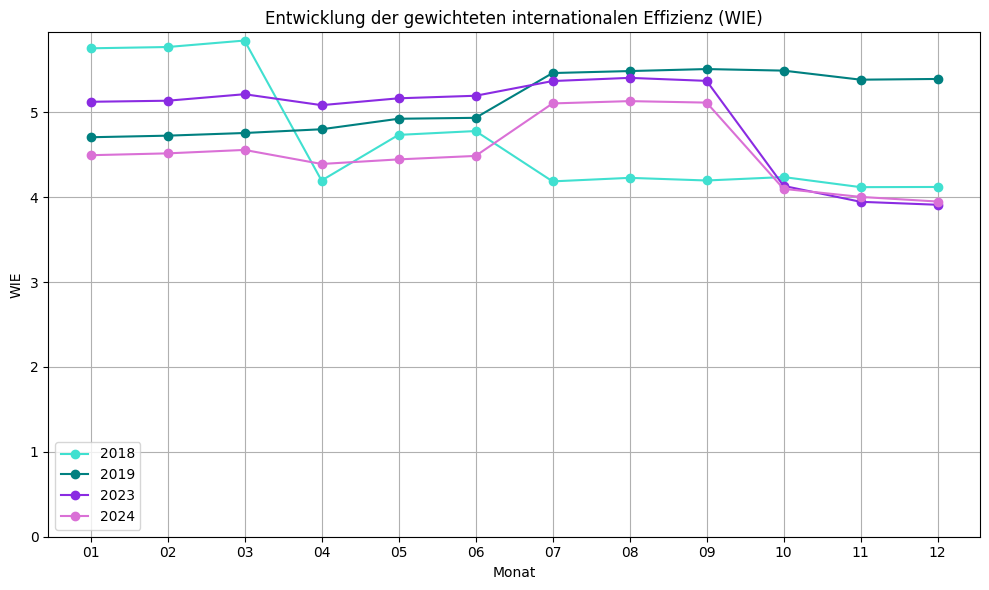

In [ ]:
# # Create the plot for WIE
fig = plt.figure(figsize=(10, 6))
plt.plot(months_2018, wie_2018, markerToUse, color='turquoise', label='2018')
plt.plot(months_2019, wie_2019, markerToUse, color='teal', label='2019')
plt.plot(months_2023, wie_2023, markerToUse, color='blueviolet', label='2023')
plt.plot(months_2024, wie_2024, markerToUse, color='orchid', label='2024')

plt.xlabel('Monat')
plt.ylabel('WIE')
plt.title('Entwicklung der gewichteten internationalen Effizienz (WIE)')
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.tight_layout()

filetitle="WIE"
resultfilename = f"/content/drive/My Drive/2024KomplexeNetze/Ergebnisse/png/{filetitle}_{countryname}_{timestamp}.png"
plt.savefig(resultfilename)
resultfilename = f"/content/drive/My Drive/2024KomplexeNetze/Ergebnisse/svg/{filetitle}_{countryname}_{timestamp}.svg"
plt.savefig(resultfilename)

plt.show()

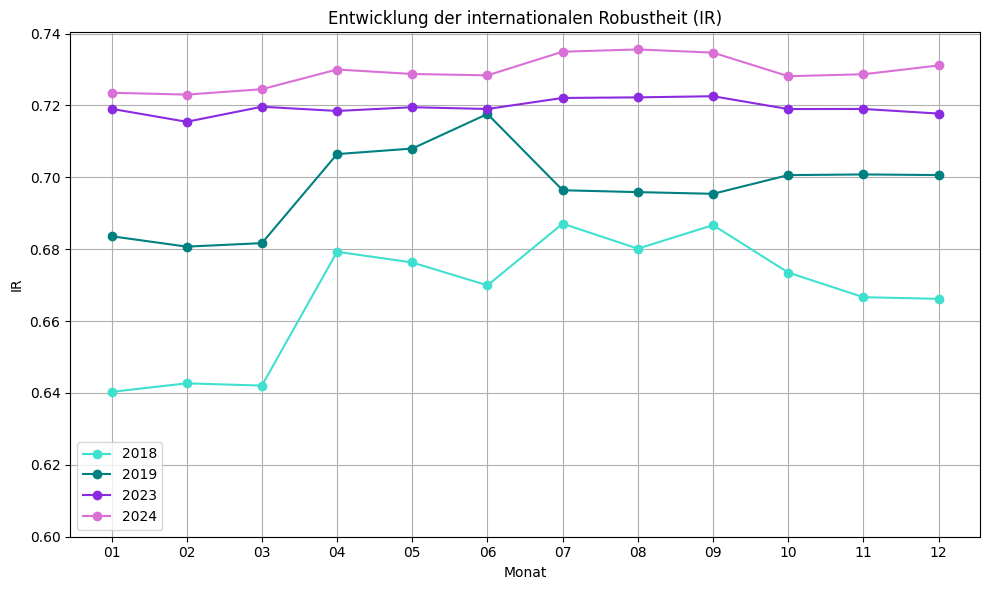

In [ ]:
# # Create the plot for ir
fig = plt.figure(figsize=(10, 6))
plt.plot(months_2018, ir_2018, markerToUse, color='turquoise', label='2018')
plt.plot(months_2019, ir_2019, markerToUse, color='teal', label='2019')
plt.plot(months_2023, ir_2023, markerToUse, color='blueviolet', label='2023')
plt.plot(months_2024, ir_2024, markerToUse, color='orchid', label='2024')

plt.xlabel('Monat')
plt.ylabel('IR')
plt.title('Entwicklung der internationalen Robustheit (IR)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.ylim(bottom=0.6)

filetitle="IR"
resultfilename = f"/content/drive/My Drive/2024KomplexeNetze/Ergebnisse/png/{filetitle}_{countryname}_{timestamp}.png"
plt.savefig(resultfilename)
resultfilename = f"/content/drive/My Drive/2024KomplexeNetze/Ergebnisse/svg/{filetitle}_{countryname}_{timestamp}.svg"
plt.savefig(resultfilename)

plt.show()

In [ ]:
# Get the current date and time
now = datetime.now()
timestamp = now.strftime("%Y%m%d_%H%M%S")

# combine all files from list csv_file into one data frame pandas
allflights = pd.DataFrame()
for csv_file in csv_files:
  df = pd.read_csv(csv_file)
  allflights = pd.concat([allflights, df], ignore_index=True)

allflights.dropna(inplace=True)

#replace all entries EDDT with EDDB  for account for Berlin-Brandenburg replacing Tegel in 2020
allflights['departure'] = allflights['departure'].replace('EDDT', 'EDDB')
allflights['arrival'] = allflights['arrival'].replace('EDDT', 'EDDB')

allflights=allflights.merge(airports.data[["icao", "municipality"]], left_on="departure", right_on="icao", how="left", )
allflights = allflights.rename(columns={"municipality": "departure_city"})
allflights=allflights.merge(airports.data[["icao", "municipality"]], left_on="arrival", right_on="icao", how="left", )
allflights = allflights.rename(columns={"municipality": "arrival_city"})

# add a column to allflights dataframe with contains month-and-year
# allflights['month_and_year'] = allflights['day'].dt.strftime('%Y-%m')
#allflights.tail()


Number of nodes (airports): 2608


In [ ]:

# query dataframe for everything starting AND ending at one of the selected airports
allflights = allflights[allflights['departure'].isin(icaolist)]

# Create a directed graph
allweightedgraph = nx.DiGraph()

# # Part 1: Add nodes from the flights data
# for index, row in allflights.iterrows():
#     origin = row['departure']
#     destination = row['arrival']

#     # Add the origin and destination as nodes if they don't exist (and are not identical)
#     if origin != destination:
#       if origin not in allweightedgraph:
#           allweightedgraph.add_node(origin)
#       if destination not in weightedgraph:
#           allweightedgraph.add_node(destination)


# print("Number of nodes (airports):", allweightedgraph.number_of_nodes())

# Part 2: Add weighted edges from the flights data

all_connections = allflights.groupby(['departure', 'arrival']).size().reset_index(name='connections')

# create new filtered dataframe with only connections larger than 200
many_connections = all_connections[all_connections['connections'] > 200]

# Calculate the average connections for each departure-arrival combination
# Add weighted edges based on average connections
for index, row in many_connections.iterrows():
    if row['departure'] != row['arrival']:
        origin = row['departure']
        destination = row['arrival']
        weight = row['connections']

        # Add the edge with the calculated weight if departure is EDDH
        if origin in allweightedgraph and destination in allweightedgraph and origin == 'EDDH':
            allweightedgraph.add_edge(origin, destination, weight=weight)


In [ ]:
many_connections.tail()

departure arrival  connections
689      EDXW    EDDW          211
695      EDXW    EDLW          304
700      EDXW    EDXW          573
722      ETNL    EDNY          206
727      ETNL    ETNL         2075

<ipython-input-90-ebe4a1510476>:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout();


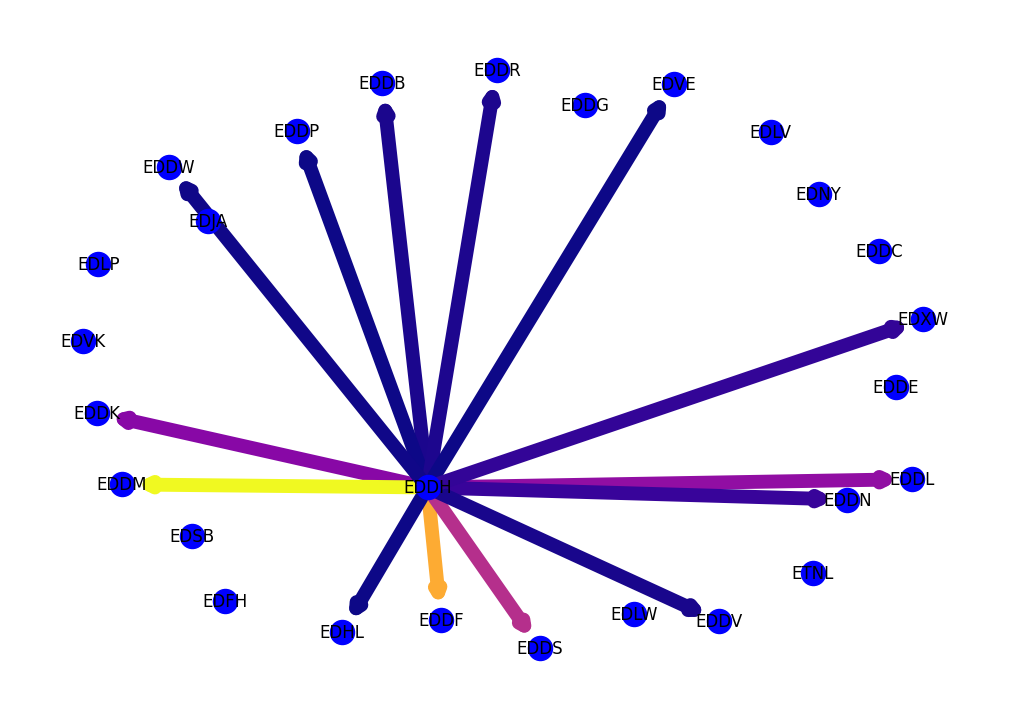

In [ ]:
# fixing the size of the figure
plt.figure(figsize =(10, 7))

pos = nx.random_layout(allweightedgraph)


edges,weights = zip(*nx.get_edge_attributes(allweightedgraph,'weight').items())

pos = nx.spring_layout(allweightedgraph)
nx.draw(allweightedgraph, pos, node_color='b', edgelist=edges, edge_color=weights, width=10.0, with_labels = True, edge_cmap=plt.cm.plasma)

# node_color = [allweightedgraph.degree(v) for v in allweightedgraph]
# # node colour is a list of degrees of nodes

# edge_width = [0.0015 * allweightedgraph[u][v]['weight'] for u, v in allweightedgraph.edges()]
# # width of edge is a list of weight of edges

# nx.draw_networkx(allweightedgraph,
# 				node_color = node_color, alpha = 0.7,
# 				with_labels = True, width = edge_width,
# 				edge_color ='.4', cmap = plt.cm.Blues)



# # edge weight labels
# #edge_labels = nx.get_edge_attributes(allweightedgraph, "weight")
# #nx.draw_networkx_edge_labels(allweightedgraph, pos, edge_labels)

plt.axis('off')
plt.tight_layout();
